# Laporan Teknis: Preprocessing Data untuk Klasifikasi Serangan IoT

## Tujuan Proyek
Notebook ini digunakan untuk **pra-pemrosesan data** sebelum membangun model klasifikasi serangan siber berbasis sensor IoT menggunakan pendekatan hybrid learning. Dataset yang digunakan merupakan data time series dari sensor perangkat Industrial IoT (TON_IoT dataset).

## Import Library
Notebook dimulai dengan mengimpor berbagai library penting yang digunakan untuk melakukan beberapa proses yang dibutuhkan dalam proses pembelajaran model.

In [2]:
# Jalankan **sebelum** mengimpor tensorflow/keras
import os

# Nonaktifkan oneDNN optimizations
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Batasi thread OpenMP / MKL agar tidak ada race / oversubscription
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["KMP_BLOCKTIME"] = "0"

# Kurangi logging noise
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0=all,1=info,2=warning,3=error
print("Env vars set. Restart kernel and run notebook from the top.")

Env vars set. Restart kernel and run notebook from the top.


In [3]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf, keras
import seaborn as sns
import keras_tuner as kt
import warnings
import pickle
import json
import copy
from pathlib import Path
from math import radians, sin, cos, atan2, degrees
from collections import deque
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler ,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,cohen_kappa_score, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, log_loss, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from tabnanny import verbose
import lightgbm as lgb
import shap

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (LSTM, Input, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D,
                                     BatchNormalization, LayerNormalization, Add, Activation, RepeatVector,
                                     Bidirectional, MultiHeadAttention, TimeDistributed)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from hyperopt import hp, tpe, fmin, Trials, space_eval
from scipy.spatial.distance import cdist

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print("Keras version:", keras.__version__)
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
TensorFlow version: 2.18.0
Keras version: 3.5.0
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [4]:
# Set random seeds for reproducibility
import random
from random import choice, shuffle
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

## Load Dataset
Dataset IoT dimuat dari file `.csv`:

```python
df = pd.read_csv('dataset.csv')
```

Selain itu, dataset yang di akuisisi juga ditampilkan shape, info, deskripsi, dan contoh data


In [4]:
# =============================
# DATA ACQUISITION
# =============================

# Load the TON_IoT dataset
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_GPS_Tracker.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (38960, 6)

DATASET OVERVIEW
        date        time    latitude   longitude  label  type
0  25-Apr-19   18:31:39   116.521704  132.162504      1  ddos
1  25-Apr-19   18:31:41   121.742933  135.072500      1  ddos
2  25-Apr-19   18:31:46   121.795929  135.110198      1  ddos
3  25-Apr-19   18:31:49   116.611216  132.224555      1  ddos
4  25-Apr-19   18:31:51   121.841526  135.151362      1  ddos
5  25-Apr-19   18:31:54   116.646869  132.295876      1  ddos
6  25-Apr-19   18:31:59   116.649518  132.419949      1  ddos
7  25-Apr-19   18:32:01   121.920022  135.308132      1  ddos
8  25-Apr-19   18:32:04   116.706300  132.420231      1  ddos
9  25-Apr-19   18:32:06   122.002085  135.325050      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       38960 non-null  object 
 1

## Eksplorasi Data (Data Exploration)

### Tujuan
Langkah eksplorasi data bertujuan untuk memahami struktur, tipe data, distribusi fitur, serta pola-pola penting yang terkandung dalam dataset serangan siber. Eksplorasi ini penting sebagai fondasi sebelum masuk ke tahap preprocessing dan modeling.

---

### 1. Pemeriksaan Tipe Data
Kode `df.dtypes` digunakan untuk memeriksa tipe setiap kolom dalam dataset. Ini membantu memastikan apakah data sudah dalam format yang sesuai, seperti `float` untuk fitur numerik (misalnya latitude, longitude) dan `object` untuk kategori (`type`, `label`).

---

### 2. Statistik Deskriptif Latitude & Longitude
Fungsi `describe()` pada kolom `latitude` dan `longitude` memberikan ringkasan statistik (mean, std, min, max, quartiles) yang penting untuk memahami skala data spasial dan mengidentifikasi potensi outlier.

---

### 3. Distribusi Kelas & Nilai Unik
Kode:
- `df['type'].unique()` menampilkan jenis serangan yang tersedia.
- `df['type'].value_counts()` menghitung jumlah masing-masing jenis serangan.
- `df['label'].value_counts()` menghitung banyaknya data dengan label "normal" atau "serangan".

Hal ini bertujuan untuk mengidentifikasi ketidakseimbangan kelas (class imbalance), yang sangat krusial untuk dipertimbangkan dalam model klasifikasi.

---

### 4. Visualisasi Distribusi Jenis Serangan
Visualisasi dilakukan dengan dua cara:
- **Bar chart** (`kind='bar'`) menunjukkan frekuensi absolut dari setiap jenis serangan.
- **Pie chart** (`kind='pie'`) menampilkan persentase dari masing-masing kategori serangan.

Kedua visualisasi ini memberikan gambaran menyeluruh tentang dominasi jenis serangan tertentu dan menyimpan grafik tersebut sebagai file gambar `attack_type_distribution.png`.

---

### 5. Visualisasi Distribusi Label
Distribusi antara `label` normal dan serangan divisualisasikan menggunakan bar chart. Ini penting untuk memantau apakah model nantinya akan mengalami bias terhadap kelas mayoritas. Grafik disimpan sebagai `label_distribution.png`.

---

### 6. Visualisasi Sebaran Geospasial
Scatter plot digunakan untuk menampilkan persebaran data berdasarkan koordinat `longitude` dan `latitude`. Titik-titik ini dapat menunjukkan pola spasial dari serangan jika ada konsentrasi tertentu pada lokasi geografis. Plot disimpan sebagai `location_scatter.png`.

---

Data Types:
date          object
time          object
latitude     float64
longitude    float64
label          int64
type          object
dtype: object

Latitude stats:
count    38960.000000
mean        55.520048
std         75.345705
min          0.000000
25%          2.427997
50%         36.623451
75%         86.592301
max        549.381916
Name: latitude, dtype: float64

Longitude stats:
count    38960.000000
mean        65.849669
std         76.086241
min         10.000000
25%         12.459648
50%         47.244773
75%         96.119494
max        555.133643
Name: longitude, dtype: float64

Unique attack types: ['ddos' 'backdoor' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2833
xss             577
scanning        550
Name: count, dtype: int64

Label distribution:
label
1    23960
0    15000
Name: count, dtype: int64


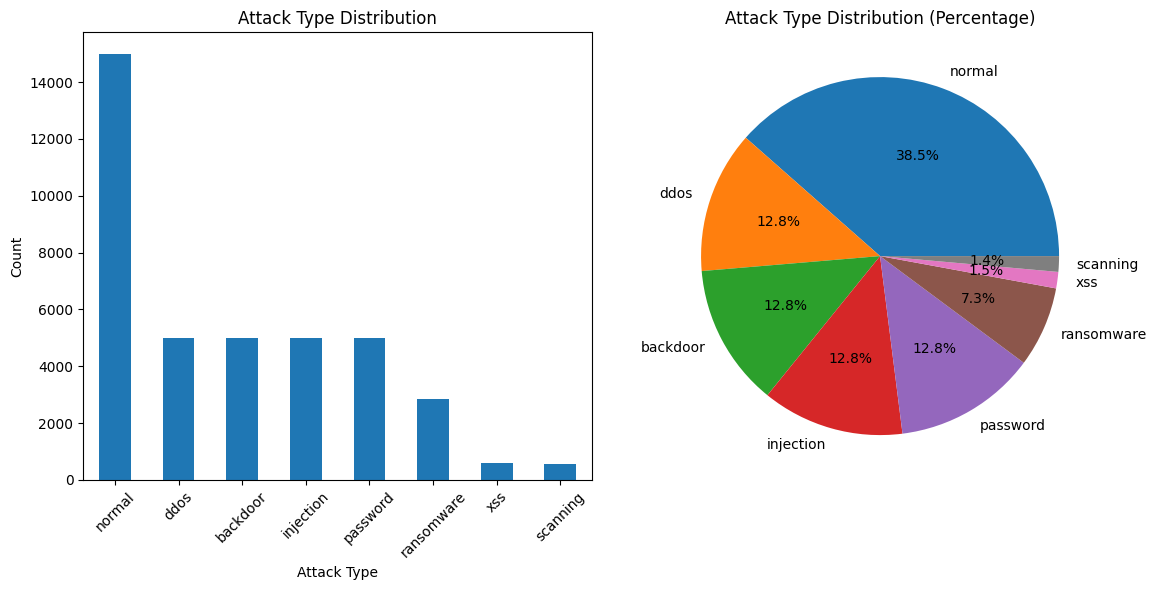

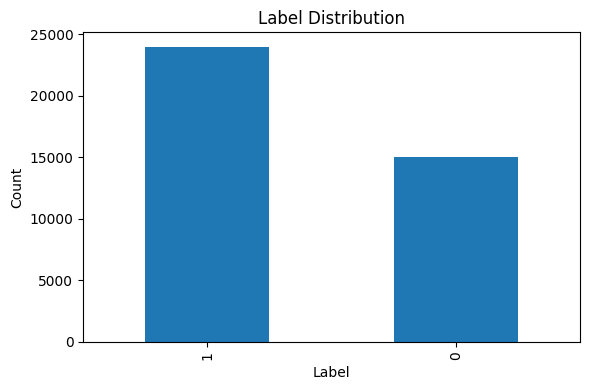

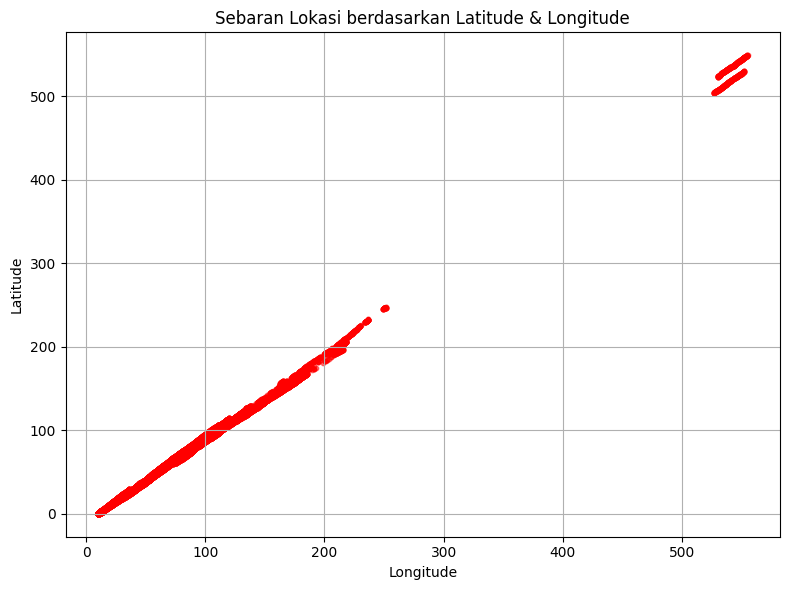

In [5]:
# =============================
# DATA EXPLORATION
# ================================

# Check data types
print("Data Types:")
print(df.dtypes)

print("\nLatitude stats:")
print(df['latitude'].describe())

print("\nLongitude stats:")
print(df['longitude'].describe())

# Check unique values in categorical columns
print(f"\nUnique attack types: {df['type'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

print(f"\nLabel distribution:")
label_distribution = df['label'].value_counts()
print(label_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Visualize label distribution
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], 
            c='red', alpha=0.5, s=10)
plt.title('Sebaran Lokasi berdasarkan Latitude & Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'location_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

# Feature Engineering untuk Deteksi Serangan Siber IoT

Dokumentasi ini menjelaskan proses rekayasa fitur (feature engineering) yang diterapkan pada data sensor IoT GPS Tracker, dalam konteks sistem deteksi jenis serangan siber seperti DDOS, injection, password, ransomware, scanning, dan XSS. Proses ini bertujuan untuk mengekstraksi fitur-fitur temporal, spasial, perilaku, serta interaksi antar fitur yang dapat meningkatkan performa model klasifikasi berbasis LSTM atau hybrid model lainnya.

---

## 1. Fitur Waktu

**Deskripsi:**
- Menggabungkan kolom `date` dan `time` menjadi `datetime`.
- Ekstraksi fitur seperti jam, menit, detik, hari dalam seminggu, dan apakah waktu tersebut akhir pekan.
- Dibuat juga fitur siklikal menggunakan sin dan cos untuk representasi waktu.

**Tujuan:**
Menangkap pola temporal yang khas dari jenis serangan tertentu. Misalnya:
- DDoS lebih sering terjadi pada jam kerja.
- Scanning bisa terjadi sepanjang waktu, namun seringkali meningkat saat malam.

---

## 2. Fitur Geospasial

**Deskripsi:**
- Menghitung perubahan longitude (`delta_lon`), bearing (arah pergerakan), dan perubahan arah (`direction_change`) antar titik.
- Encoding arah menggunakan sin dan cos.

**Tujuan:**
Serangan seperti scanning atau injection mungkin menunjukkan pola geografis tertentu (misalnya, pergerakan cepat ke banyak lokasi dalam waktu singkat).

---

## 3. Fitur Pergerakan

**Deskripsi:**
- Menghitung jarak antar titik menggunakan Haversine.
- Kecepatan (`speed`), percepatan (`acceleration`), dan jerk (perubahan percepatan) dihitung.

**Tujuan:**
Fitur ini mendeteksi perilaku mencurigakan seperti:
- Kecepatan ekstrem dalam akses data (indikasi scanning).
- Pola percepatan abnormal bisa mengindikasikan password brute-force atau DDoS.

---

## 4. Fitur Sekuensial

**Deskripsi:**
- Rolling mean dan standard deviation untuk kecepatan dan jarak.
- Lag fitur kecepatan.
- Jarak kumulatif sepanjang waktu.

**Tujuan:**
Menangkap dinamika waktu-ke-waktu yang digunakan oleh model sekuensial seperti LSTM untuk mengidentifikasi pola dari berbagai serangan.

---

## 5. Fitur Perilaku

**Deskripsi:**
- Menghitung Z-score dari `speed`, `distance`, dan `time_diff`.
- Deteksi anomali berbasis threshold Z-score.
- Encoding pola pergerakan berdasarkan binning kecepatan.

**Tujuan:**
Serangan seperti ransomware dan injection bisa menunjukkan pola ekstrem atau abnormal yang bisa diidentifikasi sebagai outlier terhadap perilaku normal.

---

## 6. Clustering Lokasi Geografis

**Deskripsi:**
- KMeans clustering (5 klaster) berdasarkan `latitude` dan `longitude`.
- Menghitung jarak ke pusat klaster.

**Tujuan:**
Menangkap konsentrasi serangan di area geografis tertentu. Contoh: serangan DDoS bisa berpusat di satu area geografis karena berasal dari botnet regional.

---

## 7. Interaksi Fitur

**Deskripsi:**
- Mengalikan fitur waktu dan spasial seperti `hour_sin` dengan `location_cluster`, dan `bearing_sin` dengan `is_night`.

**Tujuan:**
Mengungkap pola kompleks yang mungkin tidak terlihat dalam fitur tunggal. Contoh:
- XSS mungkin terjadi lebih sering pada malam hari dari lokasi tertentu.
- Movement pattern dikombinasikan dengan lokasi bisa menunjukkan scanning sistematis.

---

## 8. Pembersihan Kolom Sementara

**Deskripsi:**
- Menghapus kolom sementara seperti `prev_lat`, `prev_speed`, dll yang hanya digunakan dalam kalkulasi awal.

---

## 9. Dampak terhadap Klasifikasi

Feature engineering ini memberi dampak signifikan terhadap klasifikasi jenis serangan dengan:

- **Peningkatan Akurasi dan Recall**: Fitur temporal dan perilaku membantu membedakan serangan berbasis waktu (contoh DDoS vs password).
- **Reduksi False Positive**: Dengan identifikasi outlier berbasis Z-score dan fitur interaksi, serangan seperti injection lebih mudah dibedakan dari aktivitas normal.
- **Pemahaman Kontekstual**: Dengan klaster spasial dan fitur interaksi, model dapat memahami hubungan lokasi dan waktu terhadap jenis serangan.

---

## Visualisasi Kolom Hasil Feature Engineering

```python
print(df_processed.columns.tolist())
print(df_processed.head())


In [6]:
df_raw = df.copy()
df_raw['datetime'] = pd.to_datetime(
    (df_raw['date'] + ' ' + df_raw['time']).str.strip(),
    format='%d-%b-%y %H:%M:%S',
    errors='coerce'
)
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')
df_raw['date'] = df_raw['date'].map(lambda x: x.toordinal() if pd.notnull(x) else None)
df_raw['time'] = pd.to_timedelta(df_raw['time'], errors='coerce')
df_raw['time'] = df_raw['time'].dt.total_seconds()
df_raw = df_raw.sort_values('datetime').reset_index(drop=True)
df_raw['group_id'] = df_raw['datetime'].dt.floor('T')
df_raw.drop(columns='datetime', inplace=True, errors='ignore')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       38960 non-null  int64         
 1   time       38960 non-null  float64       
 2   latitude   38960 non-null  float64       
 3   longitude  38960 non-null  float64       
 4   label      38960 non-null  int64         
 5   type       38960 non-null  object        
 6   group_id   38960 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 2.1+ MB


In [7]:
# ================================
# FEATURE ENGINEERING
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Fungsi perhitungan jarak Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius bumi dalam meter
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(a**0.5, (1-a)**0.5)
    return R * c

# Fungsi perhitungan bearing
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = cos(lat2) * sin(dlon)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)
    bearing = atan2(x, y)
    bearing = degrees(bearing)
    return (bearing + 360) % 360

# Fungsi normalisasi sudut untuk direction change
def normalize_angle(diff):
    return (diff + 180) % 360 - 180

# Create a copy for preprocessing
df_processed = df.copy()
# 1. Fitur Waktu
# Menggabungkan kolom date dan time menjadi satu kolom
df_processed['datetime'] = pd.to_datetime(
    (df_processed['date'] + ' ' + df_processed['time']).str.strip(),
    format='%d-%b-%y %H:%M:%S',
    errors='coerce'
)
df_processed = df_processed.sort_values('datetime').reset_index(drop=True)
df_processed['group_id'] = df_processed['datetime'].dt.floor('T')  # per menit
# Extract time-based features
df_processed['hour'] = df_processed['datetime'].dt.hour
df_processed['minute'] = df_processed['datetime'].dt.minute
df_processed['second'] = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)
# Create time-based cyclical features
df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour'] / 24)
df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour'] / 24)
df_processed['minute_sin'] = np.sin(2 * np.pi * df_processed['minute'] / 60)
df_processed['minute_cos'] = np.cos(2 * np.pi * df_processed['minute'] / 60)
df_processed['second_sin'] = np.cos(2 * np.pi * df_processed['second'] / 60)
df_processed['second_cos'] = np.cos(2 * np.pi * df_processed['second'] / 60)
df_processed['is_business_hour'] = ((df_processed['hour'] >= 9) & (df_processed['hour'] <= 17)).astype(int)
df_processed['is_night'] = ((df_processed['hour'] >= 22) | (df_processed['hour'] <= 6)).astype(int)
df_processed['is_rush_hour'] = (((df_processed['hour'] >= 7) & (df_processed['hour'] <= 9)) | 
                     ((df_processed['hour'] >= 17) & (df_processed['hour'] <= 19))).astype(int)
# 2. Fitur Geospatial
## Perubahan longitude
df_processed['delta_lon'] = df_processed['longitude'].diff()
## Bearing dan direction change
df_processed['prev_lat'] = df_processed['latitude'].shift(1)
df_processed['prev_lon'] = df_processed['longitude'].shift(1)
# Hitung bearing
df_processed['bearing'] = df_processed.apply(
    lambda row: calculate_bearing(
        row['prev_lat'], row['prev_lon'],
        row['latitude'], row['longitude']
    ) if not pd.isna(row['prev_lat']) else np.nan,
    axis=1
)
# Encoding bearing
df_processed['bearing_sin'] = np.sin(np.radians(df_processed['bearing']))
df_processed['bearing_cos'] = np.cos(np.radians(df_processed['bearing']))
# Hitung direction change
df_processed['prev_bearing'] = df_processed['bearing'].shift(1)
df_processed['bearing_diff'] = df_processed['bearing'] - df_processed['prev_bearing']
df_processed['normalized_diff'] = df_processed['bearing_diff'].apply(
    lambda x: normalize_angle(x) if not pd.isna(x) else np.nan
)
df_processed['direction_change'] = np.abs(df_processed['normalized_diff'])
# 3. Fitur Pergerakan
## Hitung selisih waktu
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds()
## Hitung jarak Haversine
df_processed['distance_m_haversine'] = df_processed.apply(
    lambda row: haversine(
        row['prev_lat'], row['prev_lon'],
        row['latitude'], row['longitude']
    ) if not pd.isna(row['prev_lat']) else 0,
    axis=1
)
## Hitung kecepatan (m/s)
df_processed['speed_m_s'] = df_processed['distance_m_haversine'] / df_processed['time_diff']
df_processed['speed_m_s'] = df_processed['speed_m_s'].replace([np.inf, -np.inf], np.nan).fillna(0)
## Hitung percepatan
df_processed['prev_speed'] = df_processed['speed_m_s'].shift(1)
df_processed['acceleration'] = (df_processed['speed_m_s'] - df_processed['prev_speed']) / df_processed['time_diff']
df_processed['acceleration'] = df_processed['acceleration'].replace([np.inf, -np.inf], np.nan).fillna(0)
## Hitung jerk (turunan percepatan)
df_processed['prev_accel'] = df_processed['acceleration'].shift(1)
df_processed['jerk'] = (df_processed['acceleration'] - df_processed['prev_accel']) / df_processed['time_diff']
df_processed['jerk'] = df_processed['jerk'].replace([np.inf, -np.inf], np.nan).fillna(0)
# 4. Fitur Sekuensial
## Rolling features (window=5)
df_processed['speed_rolling_mean_5'] = df_processed['speed_m_s'].rolling(window=5, min_periods=1).mean()
df_processed['speed_rolling_std_5'] = df_processed['speed_m_s'].rolling(window=5, min_periods=1).std().fillna(0)
df_processed['distance_rolling_mean_5'] = df_processed['distance_m_haversine'].rolling(window=5, min_periods=1).mean()
## Lag features
df_processed['speed_lag_1'] = df_processed['speed_m_s'].shift(1).fillna(0)
df_processed['speed_lag_2'] = df_processed['speed_m_s'].shift(2).fillna(0)
## Jarak kumulatif
df_processed['cumulative_distance'] = df_processed['distance_m_haversine'].cumsum()
# 5. Fitur Perilaku
## Z-score
for col in ['speed_m_s', 'distance_m_haversine', 'time_diff']:
    mean_val = df_processed[col].mean()
    std_val = df_processed[col].std()
    df_processed[f'{col}_zscore'] = (df_processed[col] - mean_val) / std_val if std_val != 0 else 0
## Deteksi anomali
df_processed['is_speed_anomaly'] = (np.abs(df_processed['speed_m_s_zscore']) > 3).astype(int)
df_processed['is_distance_anomaly'] = (np.abs(df_processed['distance_m_haversine_zscore']) > 3).astype(int)
df_processed['is_time_anomaly'] = (np.abs(df_processed['time_diff_zscore']) > 3).astype(int)
## Encode pola pergerakan
speed_bins = [-np.inf, 0.1, 1.0, 5.0, np.inf]
df_processed['movement_pattern_encoded'] = pd.cut(
    df_processed['speed_m_s'], 
    bins=speed_bins, 
    labels=[0, 1, 2, 3]
).cat.codes
# 6. Clustering lokasi geografis
NUM_CLUSTERS = 5
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=SEED)
# Fit model
kmeans.fit(df_processed[['latitude', 'longitude']].fillna(0))
# Simpan model KMeans
with open(os.path.join(artifacts_dir, 'kmeans_model.pkl'), 'wb') as f:
    pickle.dump((kmeans), f)
df_processed['location_cluster'] = kmeans.predict(df_processed[['latitude', 'longitude']].fillna(0))
# Hitung jarak ke pusat cluster
cluster_centers = kmeans.cluster_centers_
df_processed['cluster_center_lat'] = df_processed['location_cluster'].apply(lambda x: cluster_centers[x][0])
df_processed['cluster_center_lon'] = df_processed['location_cluster'].apply(lambda x: cluster_centers[x][1])
df_processed['distance_to_cluster_center'] = df_processed.apply(
    lambda row: haversine(row['latitude'], row['longitude'], row['cluster_center_lat'], row['cluster_center_lon']),
    axis=1
)
# 7. Interaksi Fitur (kombinasi spasial-temporal)
df_processed['hour_x_cluster'] = df_processed['hour_sin'] * df_processed['location_cluster']
df_processed['bearing_x_is_night'] = df_processed['bearing_sin'] * df_processed['is_night']
df_processed['movement_x_cluster'] = df_processed['movement_pattern_encoded'] * df_processed['location_cluster']
# 8. Membersihkan kolom sementara
cols_to_drop = [
    'date', 'time', 'prev_lat', 'prev_lon', 'prev_bearing',
    'bearing_diff', 'normalized_diff', 'prev_speed', 'prev_accel',
    'hour', 'minute', 'second', 'day_of_week','cluster_center_lat',
    'cluster_center_lon'
]
df_processed.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 9. Menampilkan hasil feature engineering
print("Feature engineering completed!")
print(df.head())
print("\nKolom yang dihasilkan:", df_processed.columns.tolist())
print(df_processed.head())


FEATURE ENGINEERING
Feature engineering completed!
        date        time    latitude   longitude  label  type
0  25-Apr-19   18:31:39   116.521704  132.162504      1  ddos
1  25-Apr-19   18:31:41   121.742933  135.072500      1  ddos
2  25-Apr-19   18:31:46   121.795929  135.110198      1  ddos
3  25-Apr-19   18:31:49   116.611216  132.224555      1  ddos
4  25-Apr-19   18:31:51   121.841526  135.151362      1  ddos

Kolom yang dihasilkan: ['latitude', 'longitude', 'label', 'type', 'datetime', 'group_id', 'is_weekend', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos', 'is_business_hour', 'is_night', 'is_rush_hour', 'delta_lon', 'bearing', 'bearing_sin', 'bearing_cos', 'direction_change', 'time_diff', 'distance_m_haversine', 'speed_m_s', 'acceleration', 'jerk', 'speed_rolling_mean_5', 'speed_rolling_std_5', 'distance_rolling_mean_5', 'speed_lag_1', 'speed_lag_2', 'cumulative_distance', 'speed_m_s_zscore', 'distance_m_haversine_zscore', 'time_diff_zscore

## Identifikasi Missing Value (Nilai yang Tidak Ditemukan) pada Data
---
Melakukan pengecekan pada data untuk mengetahui nilai yang tidak diketahui. Nilai yang tidak diketahui dapat menjadi nilai yang tidak ada, atau nilai yang tidak dapat diketahui karena data yang dikumpulkan tidak lengkap. Jika ada nilai yang tidak diketahui, maka akan ditampilkan ke gambar grafik heatmap.

**Tujuan:**
Untuk menghindari kesalahan dalam data yang dikumpulkan.

---

In [8]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
                    Missing Count  Missing Percentage
delta_lon                       1            0.002567
bearing                         1            0.002567
bearing_sin                     1            0.002567
bearing_cos                     1            0.002567
direction_change                2            0.005133
time_diff                       1            0.002567
time_diff_zscore                1            0.002567
bearing_x_is_night              1            0.002567


In [9]:
print(df_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   latitude                     38960 non-null  float64       
 1   longitude                    38960 non-null  float64       
 2   label                        38960 non-null  int64         
 3   type                         38960 non-null  object        
 4   datetime                     38960 non-null  datetime64[ns]
 5   group_id                     38960 non-null  datetime64[ns]
 6   is_weekend                   38960 non-null  int32         
 7   hour_sin                     38960 non-null  float64       
 8   hour_cos                     38960 non-null  float64       
 9   minute_sin                   38960 non-null  float64       
 10  minute_cos                   38960 non-null  float64       
 11  second_sin                   38960 non-nu

# 📊 Stratified Group K-Fold Splitting untuk Dataset IoT GPS Tracker

Dokumentasi ini menjelaskan alur kerja kode program pembagian dataset secara **stratified** berdasarkan label `type` dan mempertahankan integritas **grouping data berdasarkan `group_id`**. Teknik ini sangat penting dalam kasus **time-series** atau data IoT, untuk mencegah *data leakage* dan mempertahankan distribusi label antar subset (train, validation, test).

---

## 🔁 Alur Kerja Umum

1. **Persiapan data dan label**
2. **Definisi fungsi distribusi label**
3. **Iterasi mencari split terbaik dengan distribusi label paling merata**
4. **Seleksi split dengan skor distribusi terbaik**
5. **Visualisasi hasil distribusi untuk train, validation, dan test**

---

## 📦 STEP 1: Siapkan Data

```python
X_all = df_processed.copy()
X_all.drop(['datetime', 'group_id', 'type', 'label'], axis=1, inplace=True)
y_all = df_processed['type'].copy()
z_all = df_processed['label'].copy()
groups_all = df_processed['group_id']
```

### Penjelasan:
- `X_all`: Fitur independen untuk pelatihan model.
- `y_all`: Label multi-class (`type`) untuk klasifikasi serangan.
- `z_all`: Label binary (`label`) untuk klasifikasi normal/anomali.
- `groups_all`: ID grup digunakan untuk memastikan tidak ada kebocoran data antar subset.

---

## 📊 STEP 2: Fungsi Bantu Distribusi Label

```python
def get_label_distribution(y):
    dist = y.value_counts(normalize=True).sort_index()
    return dist
```

### Penjelasan:
- Fungsi ini menghitung **proporsi setiap kelas label** dalam bentuk persentase (normalisasi).
- Berguna untuk mengevaluasi apakah distribusi label antar subset setara.

---

## 🔍 STEP 3: Mencari Split Terbaik

```python
best_split = None
lowest_diff_score = float('inf')
n_trials = 10
```

### Tujuan:
Melakukan **10 percobaan acak** pembagian data menggunakan `StratifiedGroupKFold` dan memilih split dengan **perbedaan distribusi label paling kecil**.

### Proses Split:

- **StratifiedGroupKFold (n_splits=5)** digunakan untuk membagi:
  - 70%: Train
  - 30%: Temp (sementara)
  
- Temp dibagi ulang menggunakan **StratifiedGroupKFold (n_splits=2)** menjadi:
  - 15%: Validation
  - 15%: Test

### Evaluasi Split:

```python
diff_score = mean_squared_error(dist_train, dist_val) + mean_squared_error(dist_train, dist_test)
```

- Skor dihitung dengan **MSE (Mean Squared Error)** antar distribusi label.
- Skor terendah dipilih sebagai pembagian terbaik.

---

## ✅ STEP 4: Ambil Split Terbaik

```python
X_train_best = best_split["X_train"]
...
z_test_best = best_split["z_test"]
```

- Data hasil split terbaik disimpan untuk pelatihan model selanjutnya.
- Terdiri dari: `X`, `y`, dan `z` untuk masing-masing Train, Validation, dan Test.

---

## 📈 STEP 5: Cek Distribusi Akhir

```python
for name, y_part in zip(['Train', 'Val', 'Test'], [y_train_best, y_val_best, y_test_best]):
    print(f"\n{name}:\n", y_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))
```

### Hasil:
- Menampilkan distribusi persentase setiap kelas dalam `type` (multi-class).
- Menampilkan distribusi persentase dari `label` (binary).

---

## 💡 Catatan Penting

- Teknik ini mencegah kebocoran data antar subset, terutama pada data sequence/IoT yang memiliki `group_id`.
- Stratifikasi mempertahankan representasi seimbang dari semua jenis serangan dalam semua subset.
- Split terbaik dipilih secara otomatis berdasarkan skor distribusi label.
- Distribusi label yang seimbang meningkatkan performa dan generalisasi model, terutama pada data tidak seimbang (*imbalanced data*).

---

## 🔚 Output Akhir

- `X_train_best`, `X_val_best`, `X_test_best`: Data fitur siap pakai untuk model.
- `y_train_best`, `y_val_best`, `y_test_best`: Label multi-class (tipe serangan).
- `z_train_best`, `z_val_best`, `z_test_best`: Label binary (normal vs serangan).


In [10]:
# ================================
# SPLIT DATASET DENGAN GROUP ID
# ================================

# ----- STEP 1: Siapkan data -----
X_all_raw = df_raw.copy()
X_all_raw.drop(['group_id', 'type', 'label'], axis=1, inplace=True)
y_all_raw = df_raw['type'].copy()
z_all_raw = df_raw['label'].copy()
groups_all_raw = df_raw['group_id']

# ----- STEP 2: Fungsi bantu untuk menghitung distribusi label -----
def get_label_distribution(y):
    dist = y.value_counts(normalize=True).sort_index()
    return dist

# ----- STEP 3: Cari split dengan distribusi label terbaik -----
best_split = None
lowest_diff_score = float('inf')

n_trials = 10  # jumlah percobaan

for trial in range(n_trials):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

    for train_idx, temp_idx in sgkf.split(X_all_raw, y_all_raw, groups=groups_all_raw):
        # Split awal: Train (70%), Temp (30%)
        X_raw_train = X_all_raw.iloc[train_idx]
        y_raw_train = y_all_raw.iloc[train_idx]
        z_raw_train = z_all_raw.iloc[train_idx]
        groups_raw_train = groups_all_raw.iloc[train_idx]

        X_raw_temp = X_all_raw.iloc[temp_idx]
        y_raw_temp = y_all_raw.iloc[temp_idx]
        z_raw_temp = z_all_raw.iloc[temp_idx]
        groups_raw_temp = groups_all_raw.iloc[temp_idx]

        # Dari Temp, split lagi jadi val/test (masing-masing 15%)
        sgkf_inner = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=SEED)

        for val_idx, test_idx in sgkf_inner.split(X_raw_temp, y_raw_temp, groups=groups_raw_temp):
            X_raw_val = X_raw_temp.iloc[val_idx]
            y_raw_val = y_raw_temp.iloc[val_idx]
            z_raw_val = z_raw_temp.iloc[val_idx]

            X_raw_test = X_raw_temp.iloc[test_idx]
            y_raw_test = y_raw_temp.iloc[test_idx]
            z_raw_test = z_raw_temp.iloc[test_idx]

            # Hitung distribusi label dan perbedaannya
            dist_train = get_label_distribution(y_raw_train)
            dist_val = get_label_distribution(y_raw_val)
            dist_test = get_label_distribution(y_raw_test)

            # Gabungkan dan hitung error
            labels_all = sorted(list(set(y_all_raw)))
            dist_train = dist_train.reindex(labels_all, fill_value=0)
            dist_val = dist_val.reindex(labels_all, fill_value=0)
            dist_test = dist_test.reindex(labels_all, fill_value=0)

            diff_score = mean_squared_error(dist_train, dist_val) + mean_squared_error(dist_train, dist_test)

            if diff_score < lowest_diff_score:
                lowest_diff_score = diff_score
                best_split = {
                    "X_train": X_raw_train, "y_train": y_raw_train, "z_train": z_raw_train,
                    "X_val": X_raw_val, "y_val": y_raw_val, "z_val": z_raw_val,
                    "X_test": X_raw_test, "y_test": y_raw_test, "z_test": z_raw_test
                }

    print(f"Percobaan {trial+1} selesai. Skor distribusi: {lowest_diff_score:.5f}")

# ----- STEP 4: Ambil hasil split terbaik -----
X_raw_train_best = best_split["X_train"]
y_raw_train_best = best_split["y_train"]
z_raw_train_best = best_split["z_train"]
X_raw_val_best = best_split["X_val"]
y_raw_val_best = best_split["y_val"]
z_raw_val_best = best_split["z_val"]
X_raw_test_best = best_split["X_test"]
y_raw_test_best = best_split["y_test"]
z_raw_test_best = best_split["z_test"]

# ----- STEP 5: Tampilkan distribusi label terbaik -----
print("\nDistribusi 'type' terbaik:")
for name, y_part in zip(['Train', 'Val', 'Test'], [y_raw_train_best, y_raw_val_best, y_raw_test_best]):
    print(f"\n{name}:\n", y_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

print("\nDistribusi 'label' terbaik:")
for name, z_part in zip(['Train', 'Val', 'Test'], [z_raw_train_best, z_raw_val_best, z_raw_test_best]):
    print(f"\n{name}:\n", z_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

Percobaan 1 selesai. Skor distribusi: 0.00649
Percobaan 2 selesai. Skor distribusi: 0.00649
Percobaan 3 selesai. Skor distribusi: 0.00649
Percobaan 4 selesai. Skor distribusi: 0.00649
Percobaan 5 selesai. Skor distribusi: 0.00649
Percobaan 6 selesai. Skor distribusi: 0.00649
Percobaan 7 selesai. Skor distribusi: 0.00649
Percobaan 8 selesai. Skor distribusi: 0.00649
Percobaan 9 selesai. Skor distribusi: 0.00649
Percobaan 10 selesai. Skor distribusi: 0.00649

Distribusi 'type' terbaik:

Train:
 type
backdoor      12.58%
ddos          13.22%
injection     14.10%
normal        35.71%
password      13.44%
ransomware     8.11%
scanning       1.46%
xss            1.38%
Name: proportion, dtype: object

Val:
 type
backdoor      12.18%
ddos          11.64%
injection      7.24%
normal        52.73%
password       8.88%
ransomware     4.31%
scanning       1.07%
xss            1.95%
Name: proportion, dtype: object

Test:
 type
backdoor      15.64%
ddos          11.07%
injection      8.96%
normal   

In [11]:
# ================================
# SPLIT DATASET DENGAN GROUP ID
# ================================

# ----- STEP 1: Siapkan data -----
X_all = df_processed.copy()
X_all.drop(['datetime', 'group_id', 'type', 'label'], axis=1, inplace=True)
y_all = df_processed['type'].copy()
z_all = df_processed['label'].copy()
groups_all = df_processed['group_id']

# ----- STEP 2: Fungsi bantu untuk menghitung distribusi label -----
def get_label_distribution(y):
    dist = y.value_counts(normalize=True).sort_index()
    return dist

# ----- STEP 3: Cari split dengan distribusi label terbaik -----
best_split = None
lowest_diff_score = float('inf')

n_trials = 10  # jumlah percobaan

for trial in range(n_trials):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

    for train_idx, temp_idx in sgkf.split(X_all, y_all, groups=groups_all):
        # Split awal: Train (70%), Temp (30%)
        X_train = X_all.iloc[train_idx]
        y_train = y_all.iloc[train_idx]
        z_train = z_all.iloc[train_idx]
        groups_train = groups_all.iloc[train_idx]

        X_temp = X_all.iloc[temp_idx]
        y_temp = y_all.iloc[temp_idx]
        z_temp = z_all.iloc[temp_idx]
        groups_temp = groups_all.iloc[temp_idx]

        # Dari Temp, split lagi jadi val/test (masing-masing 15%)
        sgkf_inner = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=SEED)

        for val_idx, test_idx in sgkf_inner.split(X_temp, y_temp, groups=groups_temp):
            X_val = X_temp.iloc[val_idx]
            y_val = y_temp.iloc[val_idx]
            z_val = z_temp.iloc[val_idx]

            X_test = X_temp.iloc[test_idx]
            y_test = y_temp.iloc[test_idx]
            z_test = z_temp.iloc[test_idx]

            # Hitung distribusi label dan perbedaannya
            dist_train = get_label_distribution(y_train)
            dist_val = get_label_distribution(y_val)
            dist_test = get_label_distribution(y_test)

            # Gabungkan dan hitung error
            labels_all = sorted(list(set(y_all)))
            dist_train = dist_train.reindex(labels_all, fill_value=0)
            dist_val = dist_val.reindex(labels_all, fill_value=0)
            dist_test = dist_test.reindex(labels_all, fill_value=0)

            diff_score = mean_squared_error(dist_train, dist_val) + mean_squared_error(dist_train, dist_test)

            if diff_score < lowest_diff_score:
                lowest_diff_score = diff_score
                best_split = {
                    "X_train": X_train, "y_train": y_train, "z_train": z_train,
                    "X_val": X_val, "y_val": y_val, "z_val": z_val,
                    "X_test": X_test, "y_test": y_test, "z_test": z_test
                }

    print(f"Percobaan {trial+1} selesai. Skor distribusi: {lowest_diff_score:.5f}")

# ----- STEP 4: Ambil hasil split terbaik -----
X_train_best = best_split["X_train"]
y_train_best = best_split["y_train"]
z_train_best = best_split["z_train"]
X_val_best = best_split["X_val"]
y_val_best = best_split["y_val"]
z_val_best = best_split["z_val"]
X_test_best = best_split["X_test"]
y_test_best = best_split["y_test"]
z_test_best = best_split["z_test"]

# ----- STEP 5: Tampilkan distribusi label terbaik -----
print("\nDistribusi 'type' terbaik:")
for name, y_part in zip(['Train', 'Val', 'Test'], [y_train_best, y_val_best, y_test_best]):
    print(f"\n{name}:\n", y_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

print("\nDistribusi 'label' terbaik:")
for name, z_part in zip(['Train', 'Val', 'Test'], [z_train_best, z_val_best, z_test_best]):
    print(f"\n{name}:\n", z_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

Percobaan 1 selesai. Skor distribusi: 0.00649
Percobaan 2 selesai. Skor distribusi: 0.00649
Percobaan 3 selesai. Skor distribusi: 0.00649
Percobaan 4 selesai. Skor distribusi: 0.00649
Percobaan 5 selesai. Skor distribusi: 0.00649
Percobaan 6 selesai. Skor distribusi: 0.00649
Percobaan 7 selesai. Skor distribusi: 0.00649
Percobaan 8 selesai. Skor distribusi: 0.00649
Percobaan 9 selesai. Skor distribusi: 0.00649
Percobaan 10 selesai. Skor distribusi: 0.00649

Distribusi 'type' terbaik:

Train:
 type
backdoor      12.58%
ddos          13.22%
injection     14.10%
normal        35.71%
password      13.44%
ransomware     8.11%
scanning       1.46%
xss            1.38%
Name: proportion, dtype: object

Val:
 type
backdoor      12.18%
ddos          11.64%
injection      7.24%
normal        52.73%
password       8.88%
ransomware     4.31%
scanning       1.07%
xss            1.95%
Name: proportion, dtype: object

Test:
 type
backdoor      15.64%
ddos          11.07%
injection      8.96%
normal   

## Fungsi untuk Melihat Data Distribusi Berdasarkan Label atau Type
---
Membuat fungsi untuk melihat data distribusi berdasarkan label untuk model Autoencoder atau type untuk model lstm yang berfungsi sebagai model klasifikasi jenis serangan multi-class.

**Tujuan:**
Untuk memastikan distribusi label seimbang dan menampilkan distribusi label dalam bentuk persentase dan grafik.

---

In [12]:
# ====================================
# FUNGSI UNTUK DISTRIBUSI ATTACK TYPE
# ====================================
def show_label_distribution(y_train, y_val, y_test, label_name='type', show_count=True, show_percent=True):
    # Buat DataFrame jumlah label
    dist_df = pd.DataFrame({
        'train': y_train.value_counts(dropna=False),
        'val': y_val.value_counts(dropna=False),
        'test': y_test.value_counts(dropna=False)
    }).fillna(0).astype(int)

    # Buat DataFrame persentase label
    dist_df_percent = pd.DataFrame({
        'train': y_train.value_counts(normalize=True, dropna=False) * 100,
        'val': y_val.value_counts(normalize=True, dropna=False) * 100,
        'test': y_test.value_counts(normalize=True, dropna=False) * 100
    }).fillna(0).round(2)

    # Tampilkan tabel distribusi
    print(f"\nDistribusi Label '{label_name}' (Jumlah):\n", dist_df)
    print(f"\nDistribusi Label '{label_name}' (Persentase):\n", dist_df_percent)

    # Plot jumlah label
    if show_count:
        dist_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
        plt.title(f'Distribusi Label {label_name.upper()} - Jumlah')
        plt.xlabel('Label')
        plt.ylabel('Jumlah')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # Plot persentase label
    if show_percent:
        dist_df_percent.plot(kind='bar', figsize=(10, 6), colormap='Set2')
        plt.title(f'Distribusi Label {label_name.upper()} - Persentase')
        plt.xlabel('Label')
        plt.ylabel('Persentase (%)')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


Distribusi Label 'type' (Jumlah):
             train   val  test
type                         
backdoor     3876   525   599
ddos         4074   502   424
injection    4345   312   343
normal      11007  2273  1720
password     4143   383   474
ransomware   2500   186   147
scanning      449    46    55
xss           426    84    67

Distribusi Label 'type' (Persentase):
             train    val   test
type                           
backdoor    12.58  12.18  15.64
ddos        13.22  11.64  11.07
injection   14.10   7.24   8.96
normal      35.71  52.73  44.92
password    13.44   8.88  12.38
ransomware   8.11   4.31   3.84
scanning     1.46   1.07   1.44
xss          1.38   1.95   1.75


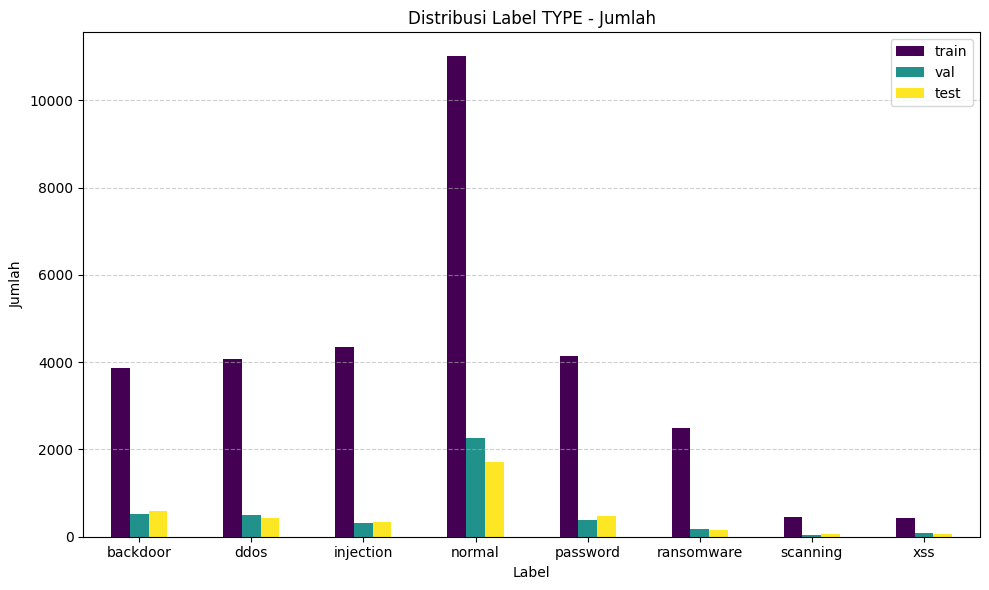

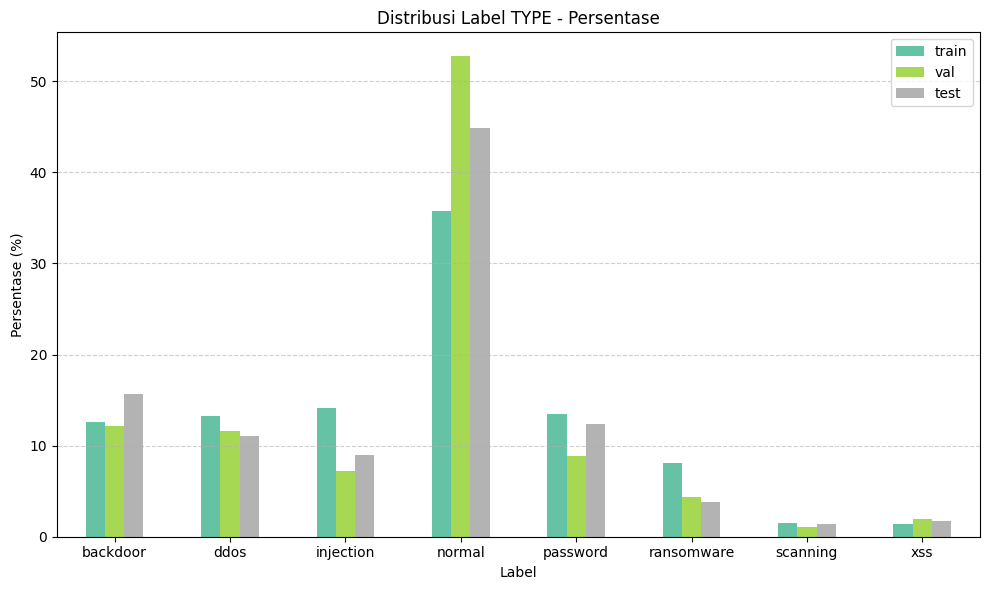


Distribusi Label 'label' (Jumlah):
        train   val  test
label                   
0      11007  2273  1720
1      19813  2038  2109

Distribusi Label 'label' (Persentase):
        train    val   test
label                     
0      35.71  52.73  44.92
1      64.29  47.27  55.08


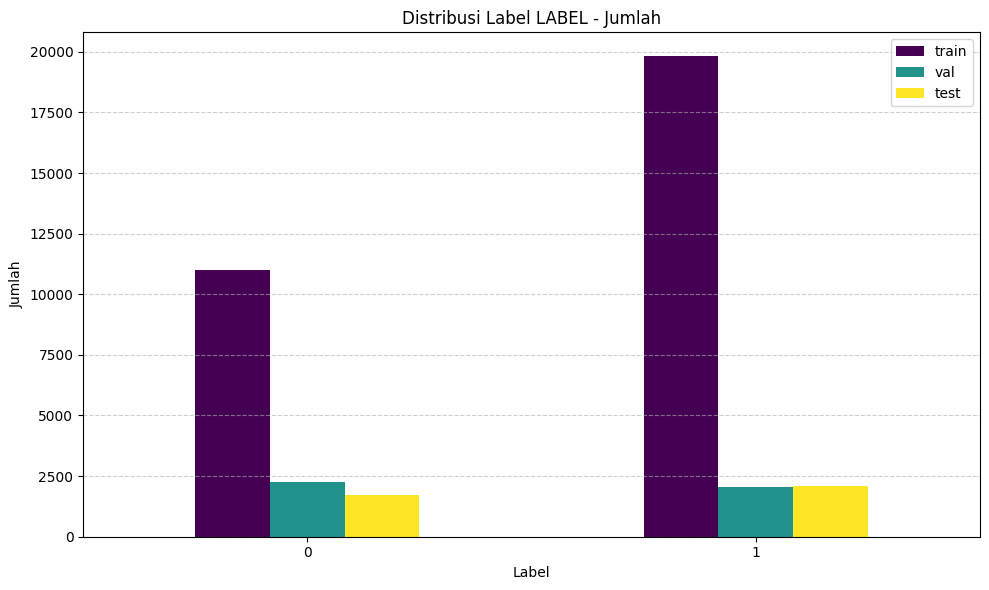

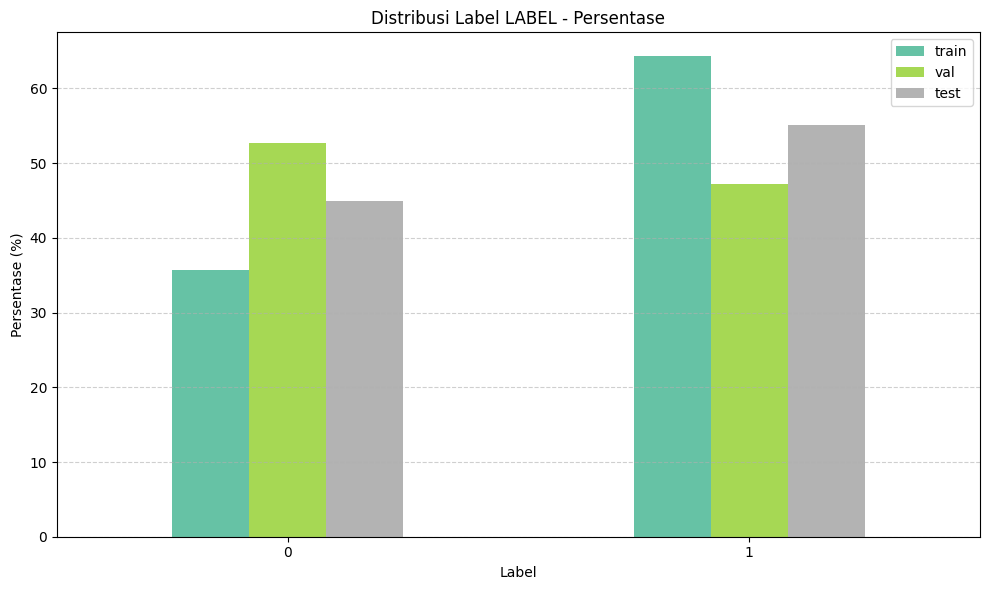


Distribusi Label 'type' (Jumlah):
             train   val  test
type                         
backdoor     3876   525   599
ddos         4074   502   424
injection    4345   312   343
normal      11007  2273  1720
password     4143   383   474
ransomware   2500   186   147
scanning      449    46    55
xss           426    84    67

Distribusi Label 'type' (Persentase):
             train    val   test
type                           
backdoor    12.58  12.18  15.64
ddos        13.22  11.64  11.07
injection   14.10   7.24   8.96
normal      35.71  52.73  44.92
password    13.44   8.88  12.38
ransomware   8.11   4.31   3.84
scanning     1.46   1.07   1.44
xss          1.38   1.95   1.75


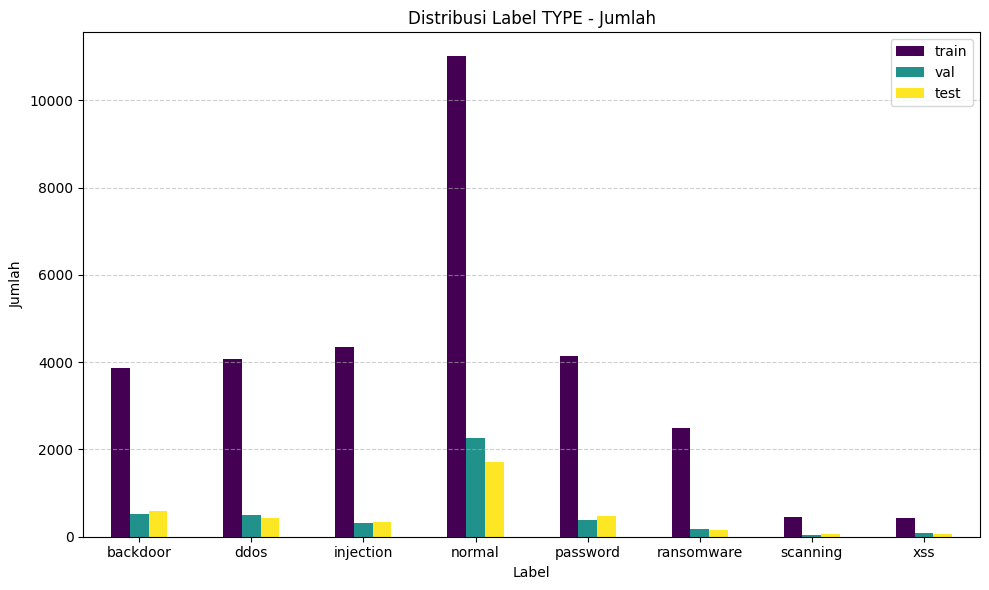

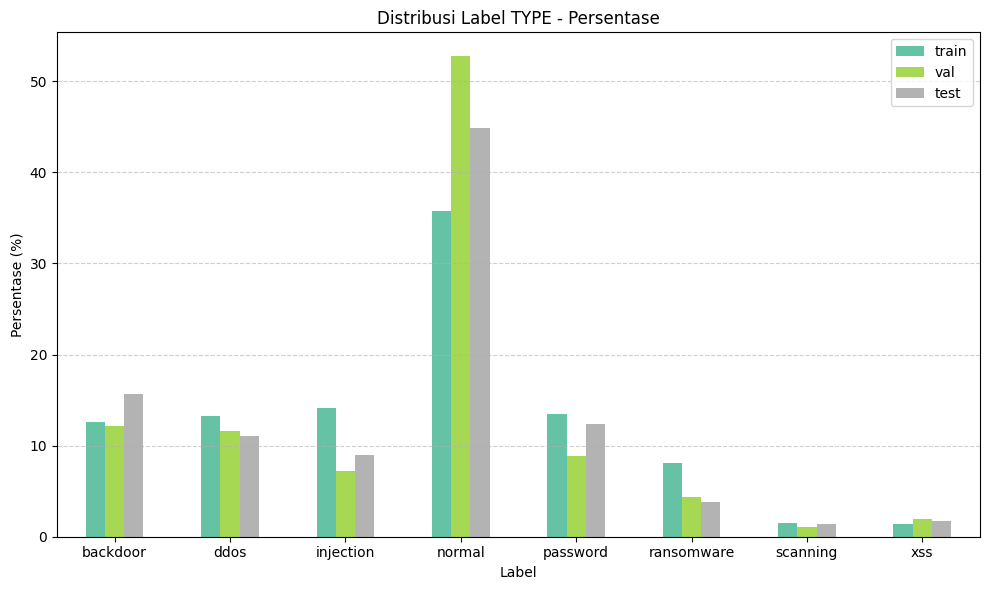


Distribusi Label 'label' (Jumlah):
        train   val  test
label                   
0      11007  2273  1720
1      19813  2038  2109

Distribusi Label 'label' (Persentase):
        train    val   test
label                     
0      35.71  52.73  44.92
1      64.29  47.27  55.08


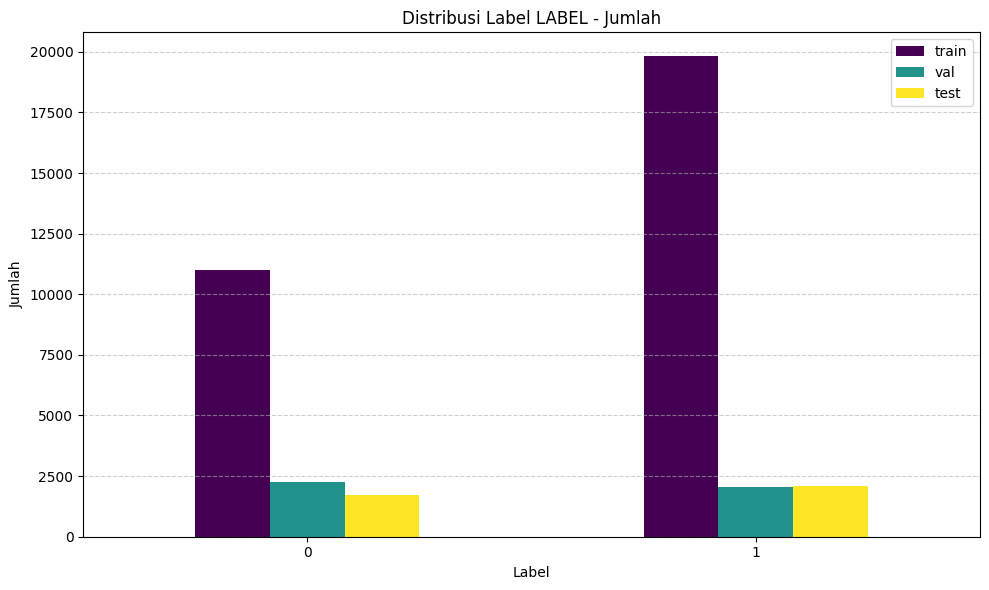

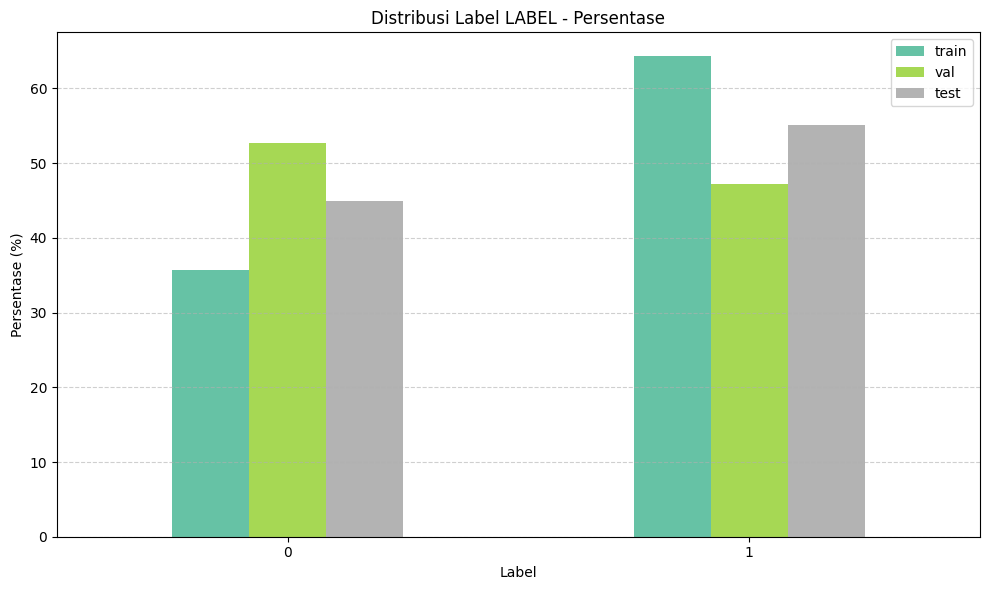

In [13]:
# Distribusi berdasarkan label type (klasifikasi multi-class)
show_label_distribution(y_train_best, y_val_best, y_test_best, label_name='type')

# Distribusi berdasarkan label asli normal/anomaly (binary)
show_label_distribution(z_train_best, z_val_best, z_test_best, label_name='label')

show_label_distribution(y_raw_train_best, y_raw_val_best, y_raw_test_best, label_name='type')

show_label_distribution(z_raw_train_best, z_raw_val_best, z_raw_test_best, label_name='label')

# Data Preprocessing: Imputation & Scaling

📌 Tujuan
Langkah ini bertujuan untuk membersihkan dan menyiapkan data fitur (X) serta label target (y) sebelum dimasukkan ke dalam model machine learning, khususnya model berbasis deep learning seperti LSTM. Tahapan ini mencakup:

- Menangani nilai yang hilang (missing values)

- Normalisasi fitur (scaling)

- Encoding target label

- Menyimpan objek praproses (imputer, scaler, encoder)

---

## 1. Imputasi Nilai Hilang (Missing Values)

Kadang-kadang data yang tersedia memiliki nilai kosong atau hilang. Untuk memastikan model tidak error saat proses pelatihan, kita perlu mengisinya terlebih dahulu.

- Strategi yang digunakan: Median

- Alasan pemilihan median: Median lebih tahan terhadap outlier dibandingkan mean, sehingga cocok  untuk nilai yang kurang biasa.

- Metode: SimpleImputer dari Scikit-Learn
---

## 2. Normalisasi Fitur (Scaling)

Model LSTM dan banyak model ML lainnya sensitif terhadap skala fitur. Oleh karena itu, semua fitur perlu dinormalisasi agar berada dalam rentang yang sama.

- Skala yang digunakan: Min-Max Scaling (rentang [0, 1])

- Tujuan: Menyeimbangkan skala semua fitur agar model lebih cepat konvergen dan akurat

- Metode: MinMaxScaler dari Scikit-Learn

---

## 3. Penyimpanan Objek Preprocessing

Objek seperti imputer dan scaler yang digunakan pada data pelatihan perlu disimpan. Hal ini agar nanti saat inferensi (pengujian/penerapan model), data baru bisa diproses dengan cara yang sama persis seperti saat pelatihan.

Disimpan menggunakan pickle ke file imputer.pkl dan minmax.pkl.

---

## 4. Encoding Target Label

Model deep learning tidak bisa langsung menerima label dalam bentuk string atau kategori. Oleh karena itu, perlu dikonversi:

Langkah 1: Label encoding
Mengubah kelas seperti ['normal', 'ddos', 'xss'] menjadi [0, 1, 2]

Langkah 2: One-hot encoding
Mengubah label numerik tersebut menjadi vektor biner (contoh: label 2 menjadi [0, 0, 1])

Manfaat: One-hot encoding sangat berguna untuk model klasifikasi multi-kelas.

---

## 5. Penyimpanan Label Encoder

Label encoder juga disimpan agar saat inference atau evaluasi model nanti, kita bisa mengubah prediksi numerik model kembali menjadi label aslinya.

Disimpan sebagai label_encoder_target.pkl

---

In [23]:
print(X_train_best.info())

<class 'pandas.core.frame.DataFrame'>
Index: 30820 entries, 11 to 38959
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   latitude                     30820 non-null  float64
 1   longitude                    30820 non-null  float64
 2   is_weekend                   30820 non-null  int32  
 3   hour_sin                     30820 non-null  float64
 4   hour_cos                     30820 non-null  float64
 5   minute_sin                   30820 non-null  float64
 6   minute_cos                   30820 non-null  float64
 7   second_sin                   30820 non-null  float64
 8   second_cos                   30820 non-null  float64
 9   is_business_hour             30820 non-null  int32  
 10  is_night                     30820 non-null  int32  
 11  is_rush_hour                 30820 non-null  int32  
 12  delta_lon                    30820 non-null  float64
 13  bearing             

In [14]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Handle any remaining missing values with SimpleImputer
imputer_raw = SimpleImputer(strategy='median')
X_raw_imputed_train = pd.DataFrame(imputer_raw.fit_transform(X_raw_train_best), columns=X_raw_train_best.columns)
X_raw_imputed_val = pd.DataFrame(imputer_raw.transform(X_raw_val_best), columns=X_raw_val_best.columns)
X_raw_imputed_test = pd.DataFrame(imputer_raw.transform(X_raw_test_best), columns=X_raw_test_best.columns)

print(f"Features shape train after imputation: {X_raw_imputed_train.shape}")
print(f"Features shape val after imputation: {X_raw_imputed_val.shape}")
print(f"Features shape test after imputation: {X_raw_imputed_test.shape}")

# Apply MinMax Scaling
scaler_raw = MinMaxScaler()
X_raw_train_scaled = scaler_raw.fit_transform(X_raw_imputed_train)
X_raw_val_scaled = scaler_raw.transform(X_raw_imputed_val)
X_raw_test_scaled = scaler_raw.transform(X_raw_imputed_test)

print("Data scaling completed!")
print(f"Scaled features train shape: {X_raw_train_scaled.shape}")
print(f"Scaled features val shape: {X_raw_val_scaled.shape}")
print(f"Scaled features test shape: {X_raw_test_scaled.shape}")

# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer_raw.pkl'), 'wb') as f:
    pickle.dump(imputer_raw, f)

with open(os.path.join(artifacts_dir, 'minmax_raw.pkl'), 'wb') as f:
    pickle.dump(scaler_raw, f)

print(f"Imputer saved to {artifacts_dir}/imputer_raw.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax_raw.pkl")

# Encode target labels
le_raw = LabelEncoder()
y_raw_train_encoded = le_raw.fit_transform(y_train_best)
y_raw_val_encoded = le_raw.transform(y_val_best)
y_raw_test_encoded = le_raw.transform(y_test_best)

# One-hot encode
y_raw_train_cat = to_categorical(y_raw_train_encoded)
y_raw_val_cat = to_categorical(y_raw_val_encoded)
y_raw_test_cat = to_categorical(y_raw_test_encoded)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target_raw.pkl'), 'wb') as f:
    pickle.dump(le_raw, f)

print(f"Target classes: {le_raw.classes_}")
print(f"Target train shape: {y_raw_train_encoded.shape}")
print(f"Target val shape: {y_raw_val_encoded.shape}")
print(f"Target test shape: {y_raw_test_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target_raw.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Features shape train after imputation: (30820, 4)
Features shape val after imputation: (4311, 4)
Features shape test after imputation: (3829, 4)
Data scaling completed!
Scaled features train shape: (30820, 4)
Scaled features val shape: (4311, 4)
Scaled features test shape: (3829, 4)
Imputer saved to artifacts/imputer_raw.pkl
Scaler saved to artifacts/minmax_raw.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target train shape: (30820,)
Target val shape: (4311,)
Target test shape: (3829,)
Target label encoder saved to artifacts/label_encoder_target_raw.pkl


In [15]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed_train = pd.DataFrame(imputer.fit_transform(X_train_best), columns=X_train_best.columns)
X_imputed_val = pd.DataFrame(imputer.transform(X_val_best), columns=X_val_best.columns)
X_imputed_test = pd.DataFrame(imputer.transform(X_test_best), columns=X_test_best.columns)

print(f"Features shape train after imputation: {X_imputed_train.shape}")
print(f"Features shape val after imputation: {X_imputed_val.shape}")
print(f"Features shape test after imputation: {X_imputed_test.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_imputed_train)
X_val_scaled = scaler.transform(X_imputed_val)
X_test_scaled = scaler.transform(X_imputed_test)

print("Data scaling completed!")
print(f"Scaled features train shape: {X_train_scaled.shape}")
print(f"Scaled features val shape: {X_val_scaled.shape}")
print(f"Scaled features test shape: {X_test_scaled.shape}")

# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_best)
y_val_encoded = le.transform(y_val_best)
y_test_encoded = le.transform(y_test_best)

# One-hot encode
y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(le, f)

print(f"Target classes: {le.classes_}")
print(f"Target train shape: {y_train_encoded.shape}")
print(f"Target val shape: {y_val_encoded.shape}")
print(f"Target test shape: {y_test_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Features shape train after imputation: (30820, 40)
Features shape val after imputation: (4311, 40)
Features shape test after imputation: (3829, 40)
Data scaling completed!
Scaled features train shape: (30820, 40)
Scaled features val shape: (4311, 40)
Scaled features test shape: (3829, 40)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target train shape: (30820,)
Target val shape: (4311,)
Target test shape: (3829,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [16]:
# =====================================
# Label mapping
# =====================================
attack_classes = le.classes_  # contoh: ['backdoor','ddos',...,'xss']

# =====================================
# 1. Latih model LightGBM
# =====================================
params = {
    'random_state': SEED,
    'n_jobs': -1,
    'force_row_wise': True,
    'max_depth': 5,
    'verbose': -1
}
lgbm = lgb.LGBMClassifier(**params)
lgbm.fit(X_train_scaled, y_train_encoded)

# =====================================
# 2. Hitung SHAP values
# =====================================
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train_scaled)

# Konversi ke numpy array
if isinstance(shap_values, list):
    shap_array = np.array(shap_values)
else:
    shap_array = np.array([shap_values])

print("[DEBUG] Bentuk awal shap_array:", shap_array.shape)

# === FIX untuk kasus 4D (1, N, F, C) ===
if shap_array.ndim == 4:
    print("[INFO] Detected 4D SHAP array, converting...")
    shap_array = shap_array.squeeze(axis=0)          # (N, F, C)
    shap_array = shap_array.transpose(2, 0, 1)       # (C, N, F)
    print("[DEBUG] Bentuk setelah konversi:", shap_array.shape)

elif shap_array.ndim == 3:
    if shap_array.shape[0] != len(attack_classes):
        print("[INFO] Transposing 3D SHAP array...")
        shap_array = shap_array.transpose(2, 0, 1)   # (C, N, F)
        print("[DEBUG] Bentuk setelah transpose:", shap_array.shape)

elif shap_array.ndim == 2:
    print("[INFO] Detected 2D SHAP array, menambahkan dimensi kelas...")
    shap_array = shap_array[np.newaxis, :, :]        # (1, N, F)
    print("[DEBUG] Bentuk baru:", shap_array.shape)

# =====================================
# 3. Hitung rata-rata SHAP per fitur per kelas
# =====================================
mean_shap_per_class = np.mean(np.abs(shap_array), axis=1)  # (n_classes, n_features)
mean_shap_all = np.mean(mean_shap_per_class, axis=0)       # (n_features,)

print("[DEBUG] mean_shap_per_class:", mean_shap_per_class.shape)
print("[DEBUG] mean_shap_all:", mean_shap_all.shape)

# =====================================
# 4. Seleksi fitur berdasarkan threshold
# =====================================
shap_importance_series = pd.Series(mean_shap_all, index=X_all.columns)
shap_importance_sorted = shap_importance_series.sort_values(ascending=False)

threshold = 0.01
selected_features = shap_importance_sorted[shap_importance_sorted >= threshold].index.tolist()

# =====================================
# 5. Tentukan serangan dominan per fitur
# =====================================
results = []
for feat in selected_features:
    feat_idx = X_all.columns.get_loc(feat)
    class_shap_values = mean_shap_per_class[:, feat_idx]
    max_class_idx = np.argmax(class_shap_values)
    results.append({
        'Fitur': feat,
        'SHAP (Avg)': shap_importance_sorted[feat],
        'Jenis Serangan Dominan': attack_classes[max_class_idx],
        'Kontribusi Tertinggi': class_shap_values[max_class_idx]
    })

results_df = pd.DataFrame(results).sort_values(by='SHAP (Avg)', ascending=False)

# =====================================
# 6. Tampilkan hasil di console
# =====================================
print("\n=== Fitur Terpilih Berdasarkan SHAP & Jenis Serangan Dominan ===")
for i, row in results_df.iterrows():
    print(f"{i+1:>2}. {row['Fitur']:<35} | SHAP: {row['SHAP (Avg)']:.6f} "
          f"| Dominan: {row['Jenis Serangan Dominan']} ({row['Kontribusi Tertinggi']:.6f})")

# =====================================
# 7. Filter dataset sesuai fitur terpilih
# =====================================
important_idx = [X_all.columns.get_loc(col) for col in selected_features]
X_train_filtered = pd.DataFrame(X_train_scaled[:, important_idx], columns=selected_features)
X_val_filtered = pd.DataFrame(X_val_scaled[:, important_idx], columns=selected_features)
X_test_filtered = pd.DataFrame(X_test_scaled[:, important_idx], columns=selected_features)

# =====================================
# 8. Visualisasi Heatmap Fitur vs Jenis Serangan
# =====================================
shap_class_df = pd.DataFrame(mean_shap_per_class.T, columns=attack_classes, index=X_all.columns)
shap_class_df_filtered = shap_class_df.loc[selected_features]

plt.figure(figsize=(12, 6))
sns.heatmap(shap_class_df_filtered, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("Kontribusi Fitur Terhadap Setiap Jenis Serangan (SHAP Values)")
plt.ylabel("Fitur")
plt.xlabel("Jenis Serangan")
plt.tight_layout()
plt.show()

[DEBUG] Bentuk awal shap_array: (1, 30820, 40, 8)
[INFO] Detected 4D SHAP array, converting...
[DEBUG] Bentuk setelah konversi: (8, 30820, 40)
[DEBUG] mean_shap_per_class: (8, 40)
[DEBUG] mean_shap_all: (40,)

=== Fitur Terpilih Berdasarkan SHAP & Jenis Serangan Dominan ===
 1. cumulative_distance                 | SHAP: 2.701984 | Dominan: normal (7.957892)
 2. hour_sin                            | SHAP: 0.830545 | Dominan: injection (3.563187)
 3. hour_x_cluster                      | SHAP: 0.344528 | Dominan: ddos (1.885681)
 4. is_night                            | SHAP: 0.266239 | Dominan: ransomware (2.128619)
 5. hour_cos                            | SHAP: 0.129909 | Dominan: scanning (0.740859)
 6. longitude                           | SHAP: 0.089341 | Dominan: ddos (0.661055)
 7. distance_rolling_mean_5             | SHAP: 0.088078 | Dominan: injection (0.270450)
 8. latitude                            | SHAP: 0.054456 | Dominan: normal (0.218929)
 9. distance_m_haversine     

In [18]:
z_raw_train_best = np.array(z_raw_train_best)
z_raw_val_best = np.array(z_raw_val_best)
# Ambil hanya data dengan label 0 (normal)
X_raw_train_ae = X_raw_train_scaled[z_raw_train_best == 0]
X_raw_val_ae = X_raw_val_scaled[z_raw_val_best == 0]

X_raw_train_ae = np.array(X_raw_train_ae)
z_raw_train_ae = z_raw_train_best[z_raw_train_best == 0]

X_raw_val_ae = np.array(X_raw_val_ae)
z_raw_val_ae = z_raw_val_best[z_raw_val_best == 0]

X_raw_test_ae = np.array(X_raw_test_scaled)
z_raw_test_ae = np.array(z_raw_test_best)

print(X_raw_train_ae.shape)
print(z_raw_train_ae.shape)
print(X_raw_val_ae.shape)
print(z_raw_val_ae.shape)
print(X_raw_test_ae.shape)
print(z_raw_test_ae.shape)

(11007, 4)
(11007,)
(2273, 4)
(2273,)
(3829, 4)
(3829,)


In [19]:
z_train_best = np.array(z_train_best)
z_val_best = np.array(z_val_best)
# Ambil hanya data dengan label 0 (normal)
X_train_ae_fe = X_train_scaled[z_train_best == 0]
X_val_ae_fe = X_val_scaled[z_val_best == 0]

X_train_ae_fe = np.array(X_train_ae_fe)
z_train_ae_fe = z_train_best[z_train_best == 0]

X_val_ae_fe = np.array(X_val_ae_fe)
z_val_ae_fe = z_val_best[z_val_best == 0]

X_test_ae_fe = np.array(X_test_scaled)
z_test_ae_fe = np.array(z_test_best)

print(X_train_ae_fe.shape)
print(z_train_ae_fe.shape)
print(X_val_ae_fe.shape)
print(z_val_ae_fe.shape)
print(X_test_ae_fe.shape)
print(z_test_ae_fe.shape)

(11007, 40)
(11007,)
(2273, 40)
(2273,)
(3829, 40)
(3829,)


In [20]:
z_train_best = np.array(z_train_best)
z_val_best = np.array(z_val_best)
# Ambil hanya data dengan label 0 (normal)
X_train_ae = X_train_filtered[z_train_best == 0]
X_val_ae = X_val_filtered[z_val_best == 0]

X_train_ae = np.array(X_train_ae)
z_train_ae = z_train_best[z_train_best == 0]

X_val_ae = np.array(X_val_ae)
z_val_ae = z_val_best[z_val_best == 0]

X_test_ae = np.array(X_test_filtered)
z_test_ae = np.array(z_test_best)

print(X_train_ae.shape)
print(z_train_ae.shape)
print(X_val_ae.shape)
print(z_val_ae.shape)
print(X_test_ae.shape)
print(z_test_ae.shape)

(11007, 11)
(11007,)
(2273, 11)
(2273,)
(3829, 11)
(3829,)


In [19]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_train_filtered.corr()

# Visualize correlation matrix
plt.figure(figsize=(20, 17))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()


CORRELATION ANALYSIS


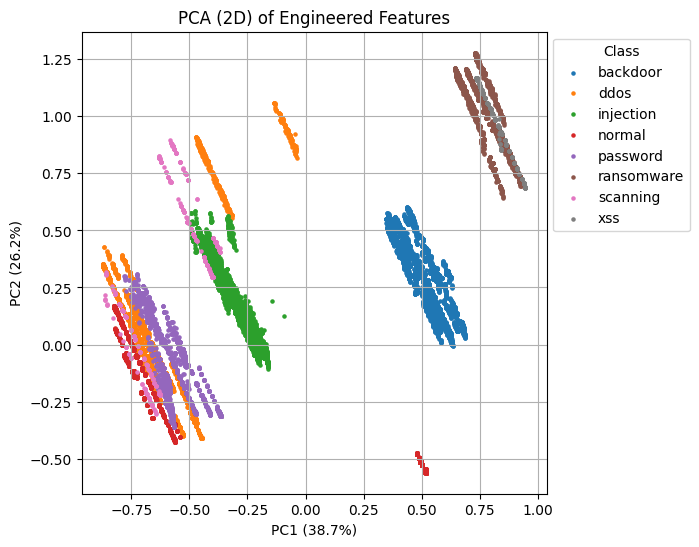

In [ ]:
# PCA 2 Dimensi
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_train_filtered)

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=SEED)
X_tsne = tsne.fit_transform(X_train_filtered)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=SEED)
X_tsne_3d = tsne_3d.fit_transform(X_train_filtered)

# Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y_train_best.astype(str)
})

# Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=SEED)
X_pca_3d = pca.fit_transform(X_train_filtered)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y_train_best

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


## Prepare Data Sequence untuk LSTM
---
**Deskripsi:**
Langkah ini bertujuan untuk mengubah data fitur hasil feature selection menjadi bentuk sekuensial (berurutan) yang sesuai untuk model time-series berbasis LSTM (Long Short-Term Memory). Model LSTM membutuhkan input dalam bentuk urutan data dengan format (samples, time_steps, features).

**Tujuan:**

---

In [24]:
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps - 1])
    return np.array(X_seq), np.array(y_seq)

In [25]:
timesteps = 10
X_raw_train_seq, y_raw_train_seq = create_sequences(X_raw_train_scaled, y_raw_train_cat, timesteps)
X_raw_val_seq, y_raw_val_seq = create_sequences(X_raw_val_scaled, y_raw_val_cat, timesteps)
X_raw_test_seq, y_raw_test_seq = create_sequences(X_raw_test_scaled, y_raw_test_cat, timesteps)

X_raw_train_ae_seq, z_raw_train_ae_seq = create_sequences(X_raw_train_ae, z_raw_train_ae, timesteps)
X_raw_val_ae_seq, z_raw_val_ae_seq = create_sequences(X_raw_val_ae, z_raw_val_ae, timesteps)
X_raw_test_ae_seq, z_raw_test_ae_seq = create_sequences(X_raw_test_ae, z_raw_test_ae, timesteps)

print(X_raw_train_seq.shape)
print(X_raw_val_seq.shape)
print(X_raw_test_seq.shape)
print(X_raw_train_ae_seq.shape)
print(X_raw_val_ae_seq.shape)
print(X_raw_test_ae_seq.shape)

(30811, 10, 4)
(4302, 10, 4)
(3820, 10, 4)
(10998, 10, 4)
(2264, 10, 4)
(3820, 10, 4)


In [26]:
timesteps = 10
X_fe_train_seq, y_fe_train_seq = create_sequences(X_train_scaled, y_train_cat, timesteps)
X_fe_val_seq, y_fe_val_seq = create_sequences(X_val_scaled, y_val_cat, timesteps)
X_fe_test_seq, y_fe_test_seq = create_sequences(X_test_scaled, y_test_cat, timesteps)

X_fe_train_ae_seq, z_fe_train_ae_seq = create_sequences(X_train_ae_fe, z_train_ae_fe, timesteps)
X_fe_val_ae_seq, z_fe_val_ae_seq = create_sequences(X_val_ae_fe, z_val_ae_fe, timesteps)
X_fe_test_ae_seq, z_fe_test_ae_seq = create_sequences(X_test_ae_fe, z_test_ae_fe, timesteps)

print(X_fe_train_seq.shape)
print(X_fe_val_seq.shape)
print(X_fe_test_seq.shape)
print(X_fe_train_ae_seq.shape)
print(X_fe_val_ae_seq.shape)
print(X_fe_test_ae_seq.shape)

(30811, 10, 40)
(4302, 10, 40)
(3820, 10, 40)
(10998, 10, 40)
(2264, 10, 40)
(3820, 10, 40)


In [27]:
# ================================
# PREPARE DATA SEQUENCE
# ================================

print("\n" + "="*50)
print("PREPARING DATA FOR MODEL")
print("="*50)

# Set sequence length
time_steps = 10

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_filtered, y_train_cat, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_filtered, y_val_cat, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_filtered, y_test_cat, time_steps)
X_train_ae_seq, z_train_ae_seq = create_sequences(X_train_ae, z_train_ae, time_steps)
X_val_ae_seq, z_val_ae_seq = create_sequences(X_val_ae, z_val_ae, time_steps)
X_test_ae_seq, z_test_ae_seq = create_sequences(X_test_ae, z_test_ae, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Training label sequences shape: {y_train_seq.shape}")
print(f"\nValidation sequences shape: {X_val_seq.shape}")
print(f"Validation label sequences shape: {y_val_seq.shape}")
print(f"\nTest sequences shape: {X_test_seq.shape}")
print(f"Test label sequences shape: {y_test_seq.shape}")

print(f"\nTraining sequences ae shape: {X_train_ae_seq.shape}")
print(f"Training label sequences ae shape: {z_train_ae_seq.shape}")
print(f"\nValidation sequences ae shape: {X_val_ae_seq.shape}")
print(f"Validation label sequences ae shape: {z_val_ae_seq.shape}")
print(f"\nTest sequences ae shape: {X_test_ae_seq.shape}")
print(f"Test label sequences ae shape: {z_test_ae_seq.shape}")


PREPARING DATA FOR MODEL
Training sequences shape: (30811, 10, 11)
Training label sequences shape: (30811, 8)

Validation sequences shape: (4302, 10, 11)
Validation label sequences shape: (4302, 8)

Test sequences shape: (3820, 10, 11)
Test label sequences shape: (3820, 8)

Training sequences ae shape: (10998, 10, 11)
Training label sequences ae shape: (10998,)

Validation sequences ae shape: (2264, 10, 11)
Validation label sequences ae shape: (2264,)

Test sequences ae shape: (3820, 10, 11)
Test label sequences ae shape: (3820,)


In [28]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_raw_train_sequence.pkl'), 'wb') as f:
    pickle.dump((X_raw_train_seq, y_raw_train_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_raw_val_sequence.pkl'), 'wb') as f:
    pickle.dump((X_raw_val_seq, y_raw_val_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_raw_test_sequence.pkl'), 'wb') as f:
    pickle.dump((X_raw_test_seq, y_raw_test_seq), f)

In [29]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_fe_train_sequence.pkl'), 'wb') as f:
    pickle.dump((X_fe_train_seq, y_fe_train_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_fe_val_sequence.pkl'), 'wb') as f:
    pickle.dump((X_fe_val_seq, y_fe_val_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_fe_test_sequence.pkl'), 'wb') as f:
    pickle.dump((X_fe_test_seq, y_fe_test_seq), f)

In [30]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_train_sequence.pkl'), 'wb') as f:
    pickle.dump((X_train_seq, y_train_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_val_sequence.pkl'), 'wb') as f:
    pickle.dump((X_val_seq, y_val_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_test_sequence.pkl'), 'wb') as f:
    pickle.dump((X_test_seq, y_test_seq), f)

In [31]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_raw_train_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_raw_train_ae_seq, z_raw_train_ae_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_raw_val_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_raw_val_ae_seq, z_raw_val_ae_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_raw_test_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_raw_test_ae_seq, z_raw_test_ae_seq), f)

In [32]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_fe_train_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_fe_train_ae_seq, z_fe_train_ae_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_fe_val_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_fe_val_ae_seq, z_fe_val_ae_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_fe_test_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_fe_test_ae_seq, z_fe_test_ae_seq), f)

In [33]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_train_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_train_ae_seq, z_train_ae_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_val_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_val_ae_seq, z_val_ae_seq), f)
    
with open(os.path.join(artifacts_dir, 'data_test_sequence_ae.pkl'), 'wb') as f:
    pickle.dump((X_test_ae_seq, z_test_ae_seq), f)

In [5]:
# Load Dataset raw
with open(os.path.join(artifacts_dir, 'data_raw_train_sequence.pkl'), 'rb') as f:
    X_raw_train_seq, y_raw_train_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_raw_val_sequence.pkl'), 'rb') as f:
    X_raw_val_seq, y_raw_val_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_raw_test_sequence.pkl'), 'rb') as f:
    X_raw_test_seq, y_raw_test_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_raw_train_sequence_ae.pkl'), 'rb') as f:
    X_raw_train_ae_seq, z_raw_train_ae_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_raw_val_sequence_ae.pkl'), 'rb') as f:
    X_raw_val_ae_seq, z_raw_val_ae_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_raw_test_sequence_ae.pkl'), 'rb') as f:
    X_raw_test_ae_seq, z_raw_test_ae_seq = pickle.load(f)

In [6]:
# Load Dataset fe
with open(os.path.join(artifacts_dir, 'data_fe_train_sequence.pkl'), 'rb') as f:
    X_fe_train_seq, y_fe_train_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_fe_val_sequence.pkl'), 'rb') as f:
    X_fe_val_seq, y_fe_val_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_fe_test_sequence.pkl'), 'rb') as f:
    X_fe_test_seq, y_fe_test_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_fe_train_sequence_ae.pkl'), 'rb') as f:
    X_fe_train_ae_seq, z_fe_train_ae_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_fe_val_sequence_ae.pkl'), 'rb') as f:
    X_fe_val_ae_seq, z_fe_val_ae_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_fe_test_sequence_ae.pkl'), 'rb') as f:
    X_fe_test_ae_seq, z_fe_test_ae_seq = pickle.load(f)

In [7]:
# Load Dataset seleksi fitur
with open(os.path.join(artifacts_dir, 'data_train_sequence.pkl'), 'rb') as f:
    X_train_seq, y_train_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_val_sequence.pkl'), 'rb') as f:
    X_val_seq, y_val_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_test_sequence.pkl'), 'rb') as f:
    X_test_seq, y_test_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_train_sequence_ae.pkl'), 'rb') as f:
    X_train_ae_seq, z_train_ae_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_val_sequence_ae.pkl'), 'rb') as f:
    X_val_ae_seq, z_val_ae_seq = pickle.load(f)
    
with open(os.path.join(artifacts_dir, 'data_test_sequence_ae.pkl'), 'rb') as f:
    X_test_ae_seq, z_test_ae_seq = pickle.load(f)

In [8]:
# ================================
# MELIHAT KELAS MINORITAS
# ================================
from typing import Counter
train_labels = np.argmax(y_fe_train_seq, axis=1)
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())
minority_classes = [cls for cls, count in class_counts.items() if count / total_samples < 0.1]
print("Minority classes:", minority_classes)

Minority classes: [6, 7, 5]


In [9]:
# ========================================================
# === CLASS WEIGHT OTOMATIS BERDASARKAN DISTRIBUSI TYPE===
# ========================================================
y_train_labels = np.argmax(y_train_seq, axis=1)
y_val_labels = np.argmax(y_val_seq, axis=1)
classes=np.unique(y_train_labels)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels)
class_weight = {i: w for i, w in enumerate(class_weight_values)}
base_class_weight = dict(zip(classes, class_weight_values))
print("Class weights:", class_weight)

Class weights: {0: 0.9936468008255934, 1: 0.9453546882670594, 2: 0.8863924050632911, 3: 0.35018867066739406, 4: 0.9296101858556601, 5: 1.54055, 6: 8.577672605790646, 7: 9.040786384976526}


In [10]:
def load_and_display_trials(log_file: str, score_key: str = "score"):
    import os, json

    if not os.path.exists(log_file):
        raise FileNotFoundError(f"Tidak ada file hasil tuning: {log_file}")

    # Load semua trial dari JSON
    with open(log_file, "r") as f:
        data = json.load(f)

    if len(data) == 0:
        raise ValueError("File JSON kosong.")

    # Mode khusus hp_tuning dan dinamic_cb
    if score_key == "hp_tuning":
        sort_key = "score"
        use_trial_id = True
    elif score_key == "dinamic_cb":
        sort_key = "composite_score"
        use_trial_id = False
    else:
        sort_key = score_key
        use_trial_id = True  # default: kalau ada trial_id, tampilkan

    # Pastikan key ada
    if not all(sort_key in trial for trial in data):
        raise KeyError(f"Tidak ada key '{sort_key}' dalam file JSON.")

    # Urutkan berdasarkan key yang dipilih
    sorted_trials = sorted(data, key=lambda x: x[sort_key], reverse=True)

    # Tampilkan semua hasil trial
    print(f"=== Hasil Semua Trial (Urut Berdasarkan {sort_key}) ===")
    for i, trial in enumerate(sorted_trials, 1):
        if use_trial_id and "trial_id" in trial:
            trial_name = f"Trial {trial['trial_id']}"
        else:
            trial_name = f"Trial {i}"  # fallback pakai urutan saja

        print(f"{trial_name} — ", end="")
        # tampilkan semua metric numerik
        for k, v in trial.items():
            if isinstance(v, (int, float)):
                print(f"{k}: {v:.4f} | ", end="")
        print()

    # Tampilkan trial terbaik
    best_trial = sorted_trials[0]
    print("\n=== Trial Terbaik ===")
    if use_trial_id and "trial_id" in best_trial:
        print(f"Trial {best_trial['trial_id']}")
    else:
        print("Trial 1 (berdasarkan urutan sorting)")

    print("Hyperparameters:")
    if "hyperparameters" in best_trial:
        for k, v in best_trial["hyperparameters"].items():
            print(f"  {k}: {v}")
    else:
        print("  [Tidak ada hyperparameters disimpan dalam JSON]")

    # Cetak ulang metrik terbaik
    for k, v in best_trial.items():
        if isinstance(v, (int, float)):
            print(f"{k}: {v:.4f}")


In [11]:

def evaluate_classifier_model(model, X_test_seq, y_test_seq, file_prefix=""):
    # --- Prediksi ---
    y_pred = model.predict(X_test_seq)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test_seq, axis=1)

    # --- Classification Report, Balanced Accuracy, Cohen's Kappa ---
    print(classification_report(y_true_labels, y_pred_labels))
    print("Balanced Accuracy:", balanced_accuracy_score(y_true_labels, y_pred_labels))
    print("Cohen's Kappa Score:", cohen_kappa_score(y_true_labels, y_pred_labels))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(viz_dir, f"{file_prefix}_confusion_matrix.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # --- ROC Curve ---
    n_classes = y_pred.shape[1]
    y_true_bin = label_binarize(y_true_labels, classes=range(n_classes))

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap("Set1", n_classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})',
                 color=colors(i))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, f"{file_prefix}_roc_curve.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --- Precision-Recall Curve ---
    precision, recall, average_precision = {}, {}, {}
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap("tab10", n_classes)

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2,
                 label=f"Class {i} (AP = {average_precision[i]:.2f})",
                 color=colors(i))

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (PRC) per Class")
    plt.legend(loc="lower left")
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, f"{file_prefix}_pr_curve.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"Evaluasi model selesai. Visualisasi disimpan di folder: {viz_dir}")

In [12]:
class ClassifierHyperModel:
    def __init__(self, sequence_length, n_features, n_classes):
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.n_classes = n_classes

    def build(self, params):
        inputs = Input(shape=(self.sequence_length, self.n_features))
        x = SpatialDropout1D(params['spatial_dropout'])(inputs)

        # LSTM layer 1
        bi1 = Bidirectional(LSTM(
            params['lstm_units_1'],
            return_sequences=True,
            dropout=params['lstm_dropout_1'],
        ))(x)

        # LSTM layer 2
        if params.get("use_second_lstm", False):
            bi2 = Bidirectional(LSTM(
                params['lstm_units_2'],
                return_sequences=True,
                dropout=params['lstm_dropout_2'],
            ))(bi1)
            lstm_out = bi2
        else:
            lstm_out = bi1
        lstm_out = LayerNormalization()(lstm_out)

        # Multi-head Attention
        attn = MultiHeadAttention(
            num_heads=params['attention_heads'],
            key_dim=params['attention_dim'],
            dropout=params['attention_dropout']
        )(lstm_out, lstm_out)
        attn = Add()([lstm_out, attn])
        attn = LayerNormalization()(attn)
        attn = Dropout(params['post_attention_dropout'])(attn)

        pooled = GlobalAveragePooling1D()(attn)

        # Dense layers
        dense = Dense(params['dense_units_1'], activation='relu')(pooled)
        dense = BatchNormalization()(dense)
        dense = Dropout(params['dense_dropout_1'])(dense)

        dense = Dense(params['dense_units_2'], activation='relu')(dense)
        dense = Dropout(params['dense_dropout_2'])(dense)

        outputs = Dense(self.n_classes, activation='softmax')(dense)

        model = Model(inputs=inputs, outputs=outputs)
        optimizer = Adam(learning_rate=params['learning_rate'])
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )
        return model

In [13]:
search_space = {
    "spatial_dropout": hp.uniform("spatial_dropout", 0.0, 0.5),
    "lstm_units_1": hp.quniform("lstm_units_1", 16, 200, 8),
    "lstm_dropout_1": hp.uniform("lstm_dropout_1", 0.1, 0.5),
    "use_second_lstm": hp.choice("use_second_lstm", [True, False]),
    "lstm_units_2": hp.quniform("lstm_units_2", 16, 128, 8),
    "lstm_dropout_2": hp.uniform("lstm_dropout_2", 0.1, 0.5),
    "attention_heads": hp.quniform("attention_heads", 2, 8, 1),
    "attention_dim": hp.quniform("attention_dim", 8, 32, 8),
    "attention_dropout": hp.uniform("attention_dropout", 0.1, 0.5),
    "post_attention_dropout": hp.uniform("post_attention_dropout", 0.1, 0.5),
    "dense_units_1": hp.quniform("dense_units_1", 16, 128, 8),
    "dense_dropout_1": hp.uniform("dense_dropout_1", 0.1, 0.5),
    "dense_units_2": hp.quniform("dense_units_2", 16, 96, 8),
    "dense_dropout_2": hp.uniform("dense_dropout_2", 0.1, 0.5),
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-4), np.log(1e-3)),
    "class_weight_scale": hp.uniform("class_weight_scale", 0.5, 2.0)
}

In [14]:
search_space_anomaly = {
    # Encoder
    "encoder_units": hp.quniform("encoder_units", 32, 200, 8),
    "encoder_dropout": hp.uniform("encoder_dropout", 0.0, 0.5),

    # Latent space
    "latent_dim": hp.quniform("latent_dim", 8, 96, 8),

    # Decoder
    "decoder_units": hp.quniform("decoder_units", 32, 200, 8),
    "decoder_dropout": hp.uniform("decoder_dropout", 0.0, 0.5),

    # Attention
    "attention_heads": hp.quniform("attention_heads", 2, 8, 1),
    "attention_dim": hp.quniform("attention_dim", 8, 32, 8),
    "attention_dropout": hp.uniform("attention_dropout", 0.0, 0.5),

    # Optimizer
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-5), np.log(1e-2)),
}

In [ ]:
class HyperoptBayesianOptimizer:
    def __init__(self, search_space=None, max_evals=20):
        self.search_space = search_space or {}
        self.max_evals = max_evals
        self.trials = Trials()

    def set_search_space(self, search_space):           
        self.search_space = search_space
        self.trials = Trials()
    
    def suggest(self, n_candidates=3):
        if not self.search_space:                      
            raise ValueError("Search space belum di-set!")
        
        candidates = []

        # Dummy objective: hanya untuk membangun TPE distribusi
        def dummy_objective(params):
            return 0.0

        # Jalankan fmin untuk membangun distribusi TPE
        fmin(
            fn=dummy_objective,
            space=self.search_space,
            algo=tpe.suggest,
            max_evals=self.max_evals,
            trials=self.trials,
            show_progressbar=False
        )

        # Ambil n_candidates terakhir dari trials
        for i in range(-n_candidates, 0):
            trial = self.trials.trials[i]

            # Ambil vals, convert list -> scalar
            vals_raw = trial["misc"]["vals"]
            vals = {k: (v[0] if isinstance(v, list) and len(v) > 0 else v)
                    for k, v in vals_raw.items()}

            # Konversi index ke nilai real
            params_real = space_eval(self.search_space, vals)

            # Kalau hasilnya float padahal dari quniform (integer), konversi ke int
            for k in params_real:
                if isinstance(params_real[k], float) and k in vals_raw:
                    if isinstance(vals_raw[k], list) and len(vals_raw[k]) > 0:
                        if float(vals_raw[k][0]).is_integer():
                            params_real[k] = int(params_real[k])

            candidates.append(params_real)

        return candidates

In [16]:
# ===== Evaluator Strategy =====
class EvaluatorBase:
    def evaluate(self, hypermodel, params, X_train, y_train, X_val, y_val, epochs, batch_size, verbose):
        """Return: score, metrics_dict, model, history_dict"""
        raise NotImplementedError

# ===== Supervised Evaluator =====
class SupervisedEvaluator(EvaluatorBase):
    def __init__(self, base_class_weight=None, save_best_model_path=None):
        self.base_class_weight = dict(base_class_weight) if base_class_weight else {}
        self.save_best_model_path = save_best_model_path

    def _unwrap_literal(self, v):
        try:
            return v.obj if hasattr(v, "obj") else v
        except Exception:
            return v

    def _pretty_dict(self, d, precision=6, indent=""):
        parts = []
        for k, v in d.items():
            v = self._unwrap_literal(v)
            if isinstance(v, float):
                parts.append(f"{indent}{k}={v:.{precision}f}")
            else:
                parts.append(f"{indent}{k}={v}")
        return "\n".join(parts)

    def evaluate(self, hypermodel, params, X_train, y_train, X_val, y_val, epochs, batch_size, verbose):
        # pastikan semua primitive
        clean_params = {k: self._unwrap_literal(v) for k, v in params.items()}

        print("\n[EVALUATE] Params:\n" + self._pretty_dict(clean_params, indent="  "))
        model = hypermodel.build(clean_params)

        # class weight scaling
        scale = float(clean_params.get("class_weight_scale", 1.0))
        class_weight_dict = {int(k): float(v * scale) for k, v in self.base_class_weight.items()} if self.base_class_weight else None

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)
        ]

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=verbose
        )

        print("[EVALUATE] Predicting on validation set")
        y_pred_proba = model.predict(X_val, verbose=1)

        # metrics
        try:
            y_pred_labels = np.argmax(y_pred_proba, axis=1)
            y_true_labels = np.argmax(y_val, axis=1)
            f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
            bal_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
        except Exception:
            f1_macro, bal_acc = 0.0, 0.0

        try:
            auc_ovr = roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='macro')
        except Exception:
            auc_ovr = 0.5

        score = 0.4 * f1_macro + 0.3 * bal_acc + 0.3 * auc_ovr
        metrics = {"f1_macro": f1_macro, "balanced_accuracy": bal_acc, "roc_auc": auc_ovr}
        return score, metrics, model, history.history

# ===== Unsupervised Evaluator =====
class UnsupervisedEvaluator(EvaluatorBase):
    def __init__(self, score_weights=None, save_best_model_path=None):
        """
        score_weights: dict bobot untuk {mse, mae, latent}
        """
        self.score_weights = score_weights or {"mse": 0.4, "mae": 0.3, "latent": 0.3}
        self.save_best_model_path = save_best_model_path

    def _unwrap_literal(self, v):
        try:
            return v.obj if hasattr(v, "obj") else v
        except Exception:
            return v

    def _pretty_dict(self, d, precision=6, indent=""):
        parts = []
        for k, v in d.items():
            v = self._unwrap_literal(v)
            if isinstance(v, float):
                parts.append(f"{indent}{k}={v:.{precision}f}")
            else:
                parts.append(f"{indent}{k}")
        return "\n".join(parts)

    def _robust_threshold(self, errors, q=0.95, k=1.5):
        """Robust-Quantile Thresholding"""
        q_val = np.quantile(errors, q)
        mad = np.median(np.abs(errors - np.median(errors)))
        return q_val + k * mad

    def evaluate(self, hypermodel, params, X_train, _, X_val, __, epochs, batch_size, verbose):
        # pastikan semua primitive
        clean_params = {k: self._unwrap_literal(v) for k, v in params.items()}

        print("\n[EVALUATE-UNSUPERVISED] Params:\n" + self._pretty_dict(clean_params, indent="  "))
        model = hypermodel.build(clean_params)

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)
        ]

        # dummy target untuk latent_output
        history = model.fit(
            X_train, [X_train, np.zeros((len(X_train), model.output[1].shape[-1]))],
            validation_data=(X_val, [X_val, np.zeros((len(X_val), model.output[1].shape[-1]))]),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )

        print("[EVALUATE-UNSUPERVISED] Predicting on validation set")
        recon_val, latent_val = model.predict(X_val, verbose=0)

        # === 1. Reconstruction Errors ===
        mse_val = mean_squared_error(X_val.reshape(len(X_val), -1),
                                     recon_val.reshape(len(recon_val), -1))
        mae_val = mean_absolute_error(X_val.reshape(len(X_val), -1),
                                      recon_val.reshape(len(recon_val), -1))

        # === 2. Latent Distance ===
        recon_train, latent_train = model.predict(X_train, verbose=0)
        centroid = np.mean(latent_train, axis=0, keepdims=True)
        latent_dist = np.mean(cdist(latent_val, centroid, metric="euclidean"))

        # === 3. Robust Thresholding (sekedar logging) ===
        recon_errors = np.mean(np.square(X_val - recon_val), axis=(1, 2))
        th_mse = self._robust_threshold(recon_errors, q=0.95)
        th_latent = self._robust_threshold(cdist(latent_val, centroid, metric="euclidean"), q=0.95)

        print(f"[EVALUATE-UNSUPERVISED] MSE={mse_val:.6f} | MAE={mae_val:.6f} | LatentDist={latent_dist:.6f}")
        print(f"[EVALUATE-UNSUPERVISED] Threshold MSE={th_mse:.6f} | Threshold Latent={th_latent:.6f}")

        # === 4. Agregasi Score untuk tuner (dibatasi 0–100) ===
        raw_score = (
            self.score_weights["mse"] * (1.0 / (1e-8 + mse_val)) +
            self.score_weights["mae"] * (1.0 / (1e-8 + mae_val)) +
            self.score_weights["latent"] * (1.0 / (1e-8 + latent_dist))
        )
        score = 100 * (raw_score / (1.0 + raw_score))  # mapping ke [0, 100]

        metrics = {
            "mse": float(mse_val),
            "mae": float(mae_val),
            "latent_distance": float(latent_dist),
            "threshold_mse": float(th_mse),
            "threshold_latent": float(th_latent)
        }

        return score, metrics, model, history.history

# ===== Tuner =====
class AdaptiveBayesianHillClimbingTuner:
    def __init__(
        self,
        hypermodel,
        search_space: dict,
        bayesian_optimizer,
        evaluator: EvaluatorBase,
        pool_size: int,
        max_iters: int,
        max_local_steps: int,
        log_file: str = "tuner_log.json",
        initial_step_size: float = 0.15,
        stagnation_threshold: int = 3,
        step_size_min: float = 1e-3,
        step_size_max: float = 1.0,
        step_size_growth: float = 1.10,
        step_size_decay: float = 0.90,
        step_gate_min: float = 0.02,
        force_at_least_one_mutation: bool = True,
        save_best_model_path: str | None = None,
    ):
        self.hypermodel = hypermodel
        self.search_space = dict(search_space)
        self.bayesian_optimizer = bayesian_optimizer
        self.evaluator = evaluator

        self.pool_size = int(pool_size)
        self.max_iters = int(max_iters)
        self.max_local_steps = int(max_local_steps)
        self.log_file = log_file or "tuner_log.json"
        self.save_best_model_path = save_best_model_path

        # adaptive step-size (global)
        self.step_size = float(initial_step_size)
        self.step_size_min = float(step_size_min)
        self.step_size_max = float(step_size_max)
        self.step_size_growth = float(step_size_growth)
        self.step_size_decay = float(step_size_decay)
        self.step_gate_min = float(step_gate_min)  # kalau step < gate, boleh 0 mutasi
        self.force_at_least_one_mutation = bool(force_at_least_one_mutation)

        # state
        self.best_pool = []
        self._available_pool_params = deque()
        self._used_pool_hashes = set()
        self.best_model = None
        self.best_params = None
        self.best_score = -np.inf
        self.best_history = None
        self.stagnation_threshold = int(stagnation_threshold)
        self.stagnation_counter = 0

        # log file
        log_dir = os.path.dirname(self.log_file)
        if log_dir and not os.path.exists(log_dir):
            os.makedirs(log_dir, exist_ok=True)
        if not os.path.exists(self.log_file):
            with open(self.log_file, "w") as f:
                json.dump([], f, indent=2)

    # ---------- utils ----------
    def _unwrap_literal(self, v):
        try:
            return v.obj if hasattr(v, "obj") else v
        except Exception:
            return v

    def _pretty_dict(self, d, precision=6, indent=""):
        parts = []
        for k, v in d.items():
            v = self._unwrap_literal(v)
            if isinstance(v, float):
                parts.append(f"{indent}{k}={v:.{precision}f}")
            else:
                parts.append(f"{indent}{k}={v}")
        return "\n".join(parts)

    def _make_serializable(self, obj):
        if isinstance(obj, (np.integer, )):
            return int(obj)
        if isinstance(obj, (np.floating, )):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, dict):
            return {str(k): self._make_serializable(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [self._make_serializable(v) for v in obj]
        return obj

    def _save_iteration(self, iter_idx, local_step, params, score, metrics, tag="local"):
        try:
            with open(self.log_file, "r") as f:
                data = json.load(f)
        except Exception:
            data = []
        data.append({
            "iter": int(iter_idx),
            "local_step": int(local_step),
            "tag": str(tag),
            "params": self._make_serializable(params),
            "score": float(score),
            "metrics": self._make_serializable(metrics),
            "step_size": float(self.step_size)
        })
        with open(self.log_file, "w") as f:
            json.dump(data, f, indent=2)

    def _update_best(self, params, score, metrics, model=None, history=None):
        if score > self.best_score:
            print(f"[BEST UPDATED] score {self.best_score:.6f} -> {score:.6f}")
            self.best_score = score
            self.best_params = copy.deepcopy(params)
            if model is not None:
                self.best_model = model
            if history is not None:
                self.best_history = history
            if self.save_best_model_path and model is not None:
                try:
                    model.save(self.save_best_model_path, include_optimizer=False)
                    print(f"[INFO] Best model saved to {self.save_best_model_path}")
                except Exception as e:
                    print(f"[WARN] Could not save best model: {e}")

    def _extract_range(self, search_def):
        low, high, step, choices = None, None, None, None
        if search_def is None:
            return low, high, step, choices

        # --- Case: keras-tuner object ---
        if hasattr(search_def, "name"):
            nm = search_def.name or ""
            if nm == "switch":  # categorical
                if hasattr(search_def, "pos_args") and len(search_def.pos_args) >= 2:
                    choices = [self._unwrap_literal(c) for c in search_def.pos_args[1:]]
            elif "uniform" in nm and "quniform" not in nm:  # float uniform
                if hasattr(search_def, "pos_args") and len(search_def.pos_args) >= 2:
                    low, high = float(search_def.pos_args[0]), float(search_def.pos_args[1])
            elif "quniform" in nm:  # int step
                if hasattr(search_def, "pos_args") and len(search_def.pos_args) >= 3:
                    low = int(search_def.pos_args[0])
                    high = int(search_def.pos_args[1])
                    step = int(search_def.pos_args[2])

        # --- Case: dict search_space ---
        elif isinstance(search_def, dict):
            t = search_def.get("type")
            if t == "int":
                low, high = search_def.get("low"), search_def.get("high")
                step = search_def.get("step", 1)
            elif t == "float":
                low, high = search_def.get("low"), search_def.get("high")
            elif t == "loguniform":
            # kasih info range, mutasi learning_rate sudah handle sendiri
                low, high = search_def.get("low"), search_def.get("high")
            elif t == "choice":
                choices = search_def.get("choices", [])
        return low, high, step, choices

    # ---------- mutation ----------
    def mutate(self, params):
        # params primitive
        base = {k: self._unwrap_literal(v) for k, v in params.items()}
        print("\n[MUTATE] Base params:\n" + self._pretty_dict(base, indent="  "))

        keys = list(base.keys())
        # kontrol jumlah parameter yang dimutasi oleh step_size
        # clamp step_size [0,1], lalu jumlah mutasi = round(N * step_size)
        s = float(np.clip(self.step_size, 0.0, 1.0))
        # boleh 0 jika step sangat kecil (< gate)
        allow_zero = s < self.step_gate_min and not self.force_at_least_one_mutation
        num_to_mutate = int(round(len(keys) * s))
        if not allow_zero and num_to_mutate == 0:
            num_to_mutate = 1  # force minimal 1 mutasi agar tidak macet total

        # pilih subset parameter untuk dimutasi (acakan)
        mutate_set = set(np.random.choice(keys, size=num_to_mutate, replace=False)) if num_to_mutate > 0 else set()

        new_params = copy.deepcopy(base)

        for k in keys:
            v = base[k]
            search_def = self.search_space.get(k, None)
            low, high, step, choices = self._extract_range(search_def)

            do_mutate = (k in mutate_set)

            # categorical / bool
            if choices is not None:
                # peluang berubah meningkat bersama step_size
                p_change = min(0.5 + 0.5 * s, 0.95)
                if do_mutate and np.random.rand() < p_change:
                    cand = random.choice(choices)
                    print(f"[MUTATE][CHOICE] {k}: {v} -> {cand} choices={choices}")
                    new_params[k] = cand
                else:
                    print(f"[MUTATE][CHOICE] {k}: keep {v} choices={choices}")
                    new_params[k] = v

            # learning_rate (log-scale)
            elif k == "learning_rate":
                if do_mutate:
                    factor = float(np.exp(np.random.uniform(-s, s)))  # skala ikut step size
                    new_val = float(np.clip(v * factor, 1e-8, 1.0))
                    if new_val != v:
                        print(f"[MUTATE][LR] {k}: {v:.6g} * {factor:.4f} -> {new_val:.6g}")
                    else:
                        print(f"[MUTATE][LR] {k}: keep {v:.6g}")
                    new_params[k] = new_val
                else:
                    print(f"[MUTATE][LR] {k}: keep {v:.6g}")
                    new_params[k] = v

            # continuous (uniform / loguniform value domain dipakai linear di sini)
            elif low is not None and high is not None and step is None:
                if do_mutate:
                    span = high - low
                    perturb = float(np.random.uniform(-span * s, span * s))
                    new_val = float(np.clip(v + perturb, low, high))
                    if new_val != v:
                        print(f"[MUTATE][UNIFORM] {k}: {v:.6f} + {perturb:.6f} -> {new_val:.6f} range=({low},{high})")
                    else:
                        print(f"[MUTATE][UNIFORM] {k}: keep {v:.6f} range=({low},{high})")
                    new_params[k] = new_val
                else:
                    print(f"[MUTATE][UNIFORM] {k}: keep {v:.6f} range=({low},{high})")
                    new_params[k] = v

            # integer (quniform)
            elif low is not None and high is not None and step is not None:
                if do_mutate:
                    span = (high - low)
                    # kira-kira banyak langkah yang boleh bergerak proporsional step_size
                    max_steps = max(1, int(round((span / step) * s)))
                    delta_steps = np.random.randint(-max_steps, max_steps + 1)
                    cand = int(np.clip(v + delta_steps * step, low, high))
                    # snap ke grid
                    cand = int(round(cand / step) * step)
                    if cand != v:
                        print(f"[MUTATE][QUNIFORM] {k}: {v} + {delta_steps}*{step} -> {cand} range=({low},{high}, step={step})")
                    else:
                        print(f"[MUTATE][QUNIFORM] {k}: keep {v} range=({low},{high}, step={step})")
                    new_params[k] = cand
                else:
                    print(f"[MUTATE][QUNIFORM] {k}: keep {v} range=({low},{high}, step={step})")
                    new_params[k] = v

            else:
                print(f"[MUTATE][SKIP] {k}: keep {v} (no search_def)")
                new_params[k] = v

        print("[Mutate] Finished mutation.")
        return new_params

    # ---------- core run ----------
    def run(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=64, verbose=1):
        print("[RUN] Starting Adaptive Bayesian Hill-Climbing Tuning")

        # 1) kandidat awal dari Bayesian
        initial_candidates = self.bayesian_optimizer.suggest(n_candidates=self.pool_size)
        if not initial_candidates:
            raise RuntimeError("Bayesian optimizer returned no initial candidates")
        print(f"[RUN] Initial candidates ({len(initial_candidates)}) received from Bayesian optimizer.")

        self.best_pool, self._available_pool_params, self._used_pool_hashes = [], deque(), set()

        # 2) evaluasi semua kandidat & isi pool
        for i, cand in enumerate(initial_candidates, 1):
            cand = {k: self._unwrap_literal(v) for k, v in cand.items()}
            score, metrics, model, history = self.evaluator.evaluate(
                self.hypermodel, cand, X_train, y_train, X_val, y_val, epochs, batch_size, verbose
            )
            self.best_pool.append({"params": copy.deepcopy(cand), "score": float(score), "metrics": metrics})
            self._available_pool_params.append(copy.deepcopy(cand))
            print(f"\n[INIT] Candidate {i}/{len(initial_candidates)}")
            print(self._pretty_dict(cand, indent="  "))
            print(f"   → score={score:.6f} | F1={metrics.get('f1_macro',0):.4f} | "
                  f"BalAcc={metrics.get('balanced_accuracy',0):.4f} | AUC={metrics.get('roc_auc',0):.4f}")
            self._update_best(cand, score, metrics, model=model, history=history)
            self._save_iteration(0, 0, cand, score, metrics, tag="init")

        self.best_pool = sorted(self.best_pool, key=lambda x: x["score"], reverse=True)[:self.pool_size]
        print(f"\n[RUN] Initial best_pool (top {self.pool_size}): {[round(p['score'], 4) for p in self.best_pool]}")

        # 3) global loop
        for iter_idx in range(1, self.max_iters + 1):
            print(f"\n[LOOP] Global iteration {iter_idx}/{self.max_iters}")
            self.stagnation_counter = 0

            # Ambil base dari pool (antrian available). Jika habis → random restart dari Bayesian
            if self._available_pool_params:
                base_params = self._available_pool_params.popleft()
                print("[LOOP] Chosen base from pool.")
            else:
                print("[LOOP] Pool exhausted → requesting new candidates (random restart)")
                new_cands = self.bayesian_optimizer.suggest(n_candidates=self.pool_size)
                if not new_cands:
                    print("[WARN] Bayesian returned empty on restart; stopping.")
                    break
                for i, cand in enumerate(new_cands, 1):
                    cand = {k: self._unwrap_literal(v) for k, v in cand.items()}
                    score, metrics, model, history = self.evaluator.evaluate(
                        self.hypermodel, cand, X_train, y_train, X_val, y_val, epochs, batch_size, verbose
                    )
                    self.best_pool.append({"params": copy.deepcopy(cand), "score": float(score), "metrics": metrics})
                    self._available_pool_params.append(copy.deepcopy(cand))
                    print(f"\n[INIT-RESTART] Candidate {i}/{len(new_cands)}")
                    print(self._pretty_dict(cand, indent="  "))
                    print(f"   → score={score:.6f}")
                    self._update_best(cand, score, metrics, model=model, history=history)
                    self._save_iteration(iter_idx, 0, cand, score, metrics, tag="restart_init")
                self.best_pool = sorted(self.best_pool, key=lambda x: x["score"], reverse=True)[:self.pool_size]
                base_params = self._available_pool_params.popleft()

            # 3) langsung fit & evaluasi base untuk set step_size awal (sesuai requirement #3)
            base_params = {k: self._unwrap_literal(v) for k, v in base_params.items()}
            print("[LOCAL] Evaluate base (pre-mutation) to set step size")
            base_score, base_metrics, base_model, base_hist = self.evaluator.evaluate(
                self.hypermodel, base_params, X_train, y_train, X_val, y_val, epochs, batch_size, verbose
            )
            self._save_iteration(iter_idx, 0, base_params, base_score, base_metrics, tag="base_evaluated")
            self._update_best(base_params, base_score, base_metrics, model=base_model, history=base_hist)

            # opsional: sesuaikan step size dari kualitas base vs best (kasar)
            # kalau base jauh di bawah best, naikan step untuk eksplor
            gap = max(0.0, self.best_score - base_score)
            if gap > 0.02:  # threshold kecil
                self.step_size = min(self.step_size * self.step_size_growth, self.step_size_max)
            else:
                self.step_size = max(self.step_size * self.step_size_decay, self.step_size_min)
            print(f"[LOCAL] step_size set to {self.step_size:.5f} (gap to best={gap:.5f})")

            # 4) local hill climbing
            local_best_params = copy.deepcopy(base_params)
            local_best_score = float(base_score)
            local_no_improve = 0

            for local_step in range(1, self.max_local_steps + 1):
                new_params = self.mutate(local_best_params)  # mutate dari base terbaik lokal
                score, metrics, model, history = self.evaluator.evaluate(
                    self.hypermodel, new_params, X_train, y_train, X_val, y_val, epochs, batch_size, verbose
                )
                print(f"[LOCAL] step {local_step} | score={score:.6f} | "
                      f"F1={metrics.get('f1_macro',0):.4f} | "
                      f"BalAcc={metrics.get('balanced_accuracy',0):.4f} | "
                      f"AUC={metrics.get('roc_auc',0):.4f}")
                self._save_iteration(iter_idx, local_step, new_params, score, metrics, tag="local")

                # adapt step_size dari hasil mutasi
                if score > local_best_score:
                    print("[LOCAL] Improved → accept as new local base")
                    local_best_params = copy.deepcopy(new_params)
                    local_best_score = float(score)
                    self.step_size = max(self.step_size * self.step_size_decay, self.step_size_min)
                    self.stagnation_counter = 0
                    local_no_improve = 0
                    # update best global juga
                    self._update_best(new_params, score, metrics, model=model, history=history)
                else:
                    print("[LOCAL] Worse or equal → discard mutation")
                    self.step_size = min(self.step_size * self.step_size_growth, self.step_size_max)
                    local_no_improve += 1
                    self.stagnation_counter += 1

                # cek stagnasi (sesuai requirement #6)
                if (self.stagnation_counter >= self.stagnation_threshold) or (local_no_improve >= self.stagnation_threshold):
                    print("[LOCAL] Stagnation threshold reached → stop hill-climb for this base")
                    break

            # setelah local loop, masukkan local_best ke pool lagi & trim
            self.best_pool.append({"params": copy.deepcopy(local_best_params), "score": float(local_best_score), "metrics": {}})
            self.best_pool = sorted(self.best_pool, key=lambda x: x["score"], reverse=True)[:self.pool_size]

            print(f"[LOOP END] iter {iter_idx} | global best score: {self.best_score:.6f}")

        # selesai
        print("\n[RUN] Tuning completed.")
        print("[RUN] Best params found:")
        print(self._pretty_dict(self.best_params, indent="  "))
        print(f"[RUN] Best score: {self.best_score:.6f}")

        # save ringkasan akhir
        try:
            with open(self.log_file, "r") as f:
                data = json.load(f)
        except Exception:
            data = []
        data.append({"final_best": self._make_serializable(self.best_params), "score": float(self.best_score)})
        with open(self.log_file, "w") as f:
            json.dump(data, f, indent=2)

        return {
            "params": self.best_params,
            "score": self.best_score,
            "metrics": (self.best_pool[0]["metrics"] if self.best_pool else {}),
            "model": self.best_model,
            "history": self.best_history
        }
        
    def plot_best_history(
        self,
        viz_prefix: str = "best",
        show: bool = True,
        model_type: str = "UnnamedModel"
    ):
        if not self.best_history:
            print("[PLOT] No history available to plot.")
            return

        hist = self.best_history
        # gather metrics that are non-val keys (train)
        train_metrics = [k for k in hist.keys() if not k.startswith("val_")]
        for metric in train_metrics:
            plt.figure(figsize=(8, 4))
            plt.plot(hist[metric], label=f"train_{metric}")
            val_key = f"val_{metric}"
            if val_key in hist:
                plt.plot(hist[val_key], label=val_key)
            plt.title(f"{metric} per epoch")
            plt.xlabel("epoch")
            plt.ylabel(metric)
            plt.legend()
            plt.grid(True)

            fig_path = os.path.join(
                viz_dir,
                f"{model_type}_learning_curve_{viz_prefix}_{metric}.png"
            )
            plt.savefig(fig_path, bbox_inches="tight")
            print(f"[PLOT] Saved {fig_path}")

            if show:
                plt.show()
            else:
                plt.close()

    # convenience getter
    def get_best_model(self):
        return self.best_model

    def get_best_params(self):
        return self.best_params

    def get_best_score(self):
        return self.best_score

In [53]:
json_path_raw = "model_tuning/results_cls/trial_results_raw.json"
json_path_fe = "model_tuning/results_cls/trial_results_fe.json"
json_path_final = "model_tuning/results_cls/trial_results_final.json"

model_path_raw = "model_tuning/results_cls/model_raw.keras"
model_path_fe = "model_tuning/results_cls/model_fe.keras"
model_path_final = "model_tuning/results_cls/model_final.keras"

In [54]:
json_path_ae_raw = "model_tuning/results_ae/trial_results_raw.json"
json_path_ae_fe = "model_tuning/results_ae/trial_results_fe.json"
json_path_ae_final = "model_tuning/results_ae/trial_results_final.json"

model_path_ae_raw = "model_tuning/results_ae/model_raw.keras"
model_path_ae_fe = "model_tuning/results_ae/model_fe.keras"
model_path_ae_final = "model_tuning/results_ae/model_final.keras"

In [19]:
search_def = {
    "spatial_dropout": {"type": "float", "low": 0.0, "high": 0.5},
    "lstm_units_1": {"type": "int", "low": 16, "high": 200, "step": 8},
    "lstm_dropout_1": {"type": "float", "low": 0.1, "high": 0.5},
    "use_second_lstm": {"type": "choice", "choices": [True, False]},
    "lstm_units_2": {"type": "int", "low": 16, "high": 128, "step": 8},
    "lstm_dropout_2": {"type": "float", "low": 0.1, "high": 0.5},
    "attention_heads": {"type": "int", "low": 2, "high": 8, "step": 1},
    "attention_dim": {"type": "int", "low": 8, "high": 32, "step": 8},
    "attention_dropout": {"type": "float", "low": 0.1, "high": 0.5},
    "post_attention_dropout": {"type": "float", "low": 0.1, "high": 0.5},
    "dense_units_1": {"type": "int", "low": 16, "high": 128, "step": 8},
    "dense_dropout_1": {"type": "float", "low": 0.1, "high": 0.5},
    "dense_units_2": {"type": "int", "low": 16, "high": 96, "step": 8},
    "dense_dropout_2": {"type": "float", "low": 0.1, "high": 0.5},
    "learning_rate": {"type": "loguniform", "low": 1e-4, "high": 1e-3},
    "class_weight_scale": {"type": "float", "low": 0.5, "high": 2.0}
}

In [20]:
search_def_anomaly = {
    # Encoder
    "encoder_units": {"type": "int", "low": 32, "high": 200, "step": 8},
    "encoder_dropout": {"type": "float", "low": 0.0, "high": 0.5},

    # Latent space
    "latent_dim": {"type": "int", "low": 8, "high": 96, "step": 8},

    # Decoder
    "decoder_units": {"type": "int", "low": 32, "high": 200, "step": 8},
    "decoder_dropout": {"type": "float", "low": 0.0, "high": 0.5},

    # Attention
    "attention_heads": {"type": "int", "low": 2, "high": 8, "step": 1},
    "attention_dim": {"type": "int", "low": 16, "high": 96, "step": 8},
    "attention_dropout": {"type": "float", "low": 0.0, "high": 0.5},

    # Optimizer
    "learning_rate": {"type": "loguniform", "low": 1e-5, "high": 1e-2},
}

# PELATIHAN MODEL KLASIFIKASI MENGGUNAKAN DATA RAW

[RUN] Starting Adaptive Bayesian Hill-Climbing Tuning
[RUN] Initial candidates (3) received from Bayesian optimizer.

[EVALUATE] Params:
  attention_dim=24
  attention_dropout=0.352446
  attention_heads=5
  class_weight_scale=0.565422
  dense_dropout_1=0.369575
  dense_dropout_2=0.115647
  dense_units_1=64
  dense_units_2=24
  learning_rate=0.000177
  lstm_dropout_1=0.469285
  lstm_dropout_2=0.369166
  lstm_units_1=120
  lstm_units_2=128
  post_attention_dropout=0.330004
  spatial_dropout=0.477005
  use_second_lstm=True
Epoch 1/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 88s 130ms/step - accuracy: 0.1486 - auc: 0.5587 - loss: 1.3732 - precision: 0.1443 - recall: 0.0236 - val_accuracy: 0.1034 - val_auc: 0.8023 - val_loss: 1.6692 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.7738e-04
Epoch 2/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 58s 120ms/step - accuracy: 0.2499 - auc: 0.6575 - loss: 1.1348 - precision: 0.3255 - recall: 0.0287 - val_accuracy: 0.1090 - val_auc: 0.7467 - val_loss: 

[PLOT] Saved visualization\Classifier_learning_curve_raw_auc.png


[PLOT] Saved visualization\Classifier_learning_curve_raw_loss.png


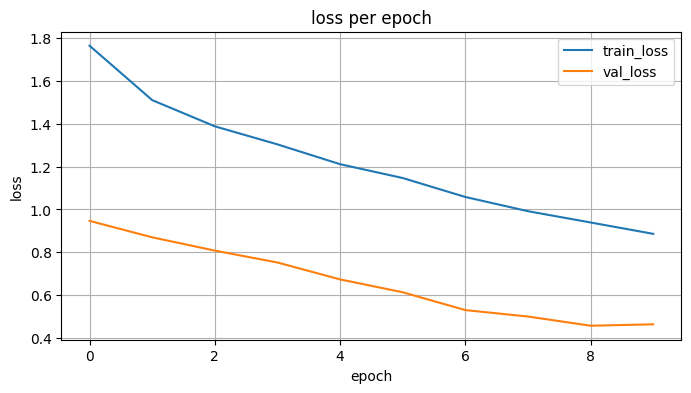

[PLOT] Saved visualization\Classifier_learning_curve_raw_precision.png


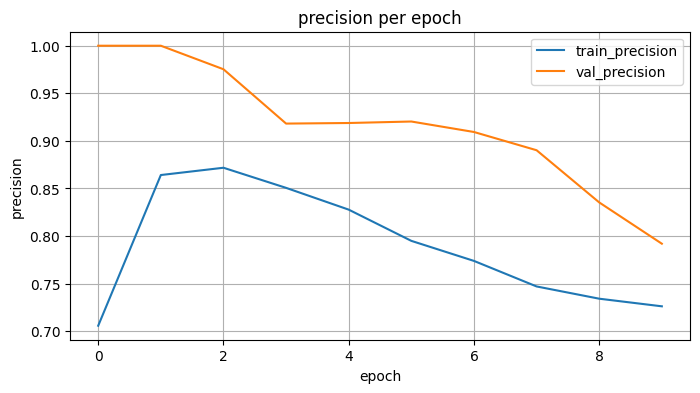

[PLOT] Saved visualization\Classifier_learning_curve_raw_recall.png


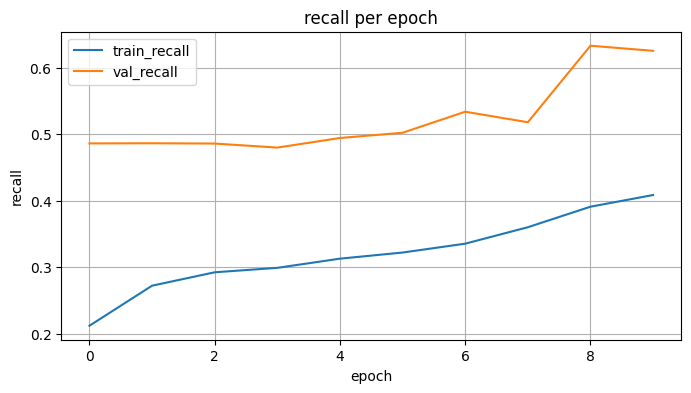

[PLOT] Saved visualization\Classifier_learning_curve_raw_learning_rate.png


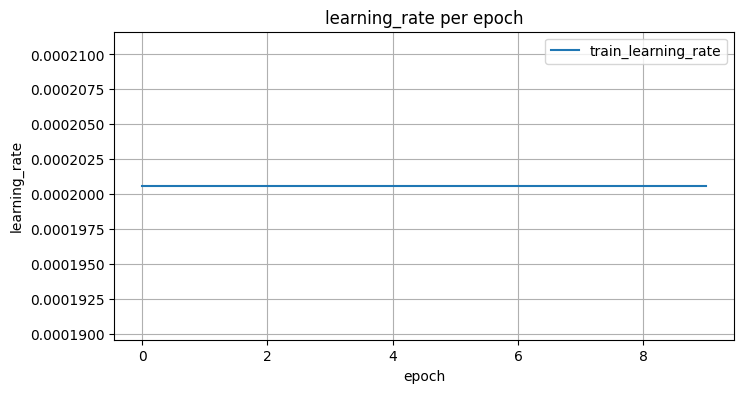

In [18]:
hypermodel = ClassifierHyperModel(sequence_length=X_raw_train_seq.shape[1], n_features=X_raw_train_seq.shape[2], n_classes=y_raw_train_seq.shape[1])
bayes_opt_raw = HyperoptBayesianOptimizer(search_space, max_evals=5)
evaluator_raw = SupervisedEvaluator(base_class_weight=base_class_weight)

tuner_raw = AdaptiveBayesianHillClimbingTuner(
    hypermodel=hypermodel,
    bayesian_optimizer=bayes_opt_raw,
    search_space=search_def,
    evaluator=evaluator_raw,
    pool_size=3,
    max_iters=10,
    max_local_steps=5,
    stagnation_threshold=3,
    log_file=json_path_raw,
    save_best_model_path=model_path_raw
)

best_result_raw = tuner_raw.run(X_raw_train_seq, y_raw_train_seq, X_raw_val_seq, y_raw_val_seq)
best_model_raw = best_result_raw["model"]
best_params_raw = best_result_raw["params"]
best_score_raw = best_result_raw["score"]

print("Best Params:", best_params_raw)
print("Best Score:", best_score_raw)

tuner_raw.plot_best_history(viz_prefix="raw", model_type="Classifier")

In [19]:
load_and_display_trials("model_tuning/results_cls/trial_results_raw.json", score_key="hp_tuning")

=== Hasil Semua Trial (Urut Berdasarkan score) ===
Trial 1 — iter: 9.0000 | local_step: 1.0000 | score: 0.7027 | step_size: 0.7467 | 
Trial 2 — score: 0.7027 | 
Trial 3 — iter: 4.0000 | local_step: 4.0000 | score: 0.6388 | step_size: 0.3398 | 
Trial 4 — iter: 10.0000 | local_step: 4.0000 | score: 0.6326 | step_size: 0.9000 | 
Trial 5 — iter: 9.0000 | local_step: 2.0000 | score: 0.6207 | step_size: 0.6720 | 
Trial 6 — iter: 6.0000 | local_step: 4.0000 | score: 0.6202 | step_size: 0.3199 | 
Trial 7 — iter: 9.0000 | local_step: 4.0000 | score: 0.6196 | step_size: 0.8132 | 
Trial 8 — iter: 3.0000 | local_step: 1.0000 | score: 0.6121 | step_size: 0.2894 | 
Trial 9 — iter: 6.0000 | local_step: 2.0000 | score: 0.6091 | step_size: 0.3231 | 
Trial 10 — iter: 4.0000 | local_step: 3.0000 | score: 0.6087 | step_size: 0.3775 | 
Trial 11 — iter: 6.0000 | local_step: 3.0000 | score: 0.6014 | step_size: 0.2908 | 
Trial 12 — iter: 3.0000 | local_step: 4.0000 | score: 0.6003 | step_size: 0.3151 | 
Trial

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.98      0.49      0.66       599
           1       0.82      0.19      0.30       424
           2       0.52      0.98      0.68       343
           3       1.00      1.00      1.00      1711
           4       0.71      0.95      0.81       474
           5       0.00      0.00      0.00       147
           6       0.24      1.00      0.39        55
           7       0.29      0.88      0.43        67

    accuracy                           0.78      3820
   macro avg       0.57      0.69      0.53      3820
weighted avg       0.84      0.78      0.76      3820

Balanced Accuracy: 0.6856260583327424
Cohen's Kappa Score: 0.706931685272205


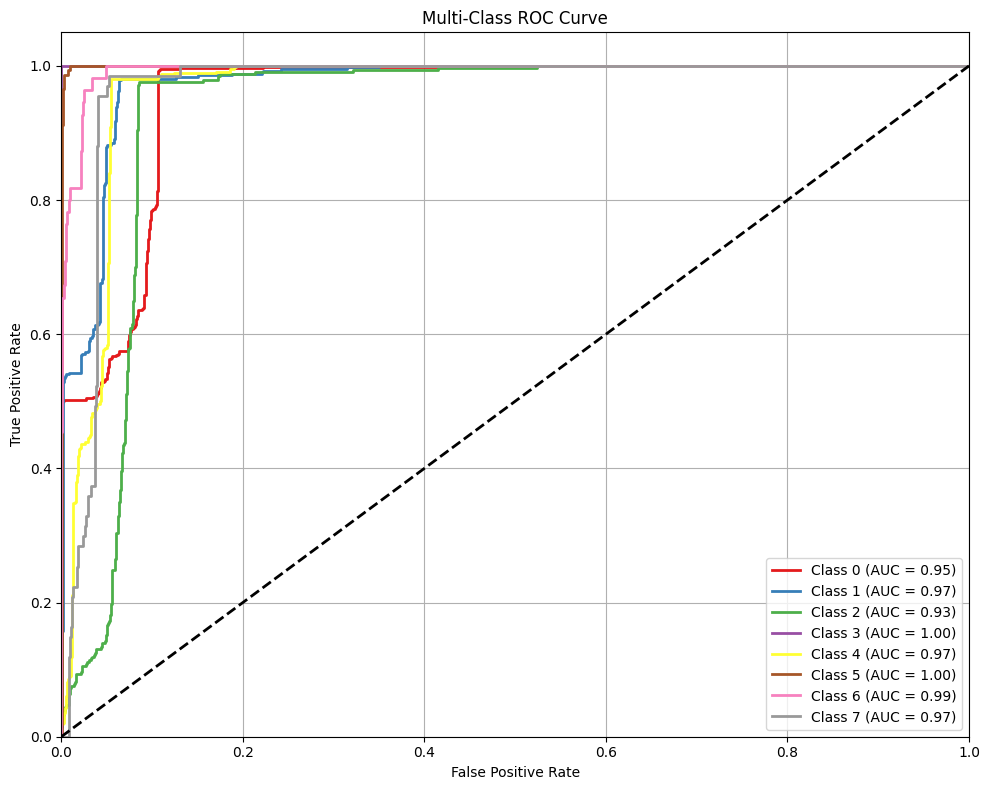

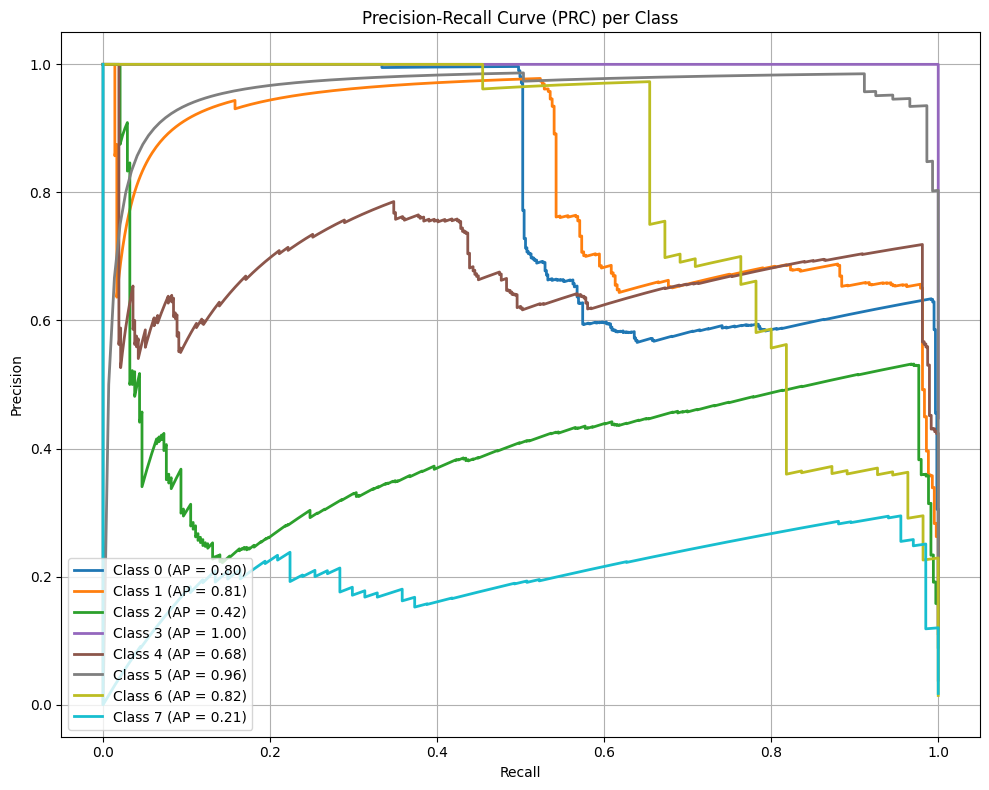

Evaluasi model selesai. Visualisasi disimpan di folder: visualization


In [20]:
evaluate_classifier_model(
    model=best_model_raw,
    X_test_seq=X_raw_test_seq,
    y_test_seq=y_raw_test_seq,
    file_prefix="raw_classifier"
)

In [22]:
# Simpan model dalam format .keras
model_path = os.path.join(artifacts_dir, "Classifier_model_raw.keras")
best_model_raw.save(model_path)

# PELATIHAN MODEL KLASIFIKASI MENGGUNAKAN DATA FE

[RUN] Starting Adaptive Bayesian Hill-Climbing Tuning
[RUN] Initial candidates (3) received from Bayesian optimizer.

[EVALUATE] Params:
  attention_dim=8
  attention_dropout=0.324413
  attention_heads=4
  class_weight_scale=0.788856
  dense_dropout_1=0.445943
  dense_dropout_2=0.360021
  dense_units_1=48
  dense_units_2=48
  learning_rate=0.000317
  lstm_dropout_1=0.310161
  lstm_dropout_2=0.185363
  lstm_units_1=176
  lstm_units_2=104
  post_attention_dropout=0.306521
  spatial_dropout=0.133778
  use_second_lstm=False
Epoch 1/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.3780 - auc: 0.7596 - loss: 1.4143 - precision: 0.5281 - recall: 0.2210 - val_accuracy: 0.8938 - val_auc: 0.9937 - val_loss: 0.3020 - val_precision: 0.9444 - val_recall: 0.8526 - learning_rate: 3.1702e-04
Epoch 2/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.7254 - auc: 0.9574 - loss: 0.6022 - precision: 0.8186 - recall: 0.6204 - val_accuracy: 0.9426 - val_auc: 0.9975 - val_loss: 0.1469 - v

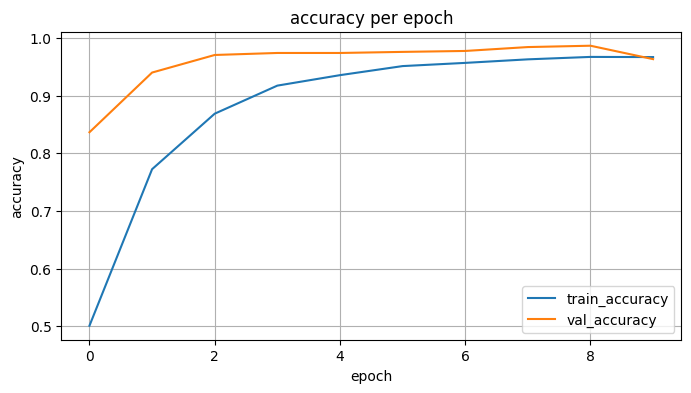

[PLOT] Saved visualization\Classifier_learning_curve_fe_auc.png


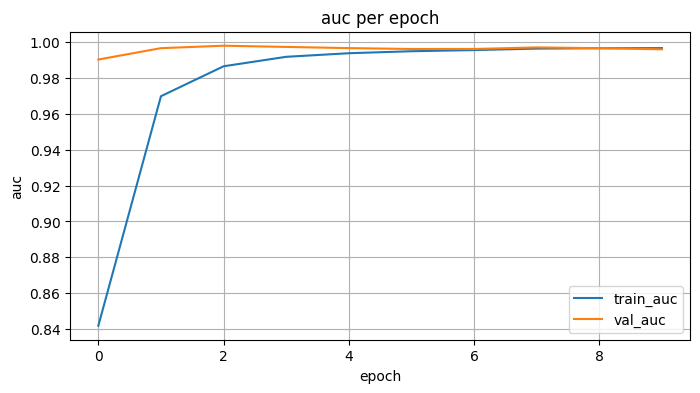

[PLOT] Saved visualization\Classifier_learning_curve_fe_loss.png


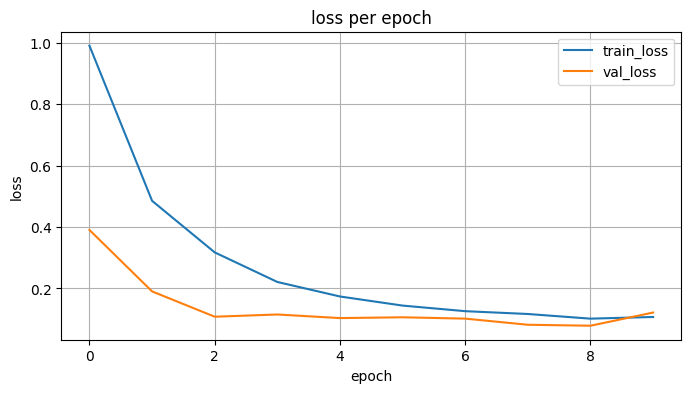

[PLOT] Saved visualization\Classifier_learning_curve_fe_precision.png


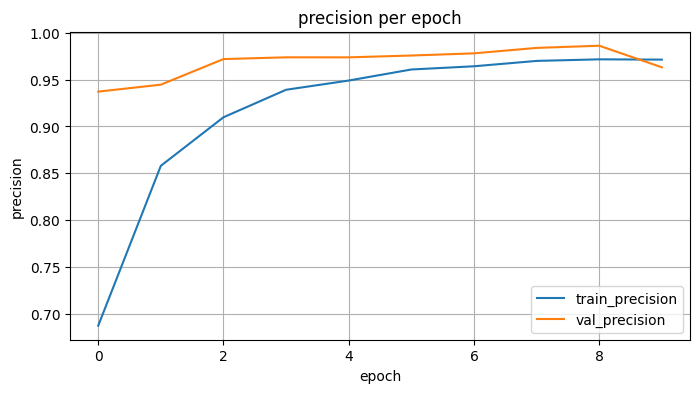

[PLOT] Saved visualization\Classifier_learning_curve_fe_recall.png


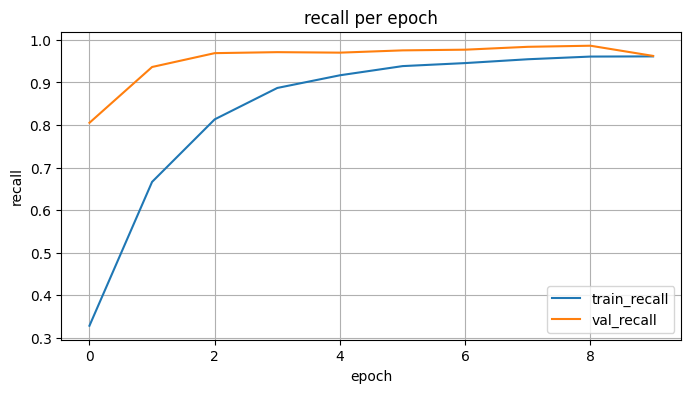

[PLOT] Saved visualization\Classifier_learning_curve_fe_learning_rate.png


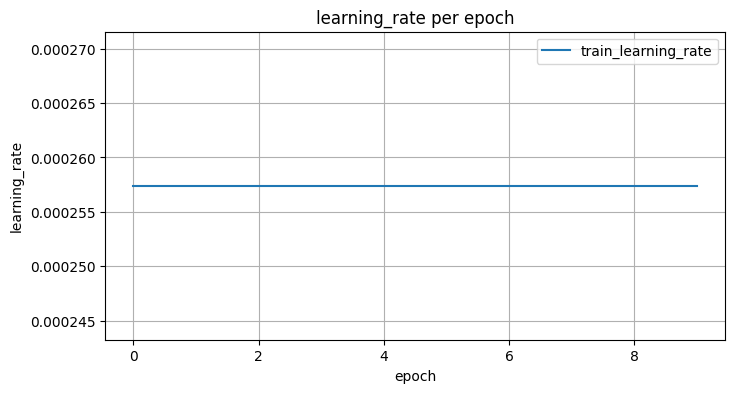

In [18]:
hypermodel_fe = ClassifierHyperModel(sequence_length=X_fe_train_seq.shape[1], n_features=X_fe_train_seq.shape[2], n_classes=y_fe_train_seq.shape[1])
bayes_opt_fe = HyperoptBayesianOptimizer(search_space, max_evals=5)
evaluator_fe = SupervisedEvaluator(base_class_weight=base_class_weight)

tuner_fe = AdaptiveBayesianHillClimbingTuner(
    hypermodel=hypermodel_fe,
    bayesian_optimizer=bayes_opt_fe,
    search_space=search_def,
    evaluator=evaluator_fe,
    pool_size=3,
    max_iters=10,
    max_local_steps=5,
    stagnation_threshold=3,
    log_file=json_path_fe,
    save_best_model_path=model_path_fe
)

best_result_fe = tuner_fe.run(X_fe_train_seq, y_fe_train_seq, X_fe_val_seq, y_fe_val_seq)
best_model_fe = best_result_fe["model"]
best_params_fe = best_result_fe["params"]
best_score_fe = best_result_fe["score"]

print("Best Params:", best_params_fe)
print("Best Score:", best_score_fe)

tuner_fe.plot_best_history(viz_prefix="fe", model_type="Classifier")

In [19]:
load_and_display_trials("model_tuning/results_cls/trial_results_fe.json", score_key="hp_tuning")

=== Hasil Semua Trial (Urut Berdasarkan score) ===
Trial 1 — iter: 10.0000 | local_step: 2.0000 | score: 0.9756 | step_size: 0.2807 | 
Trial 2 — score: 0.9756 | 
Trial 3 — iter: 7.0000 | local_step: 2.0000 | score: 0.9753 | step_size: 0.2765 | 
Trial 4 — iter: 4.0000 | local_step: 0.0000 | score: 0.9747 | step_size: 0.2502 | 
Trial 5 — iter: 4.0000 | local_step: 5.0000 | score: 0.9740 | step_size: 0.2207 | 
Trial 6 — iter: 10.0000 | local_step: 0.0000 | score: 0.9732 | step_size: 0.2835 | 
Trial 7 — iter: 7.0000 | local_step: 3.0000 | score: 0.9727 | step_size: 0.2489 | 
Trial 8 — iter: 4.0000 | local_step: 3.0000 | score: 0.9717 | step_size: 0.2229 | 
Trial 9 — iter: 0.0000 | local_step: 0.0000 | score: 0.9715 | step_size: 0.1500 | 
Trial 10 — iter: 4.0000 | local_step: 2.0000 | score: 0.9714 | step_size: 0.2477 | 
Trial 11 — iter: 7.0000 | local_step: 4.0000 | score: 0.9711 | step_size: 0.2738 | 
Trial 12 — iter: 1.0000 | local_step: 5.0000 | score: 0.9706 | step_size: 0.1617 | 
Tria

120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       599
           1       0.97      0.99      0.98       424
           2       0.98      0.99      0.98       343
           3       1.00      1.00      1.00      1711
           4       0.99      0.98      0.99       474
           5       0.96      0.99      0.98       147
           6       0.98      0.95      0.96        55
           7       0.98      0.94      0.96        67

    accuracy                           0.99      3820
   macro avg       0.98      0.98      0.98      3820
weighted avg       0.99      0.99      0.99      3820

Balanced Accuracy: 0.9776833598273836
Cohen's Kappa Score: 0.9879219236243008


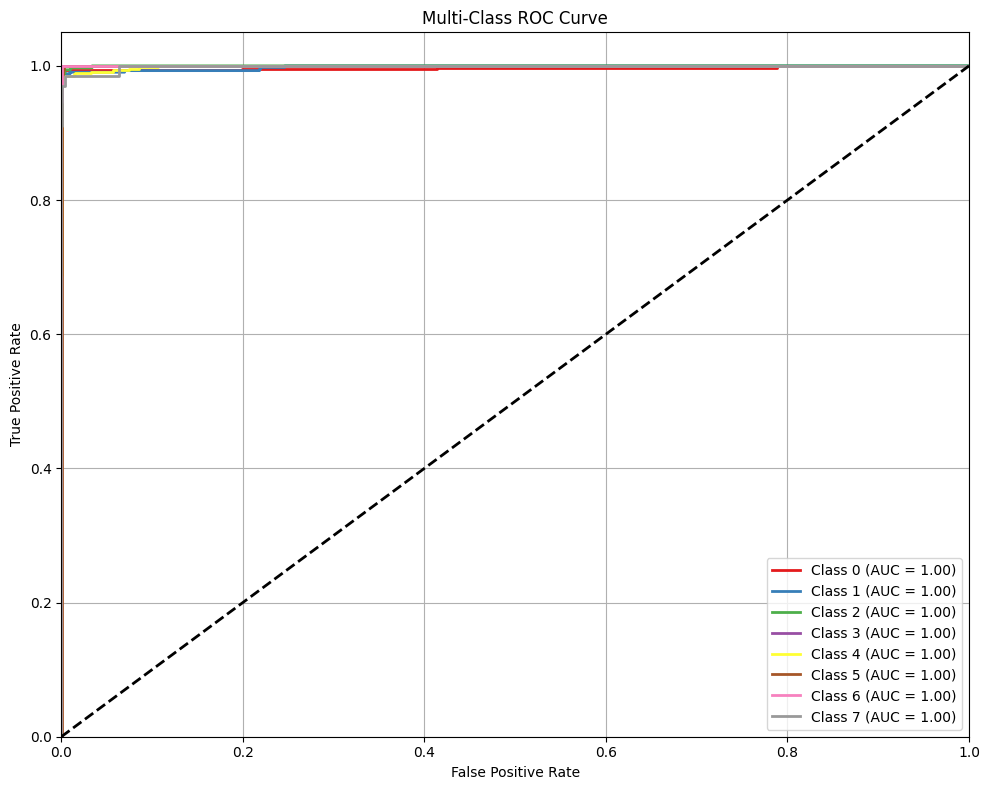

Evaluasi model selesai. Visualisasi disimpan di folder: visualization


In [20]:
evaluate_classifier_model(
    model=best_model_fe,
    X_test_seq=X_fe_test_seq,
    y_test_seq=y_fe_test_seq,
    file_prefix="fe_classifier"
)

In [21]:
# Simpan model dalam format .keras
model_path = os.path.join(artifacts_dir, "Classifier_model_fe.keras")
best_model_fe.save(model_path)

# PELATIHAN MODEL KLASIFIKASI MENGGUNAKAN DATA SELEKSI FITUR

[RUN] Starting Adaptive Bayesian Hill-Climbing Tuning
[RUN] Initial candidates (3) received from Bayesian optimizer.

[EVALUATE] Params:
  attention_dim=24
  attention_dropout=0.334514
  attention_heads=3
  class_weight_scale=0.782197
  dense_dropout_1=0.240470
  dense_dropout_2=0.370642
  dense_units_1=112
  dense_units_2=40
  learning_rate=0.000795
  lstm_dropout_1=0.340399
  lstm_dropout_2=0.124858
  lstm_units_1=104
  lstm_units_2=80
  post_attention_dropout=0.122011
  spatial_dropout=0.056997
  use_second_lstm=True
Epoch 1/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.5597 - auc: 0.8701 - loss: 1.0612 - precision: 0.6736 - recall: 0.4404 - val_accuracy: 0.9098 - val_auc: 0.9888 - val_loss: 0.3351 - val_precision: 0.9103 - val_recall: 0.9086 - learning_rate: 7.9499e-04
Epoch 2/10
482/482 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.8580 - auc: 0.9820 - loss: 0.3749 - precision: 0.8890 - recall: 0.8132 - val_accuracy: 0.8824 - val_auc: 0.9756 - val_loss: 0.5204 - v

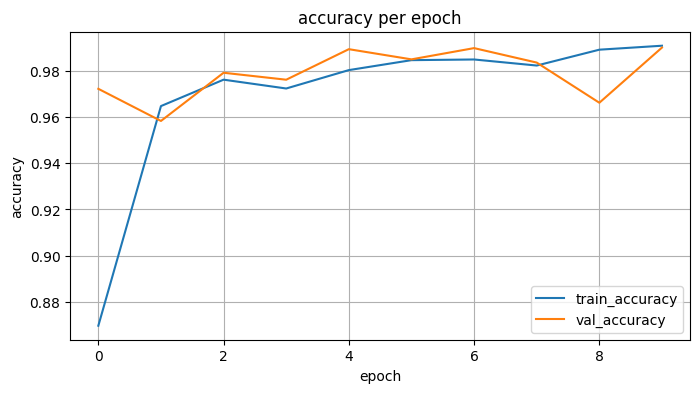

[PLOT] Saved visualization\Classifier_learning_curve_final_auc.png


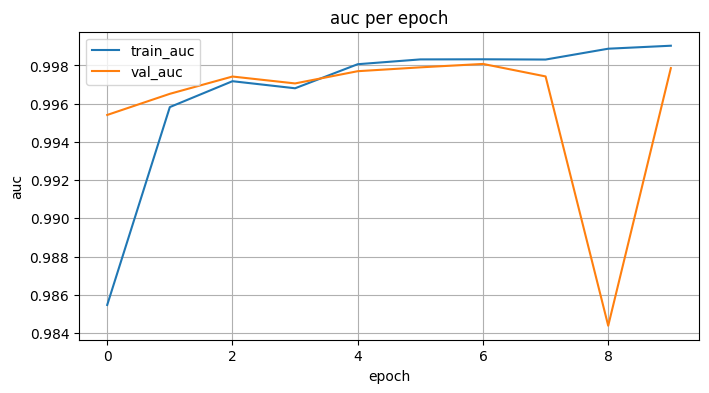

[PLOT] Saved visualization\Classifier_learning_curve_final_loss.png


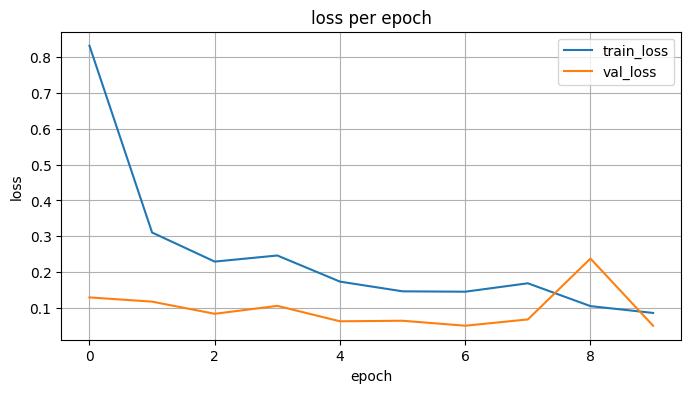

[PLOT] Saved visualization\Classifier_learning_curve_final_precision.png


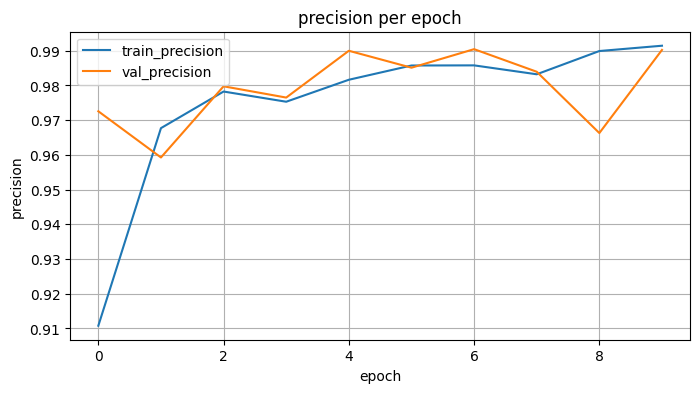

[PLOT] Saved visualization\Classifier_learning_curve_final_recall.png


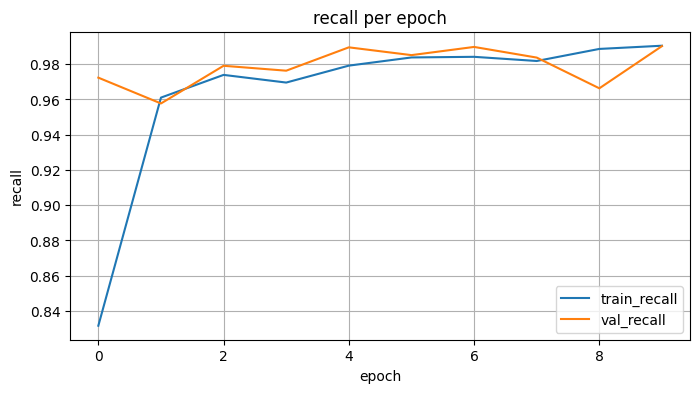

[PLOT] Saved visualization\Classifier_learning_curve_final_learning_rate.png


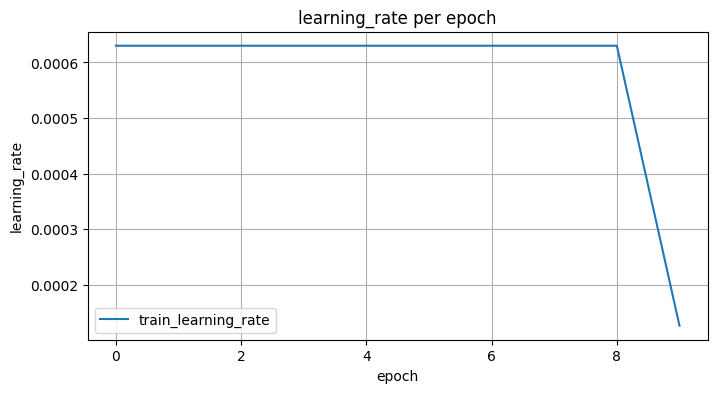

In [17]:
hypermodel_final = ClassifierHyperModel(sequence_length=X_train_seq.shape[1], n_features=X_train_seq.shape[2], n_classes=y_train_seq.shape[1])
bayes_opt_final = HyperoptBayesianOptimizer(search_space, max_evals=5)
evaluator_final = SupervisedEvaluator(base_class_weight=base_class_weight)

tuner_final = AdaptiveBayesianHillClimbingTuner(
    hypermodel=hypermodel_final,
    bayesian_optimizer=bayes_opt_final,
    search_space=search_def,
    evaluator=evaluator_final,
    pool_size=3,
    max_iters=10,
    max_local_steps=5,
    stagnation_threshold=3,
    log_file=json_path_final,
    save_best_model_path=model_path_final
)

best_result_final = tuner_final.run(X_train_seq, y_train_seq, X_val_seq, y_val_seq)
best_model_final = best_result_final["model"]
best_params_final = best_result_final["params"]
best_score_final = best_result_final["score"]

print("Best Params:", best_params_final)
print("Best Score:", best_score_final)

tuner_final.plot_best_history(viz_prefix="final", model_type="Classifier")

In [18]:
load_and_display_trials("model_tuning/results_cls/trial_results_final.json", score_key="hp_tuning")

=== Hasil Semua Trial (Urut Berdasarkan score) ===
Trial 1 — iter: 10.0000 | local_step: 3.0000 | score: 0.9788 | step_size: 0.7101 | 
Trial 2 — score: 0.9788 | 
Trial 3 — iter: 10.0000 | local_step: 5.0000 | score: 0.9752 | step_size: 0.7030 | 
Trial 4 — iter: 10.0000 | local_step: 2.0000 | score: 0.9551 | step_size: 0.7890 | 
Trial 5 — iter: 4.0000 | local_step: 4.0000 | score: 0.9549 | step_size: 0.2477 | 
Trial 6 — iter: 3.0000 | local_step: 2.0000 | score: 0.9523 | step_size: 0.1726 | 
Trial 7 — iter: 3.0000 | local_step: 3.0000 | score: 0.9520 | step_size: 0.1553 | 
Trial 8 — iter: 4.0000 | local_step: 0.0000 | score: 0.9506 | step_size: 0.2068 | 
Trial 9 — iter: 6.0000 | local_step: 0.0000 | score: 0.9493 | step_size: 0.2908 | 
Trial 10 — iter: 9.0000 | local_step: 0.0000 | score: 0.9481 | step_size: 0.6653 | 
Trial 11 — iter: 0.0000 | local_step: 0.0000 | score: 0.9478 | step_size: 0.1500 | 
Trial 12 — iter: 3.0000 | local_step: 0.0000 | score: 0.9458 | step_size: 0.1743 | 
Tri

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       599
           1       0.98      0.99      0.98       424
           2       0.99      1.00      0.99       343
           3       1.00      1.00      1.00      1711
           4       1.00      0.98      0.99       474
           5       0.95      1.00      0.98       147
           6       0.98      0.95      0.96        55
           7       1.00      0.99      0.99        67

    accuracy                           0.99      3820
   macro avg       0.99      0.99      0.99      3820
weighted avg       0.99      0.99      0.99      3820

Balanced Accuracy: 0.9859071858614452
Cohen's Kappa Score: 0.9911193654000805


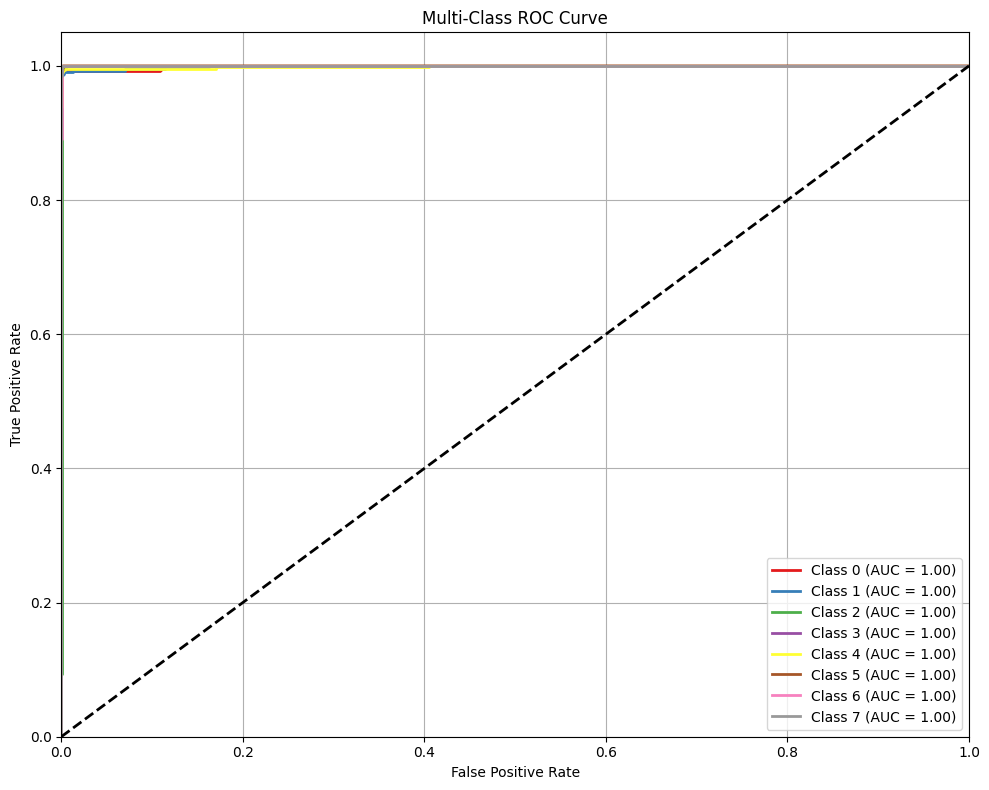

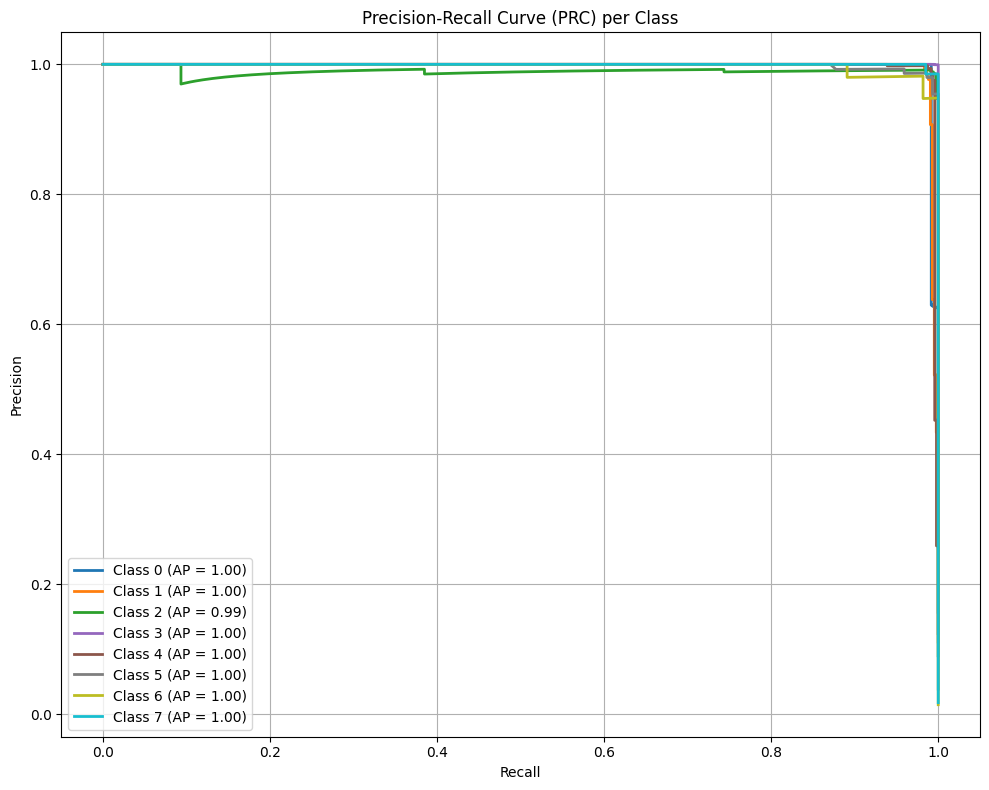

Evaluasi model selesai. Visualisasi disimpan di folder: visualization


In [19]:
evaluate_classifier_model(
    model=best_model_final,
    X_test_seq=X_test_seq,
    y_test_seq=y_test_seq,
    file_prefix="final_classifier"
)

In [20]:
# Simpan model dalam format .keras
model_path = os.path.join(artifacts_dir, "Classifier_model_final.keras")
best_model_final.save(model_path)

In [ ]:
class AnomalyHyperModel:
    def __init__(self, sequence_length, n_features):
        self.sequence_length = sequence_length
        self.n_features = n_features

    def build(self, params):
        inputs = Input(shape=(self.sequence_length, self.n_features), name='input')

        # Encoder
        encoder_units = params['encoder_units']
        encoder_dropout = params['encoder_dropout']

        encoded = Bidirectional(LSTM(
            encoder_units,
            return_sequences=False,
            dropout=encoder_dropout,
            activation='tanh'
        ), name='bilstm_encoder')(inputs)

        # Latent space
        latent_dim = params['latent_dim']
        latent = Dense(latent_dim, activation='relu', name='latent_space')(encoded)

        # Decoder
        decoder_units = params['decoder_units']
        decoder_dropout = params['decoder_dropout']

        repeated = RepeatVector(self.sequence_length)(latent)
        decoded = LSTM(
            decoder_units,
            return_sequences=True,
            dropout=decoder_dropout,
            activation='tanh',
            name='lstm_decoder'
        )(repeated)

        # Attention
        attn = MultiHeadAttention(
            num_heads=params['attention_heads'],
            key_dim=params['attention_dim'],
            dropout=params['attention_dropout']
        )(decoded, decoded)

        attn_out = Add()([decoded, attn])
        attn_out = LayerNormalization(epsilon=1e-6)(attn_out)

        # Output 1: Reconstruction
        reconstruction = TimeDistributed(
            Dense(self.n_features), name='reconstruction'
        )(attn_out)

        # Output 2: Latent output
        latent_output = Dense(latent_dim, activation='linear', name='latent_output')(latent)

        # Build model
        model = Model(inputs=inputs, outputs=[reconstruction, latent_output],
                      name="unsupervised_anomaly_detection_multiout")

        optimizer = Adam(learning_rate=params['learning_rate'])
        model.compile(
            optimizer=optimizer,
            loss={
                'reconstruction': 'mse',
                'latent_output': 'mse'
            },
            loss_weights={
                'reconstruction': 1.0,
                'latent_output': 0.0
            },
            metrics={
                'reconstruction': ['mae', 'mse']
            }
        )
        return model

In [26]:
def evaluate_anomaly_model(y_true, y_score, file_prefix=""):
    
    # === ROC Curve ===
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_score)
    auc_roc = roc_auc_score(y_true, y_score)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {auc_roc:.4f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Anomaly Detection")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, f"{file_prefix}_roc_curve.png"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    # === Precision-Recall Curve ===
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="green", lw=2, label=f"PR Curve (AP = {ap:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Anomaly Detection")
    plt.legend(loc="lower left")
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, f"{file_prefix}_pr_curve.png"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    print(f"ROC AUC: {auc_roc:.4f}")
    print(f"Average Precision (AP): {ap:.4f}")
    print(f"Evaluasi model selesai. Visualisasi disimpan di folder: {viz_dir}")

In [ ]:
def evaluate_anomaly_stress_test(model, X_normal, noise_levels=[0.01, 0.05, 0.1], 
                                 alpha=0.5, beta=0.5, file_prefix="stress_test"):
    results = {}
    # --- ROC Plot ---
    plt.figure(figsize=(7,6))
    for noise_factor in noise_levels:
        # 1. Buat pseudo-anomaly dengan Gaussian noise
        X_noisy = X_normal + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_normal.shape)
        # 2. Gabungkan normal asli (label=0) dan noisy (label=1)
        X_stress = np.concatenate([X_normal, X_noisy], axis=0)
        y_stress = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_noisy))], axis=0)
        # 3. Prediksi model → reconstruction + latent
        X_pred, latent_pred = model.predict(X_stress, verbose=0)
        # 4. Reconstruction error
        reconstruction_error = np.mean(np.square(X_stress - X_pred), axis=(1,2))
        # 5. Latent distance (L2 norm per sample)
        latent_distance = np.linalg.norm(latent_pred, axis=1)
        # 6. Skor gabungan
        anomaly_score = alpha * reconstruction_error + beta * latent_distance
        # 7. ROC & AUC
        fpr, tpr, _ = roc_curve(y_stress, anomaly_score)
        roc_auc = auc(fpr, tpr)
        # 8. PRC & Average Precision
        precision, recall, _ = precision_recall_curve(y_stress, anomaly_score)
        ap_score = average_precision_score(y_stress, anomaly_score)
        # 9. Simpan hasil
        results[noise_factor] = {"ROC_AUC": roc_auc, "AP": ap_score}
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f"Noise {noise_factor} (AUC={roc_auc:.3f}, AP={ap_score:.3f})")
    
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Stress Test (Normal vs Noisy)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{file_prefix}_roc_curve.png", dpi=300)
    plt.show()
    # --- PRC Plot ---
    plt.figure(figsize=(7,6))
    for noise_factor in noise_levels:
        X_noisy = X_normal + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_normal.shape)
        X_stress = np.concatenate([X_normal, X_noisy], axis=0)
        y_stress = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_noisy))], axis=0)
        X_pred, latent_pred = model.predict(X_stress, verbose=0)

        reconstruction_error = np.mean(np.square(X_stress - X_pred), axis=(1,2))
        latent_distance = np.linalg.norm(latent_pred, axis=1)
        anomaly_score = alpha * reconstruction_error + beta * latent_distance

        precision, recall, _ = precision_recall_curve(y_stress, anomaly_score)
        ap_score = average_precision_score(y_stress, anomaly_score)

        plt.plot(recall, precision, lw=2, label=f"Noise {noise_factor} (AP={ap_score:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Stress Test")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{file_prefix}_pr_curve.png", dpi=300)
    plt.show()
    return results

[RUN] Starting Adaptive Bayesian Hill-Climbing Tuning
[RUN] Initial candidates (3) received from Bayesian optimizer.

[EVALUATE-UNSUPERVISED] Params:
  attention_dim
  attention_dropout=0.140590
  attention_heads
  decoder_dropout=0.128465
  decoder_units
  encoder_dropout=0.074224
  encoder_units
  latent_dim
  learning_rate=0.000011
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - latent_output_loss: 0.0014 - loss: 0.0014 - reconstruction_loss: 0.0000e+00 - reconstruction_mae: 1.5917 - reconstruction_mse: 3.2326 - val_latent_output_loss: 3.4885e-04 - val_loss: 3.2918e-04 - val_reconstruction_loss: 0.0000e+00 - val_reconstruction_mae: 1.7421 - val_reconstruction_mse: 3.5468 - learning_rate: 1.1337e-05
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - latent_output_loss: 3.8720e-04 - loss: 3.8720e-04 - reconstruction_loss: 0.0000e+00 - reconstruction_mae: 1.5830 - reconstruction_mse: 3.1334 - val_latent_output_loss: 9.3474e-05 - val_loss: 8.5112e-05 - val_reconstruction_los

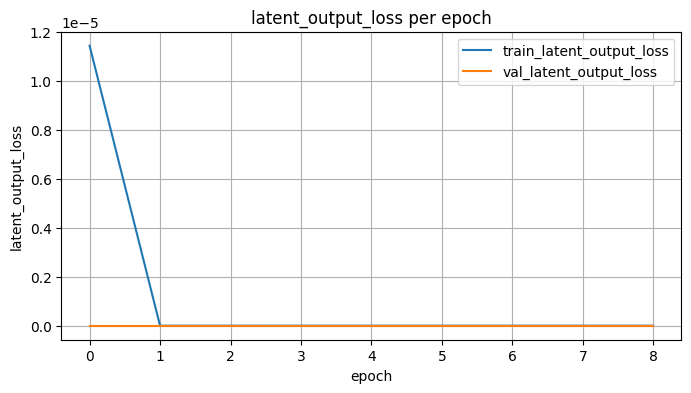

[PLOT] Saved visualization\Anomaly_detection_learning_curve_raw_loss.png


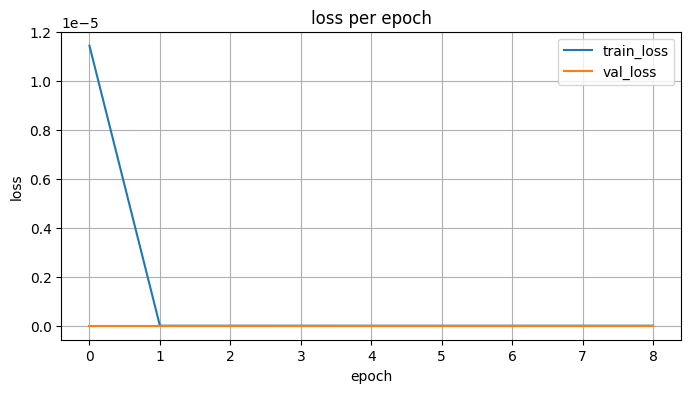

[PLOT] Saved visualization\Anomaly_detection_learning_curve_raw_reconstruction_loss.png


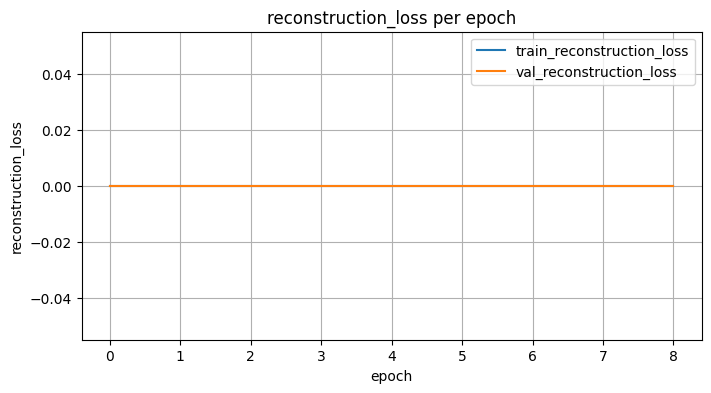

[PLOT] Saved visualization\Anomaly_detection_learning_curve_raw_reconstruction_mae.png


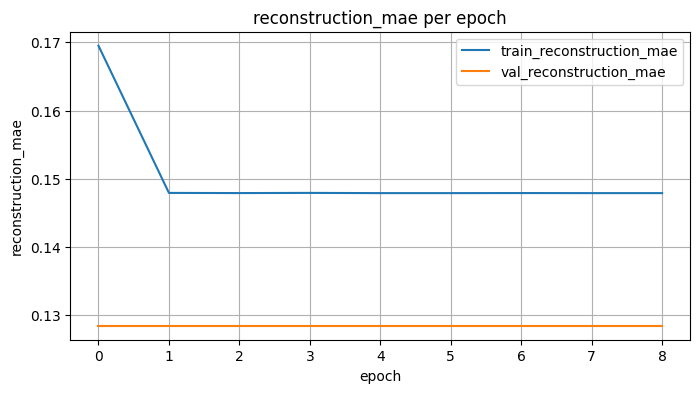

[PLOT] Saved visualization\Anomaly_detection_learning_curve_raw_reconstruction_mse.png


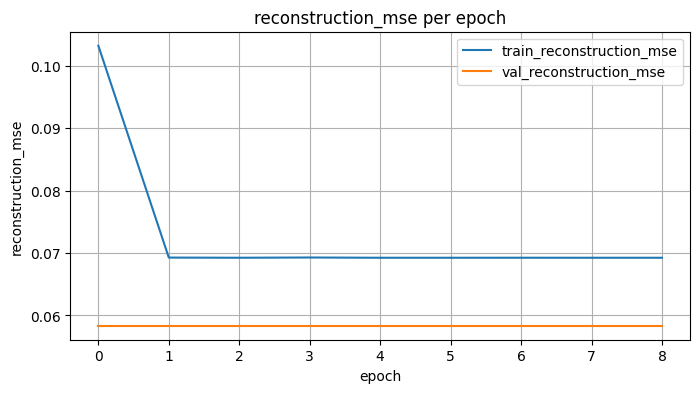

[PLOT] Saved visualization\Anomaly_detection_learning_curve_raw_learning_rate.png


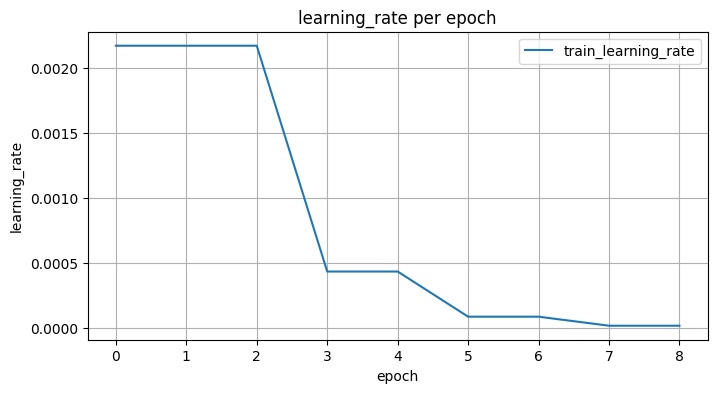

In [ ]:
hypermodel_ae_raw = AnomalyHyperModel(sequence_length=X_raw_train_ae_seq.shape[1], n_features=X_raw_train_ae_seq.shape[2])
bayes_opt_ae_raw = HyperoptBayesianOptimizer(search_space_anomaly, max_evals=5)
evaluator_ae_raw = UnsupervisedEvaluator()

tuner_ae_raw = AdaptiveBayesianHillClimbingTuner(
    hypermodel=hypermodel_ae_raw,
    bayesian_optimizer=bayes_opt_ae_raw,
    search_space=search_def_anomaly,
    evaluator=evaluator_ae_raw,
    pool_size=3,
    max_iters=5,
    max_local_steps=5,
    stagnation_threshold=3,
    log_file=json_path_ae_raw,
    save_best_model_path=model_path_ae_raw
)

best_result_ae_raw = tuner_ae_raw.run(X_raw_train_ae_seq, z_raw_train_ae_seq, X_raw_val_ae_seq, z_raw_val_ae_seq)
best_model_ae_raw = best_result_ae_raw["model"]
best_params_ae_raw = best_result_ae_raw["params"]
best_score_ae_raw = best_result_ae_raw["score"]

print("Best Params:", best_params_ae_raw)
print("Best Score:", best_score_ae_raw)

tuner_ae_raw.plot_best_history(viz_prefix="raw", model_type="Anomaly_detection")

In [22]:
load_and_display_trials("model_tuning/results_ae/trial_results_raw.json", score_key="hp_tuning")

=== Hasil Semua Trial (Urut Berdasarkan score) ===
Trial 1 — iter: 2.0000 | local_step: 2.0000 | score: 100.0000 | step_size: 0.2174 | 
Trial 2 — iter: 4.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.2068 | 
Trial 3 — iter: 5.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.2997 | 
Trial 4 — iter: 5.0000 | local_step: 3.0000 | score: 100.0000 | step_size: 0.3264 | 
Trial 5 — iter: 8.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.5610 | 
Trial 6 — iter: 8.0000 | local_step: 2.0000 | score: 100.0000 | step_size: 0.5554 | 
Trial 7 — iter: 10.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.7245 | 
Trial 8 — score: 100.0000 | 
Trial 9 — iter: 8.0000 | local_step: 1.0000 | score: 100.0000 | step_size: 0.5049 | 
Trial 10 — iter: 7.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.4258 | 
Trial 11 — iter: 2.0000 | local_step: 4.0000 | score: 100.0000 | step_size: 0.2152 | 
Trial 12 — iter: 2.0000 | local_step: 0.0000 | score: 100.0000 | st

In [41]:
# Ambil output reconstruction (biasanya index ke-0)
recon_pred_raw_test, latent_pred_raw_test = best_model_ae_raw.predict(X_raw_test_ae_seq, verbose=0)

# Hitung reconstruction error (MSE per sample)
reconstruction_error_raw = np.mean(
    np.square(X_raw_test_ae_seq - recon_pred_raw_test), axis=(1, 2)
)

latent_distance_raw = np.linalg.norm(latent_pred_raw_test, axis=1)

# === Gabungan skor anomali ===
alpha, beta = 0.5, 0.5  # bisa di-tuning
anomaly_score_raw = alpha * reconstruction_error_raw + beta * latent_distance_raw

print("Shape anomaly_score_raw:", anomaly_score_raw.shape)
print("Contoh anomaly score:", anomaly_score_raw[:10])

Shape anomaly_score_raw: (3820,)
Contoh anomaly score: [0.02371644 0.02371749 0.02375578 0.02379391 0.0238319  0.02386973
 0.02390742 0.0239451  0.02398263 0.02402017]


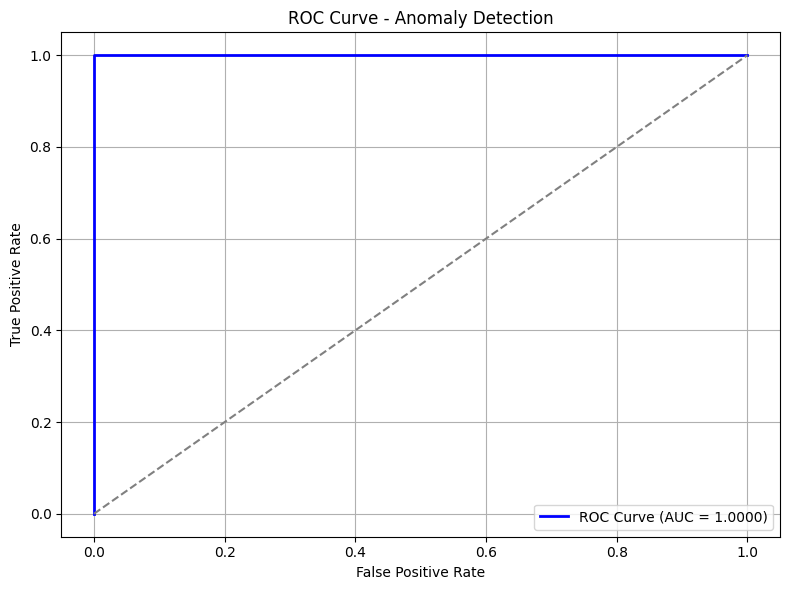

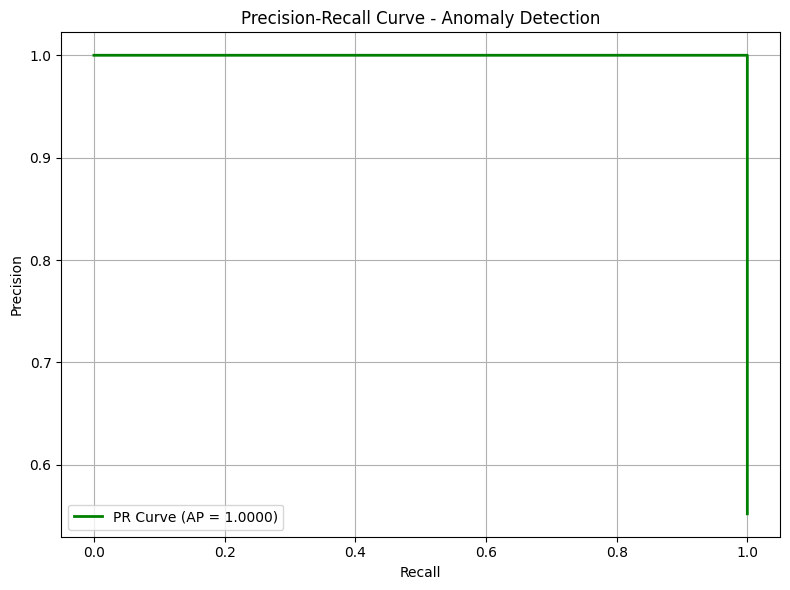

ROC AUC: 1.0000
Average Precision (AP): 1.0000
Evaluasi model selesai. Visualisasi disimpan di folder: visualization


In [43]:
evaluate_anomaly_model(z_raw_test_ae_seq, anomaly_score_raw, file_prefix="ae_raw")

In [61]:
# Ambil data normal dari test set
X_normal_sample = X_raw_test_ae_seq[z_raw_test_ae_seq == 0]

# Evaluasi robustness
stress_results = evaluate_anomaly_stress_test(best_model_ae_raw, X_normal_sample, noise_levels=[0.01, 0.05, 0.1, 0.2], file_prefix="raw_stress_test")

print("📊 Hasil Stress Test:")
for noise, metrics in stress_results.items():
    print(f"Noise {noise}: ROC AUC={metrics['ROC_AUC']:.4f}, AP={metrics['AP']:.4f}")


📊 Hasil Stress Test:
Noise 0.01: ROC AUC=0.5387, AP=0.5743
Noise 0.05: ROC AUC=0.6935, AP=0.6631
Noise 0.1: ROC AUC=0.8146, AP=0.7335
Noise 0.2: ROC AUC=0.8864, AP=0.8136


In [46]:
# Simpan model dalam format .keras
model_path_ae = os.path.join(artifacts_dir, "Anomaly_detection_model_raw.keras")
best_model_ae_raw.save(model_path_ae)

[RUN] Starting Adaptive Bayesian Hill-Climbing Tuning
[RUN] Initial candidates (3) received from Bayesian optimizer.

[EVALUATE-UNSUPERVISED] Params:
  attention_dim
  attention_dropout=0.397105
  attention_heads
  decoder_dropout=0.203288
  decoder_units
  encoder_dropout=0.236189
  encoder_units
  latent_dim
  learning_rate=0.000037
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - latent_output_loss: 0.0139 - loss: 0.0139 - reconstruction_loss: 0.0000e+00 - reconstruction_mae: 1.0577 - reconstruction_mse: 1.7410 - val_latent_output_loss: 0.0011 - val_loss: 0.0010 - val_reconstruction_loss: 0.0000e+00 - val_reconstruction_mae: 1.0966 - val_reconstruction_mse: 1.8015 - learning_rate: 3.6581e-05
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - latent_output_loss: 0.0024 - loss: 0.0024 - reconstruction_loss: 0.0000e+00 - reconstruction_mae: 1.0526 - reconstruction_mse: 1.7125 - val_latent_output_loss: 6.3430e-05 - val_loss: 5.9908e-05 - val_reconstruction_loss: 0.0000e+00 - 

[PLOT] Saved visualization\Anomaly_detection_learning_curve_fe_loss.png


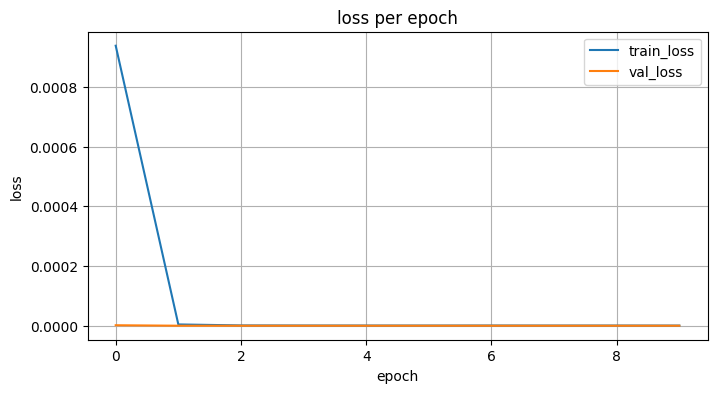

[PLOT] Saved visualization\Anomaly_detection_learning_curve_fe_reconstruction_loss.png


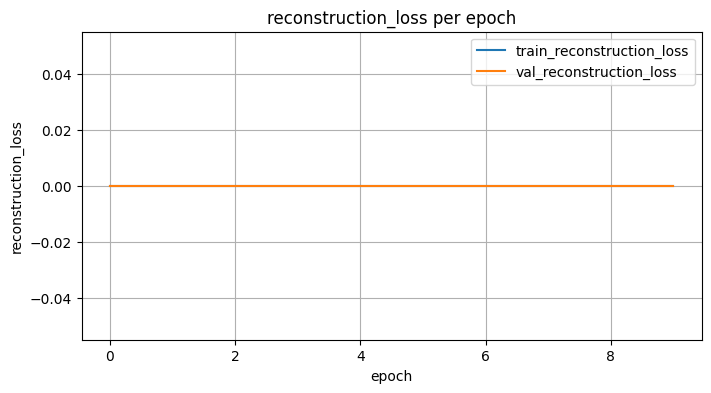

[PLOT] Saved visualization\Anomaly_detection_learning_curve_fe_reconstruction_mae.png


[PLOT] Saved visualization\Anomaly_detection_learning_curve_fe_reconstruction_mse.png


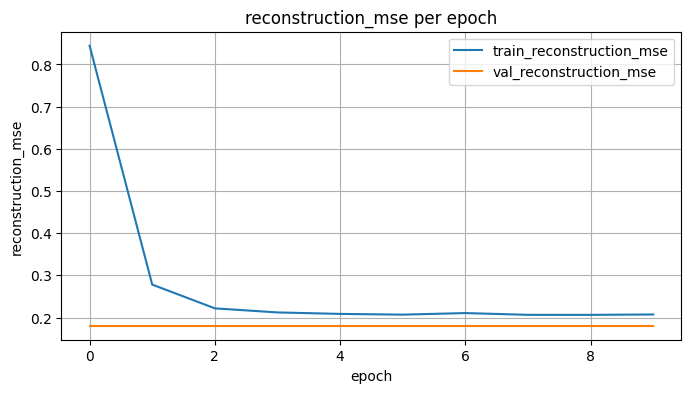

[PLOT] Saved visualization\Anomaly_detection_learning_curve_fe_learning_rate.png


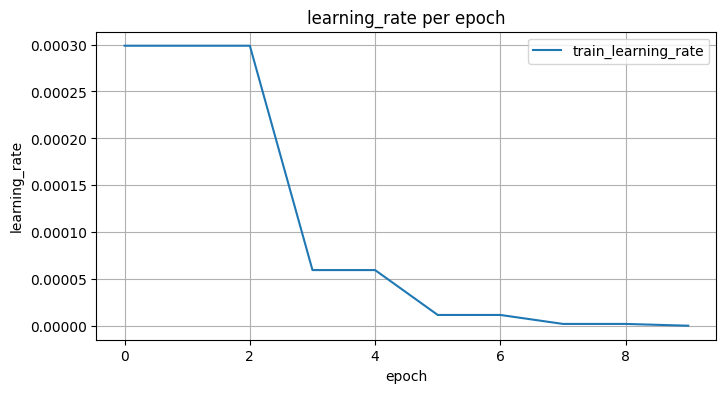

In [47]:
hypermodel_ae_fe = AnomalyHyperModel(sequence_length=X_fe_train_ae_seq.shape[1], n_features=X_fe_train_ae_seq.shape[2])
bayes_opt_ae_fe = HyperoptBayesianOptimizer(search_space_anomaly, max_evals=5)
evaluator_ae_fe = UnsupervisedEvaluator()

tuner_ae_fe = AdaptiveBayesianHillClimbingTuner(
    hypermodel=hypermodel_ae_fe,
    bayesian_optimizer=bayes_opt_ae_fe,
    search_space=search_def_anomaly,
    evaluator=evaluator_ae_fe,
    pool_size=3,
    max_iters=5,
    max_local_steps=5,
    stagnation_threshold=3,
    log_file=json_path_ae_fe,
    save_best_model_path=model_path_ae_fe
)

best_result_ae_fe = tuner_ae_fe.run(X_fe_train_ae_seq, z_fe_train_ae_seq, X_fe_val_ae_seq, z_fe_val_ae_seq)
best_model_ae_fe = best_result_ae_fe["model"]
best_params_ae_fe = best_result_ae_fe["params"]
best_score_ae_fe = best_result_ae_fe["score"]

print("Best Params:", best_params_ae_fe)
print("Best Score:", best_score_ae_fe)

tuner_ae_fe.plot_best_history(viz_prefix="fe", model_type="Anomaly_detection")

In [48]:
load_and_display_trials("model_tuning/results_ae/trial_results_fe.json", score_key="hp_tuning")

=== Hasil Semua Trial (Urut Berdasarkan score) ===
Trial 1 — iter: 5.0000 | local_step: 4.0000 | score: 100.0000 | step_size: 0.1477 | 
Trial 2 — score: 100.0000 | 
Trial 3 — iter: 5.0000 | local_step: 3.0000 | score: 100.0000 | step_size: 0.1641 | 
Trial 4 — iter: 2.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.1797 | 
Trial 5 — iter: 5.0000 | local_step: 5.0000 | score: 100.0000 | step_size: 0.1330 | 
Trial 6 — iter: 5.0000 | local_step: 2.0000 | score: 100.0000 | step_size: 0.1824 | 
Trial 7 — iter: 5.0000 | local_step: 1.0000 | score: 100.0000 | step_size: 0.2026 | 
Trial 8 — iter: 4.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.2321 | 
Trial 9 — iter: 5.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.2252 | 
Trial 10 — iter: 0.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.1500 | 
Trial 11 — iter: 2.0000 | local_step: 2.0000 | score: 100.0000 | step_size: 0.1779 | 
Trial 12 — iter: 2.0000 | local_step: 1.0000 | score: 100.0000 | ste

In [49]:
# Ambil output reconstruction (biasanya index ke-0)
recon_pred_fe_test, latent_pred_fe_test = best_model_ae_fe.predict(X_fe_test_ae_seq, verbose=0)

# Hitung reconstruction error (MSE per sample)
reconstruction_error_fe = np.mean(
    np.square(X_fe_test_ae_seq - recon_pred_fe_test), axis=(1, 2)
)

latent_distance_fe = np.linalg.norm(latent_pred_fe_test, axis=1)

# === Gabungan skor anomali ===
alpha, beta = 0.5, 0.5  # bisa di-tuning
anomaly_score_fe = alpha * reconstruction_error_fe + beta * latent_distance_fe

print("Shape anomaly_score_fe:", anomaly_score_fe.shape)
print("Contoh anomaly score:", anomaly_score_fe[:10])

Shape anomaly_score_fe: (3820,)
Contoh anomaly score: [0.10861347 0.10970203 0.11144552 0.11058809 0.11169025 0.11172586
 0.10930497 0.10875782 0.10592152 0.10531964]


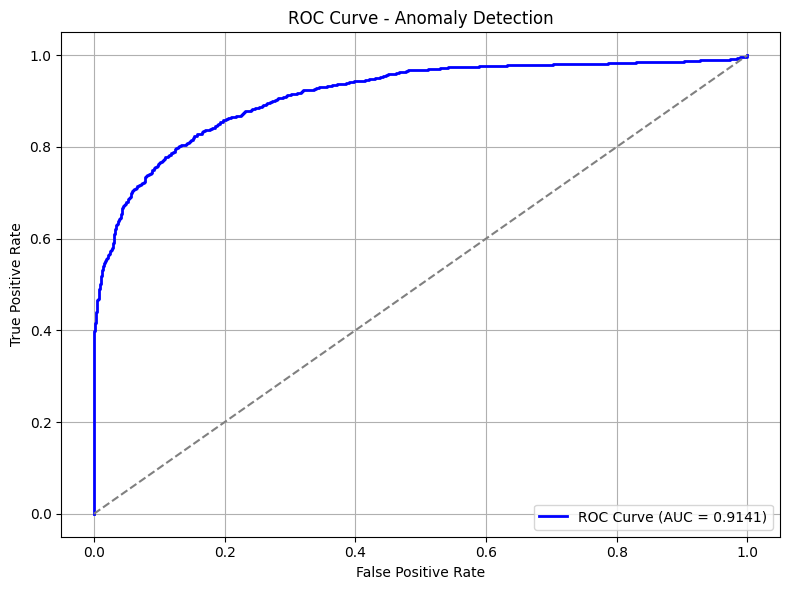

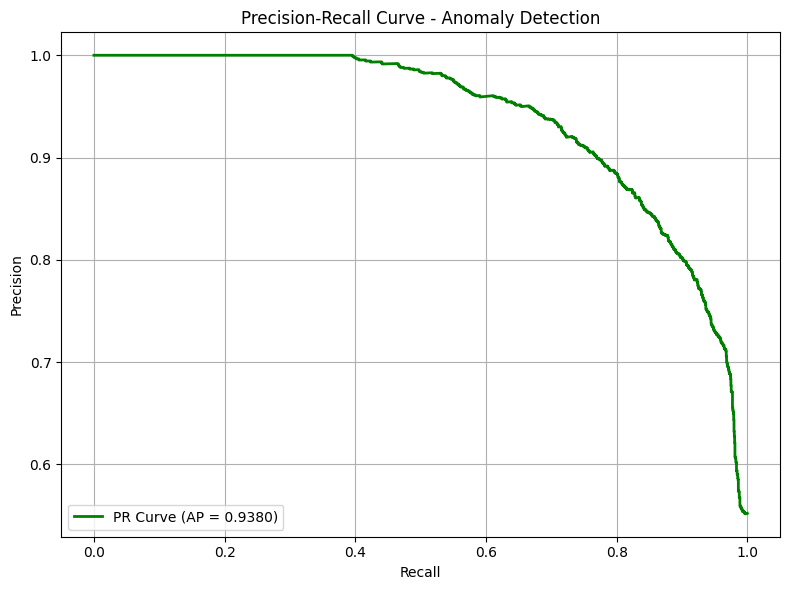

ROC AUC: 0.9141
Average Precision (AP): 0.9380
Evaluasi model selesai. Visualisasi disimpan di folder: visualization


In [50]:
evaluate_anomaly_model(z_fe_test_ae_seq, anomaly_score_fe, file_prefix="ae_fe")

In [62]:
# Ambil data normal dari test set
X_normal_sample_fe = X_fe_test_ae_seq[z_fe_test_ae_seq == 0]

# Evaluasi robustness
stress_results_fe = evaluate_anomaly_stress_test(best_model_ae_fe, X_normal_sample_fe, noise_levels=[0.01, 0.05, 0.1, 0.2], file_prefix="fe_stress_test")

print("📊 Hasil Stress Test:")
for noise, metrics in stress_results_fe.items():
    print(f"Noise {noise}: ROC AUC={metrics['ROC_AUC']:.4f}, AP={metrics['AP']:.4f}")


📊 Hasil Stress Test:
Noise 0.01: ROC AUC=0.5026, AP=0.5021
Noise 0.05: ROC AUC=0.5576, AP=0.5363
Noise 0.1: ROC AUC=0.6836, AP=0.6336
Noise 0.2: ROC AUC=0.9328, AP=0.9148


In [52]:
# Simpan model dalam format .keras
model_path_ae = os.path.join(artifacts_dir, "Anomaly_detection_model_fe.keras")
best_model_ae_fe.save(model_path_ae)

[RUN] Starting Adaptive Bayesian Hill-Climbing Tuning
[RUN] Initial candidates (3) received from Bayesian optimizer.

[EVALUATE-UNSUPERVISED] Params:
  attention_dim
  attention_dropout=0.140614
  attention_heads
  decoder_dropout=0.348676
  decoder_units
  encoder_dropout=0.104534
  encoder_units
  latent_dim
  learning_rate=0.005434
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - latent_output_loss: 8.5135e-05 - loss: 8.5135e-05 - reconstruction_loss: 0.0000e+00 - reconstruction_mae: 0.2566 - reconstruction_mse: 0.3159 - val_latent_output_loss: 4.2171e-12 - val_loss: 4.2171e-12 - val_reconstruction_loss: 0.0000e+00 - val_reconstruction_mae: 0.0910 - val_reconstruction_mse: 0.0410 - learning_rate: 0.0054
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - latent_output_loss: 1.6300e-10 - loss: 1.6300e-10 - reconstruction_loss: 0.0000e+00 - reconstruction_mae: 0.0948 - reconstruction_mse: 0.0398 - val_latent_output_loss: 7.1998e-17 - val_loss: 7.1998e-17 - val_reconstructio

[PLOT] Saved visualization\Anomaly_detection_learning_curve_final_loss.png


[PLOT] Saved visualization\Anomaly_detection_learning_curve_final_reconstruction_loss.png


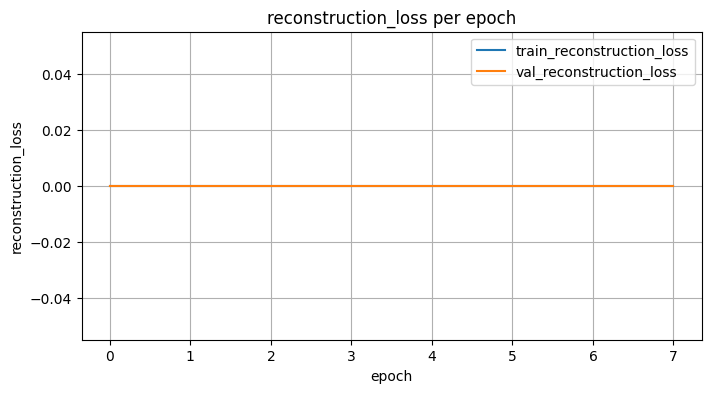

[PLOT] Saved visualization\Anomaly_detection_learning_curve_final_reconstruction_mae.png


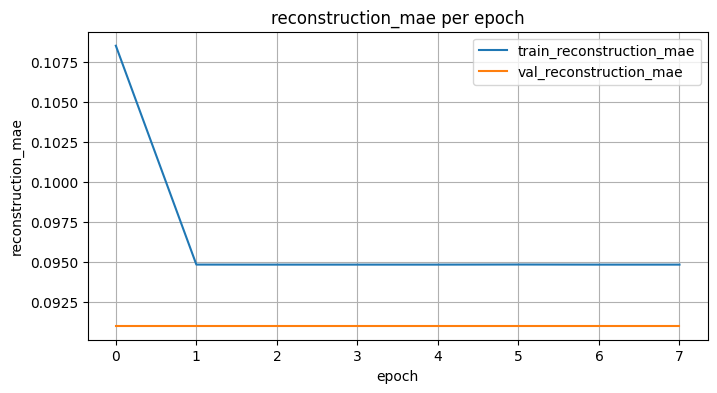

[PLOT] Saved visualization\Anomaly_detection_learning_curve_final_reconstruction_mse.png


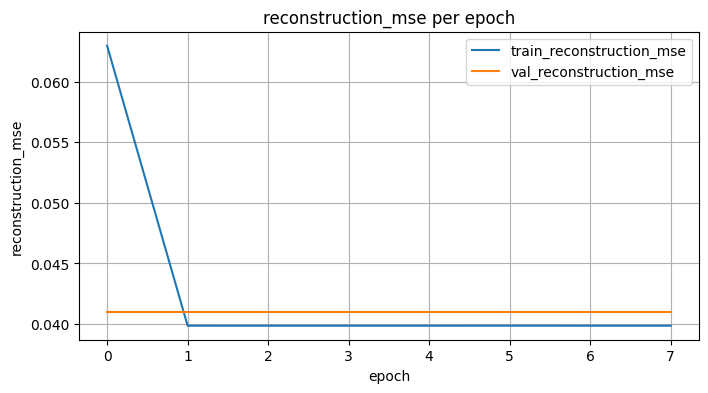

[PLOT] Saved visualization\Anomaly_detection_learning_curve_final_learning_rate.png


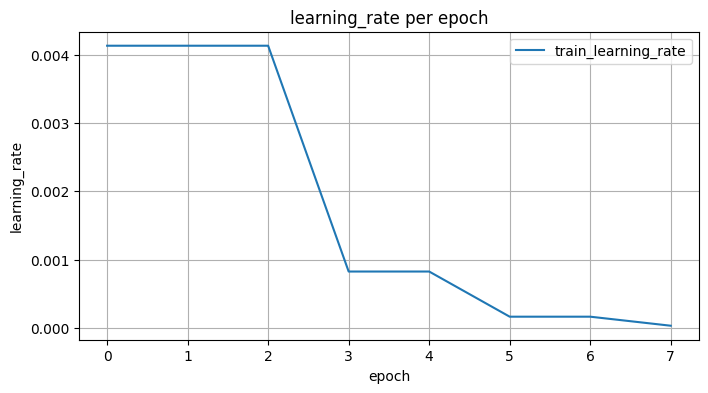

In [55]:
hypermodel_ae_final = AnomalyHyperModel(sequence_length=X_train_ae_seq.shape[1], n_features=X_train_ae_seq.shape[2])
bayes_opt_ae_final = HyperoptBayesianOptimizer(search_space_anomaly, max_evals=5)
evaluator_ae_final = UnsupervisedEvaluator()

tuner_ae_final = AdaptiveBayesianHillClimbingTuner(
    hypermodel=hypermodel_ae_final,
    bayesian_optimizer=bayes_opt_ae_final,
    search_space=search_def_anomaly,
    evaluator=evaluator_ae_final,
    pool_size=3,
    max_iters=5,
    max_local_steps=5,
    stagnation_threshold=3,
    log_file=json_path_ae_final,
    save_best_model_path=model_path_ae_final
)

best_result_ae_final = tuner_ae_final.run(X_train_ae_seq, z_train_ae_seq, X_val_ae_seq, z_val_ae_seq)
best_model_ae_final = best_result_ae_final["model"]
best_params_ae_final = best_result_ae_final["params"]
best_score_ae_final = best_result_ae_final["score"]

print("Best Params:", best_params_ae_final)
print("Best Score:", best_score_ae_final)

tuner_ae_final.plot_best_history(viz_prefix="final", model_type="Anomaly_detection")

In [56]:
load_and_display_trials("model_tuning/results_ae/trial_results_final.json", score_key="hp_tuning")

=== Hasil Semua Trial (Urut Berdasarkan score) ===
Trial 1 — iter: 0.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.1500 | 
Trial 2 — iter: 3.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.1743 | 
Trial 3 — iter: 3.0000 | local_step: 1.0000 | score: 100.0000 | step_size: 0.1569 | 
Trial 4 — iter: 3.0000 | local_step: 2.0000 | score: 100.0000 | step_size: 0.1726 | 
Trial 5 — iter: 3.0000 | local_step: 3.0000 | score: 100.0000 | step_size: 0.1899 | 
Trial 6 — iter: 4.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.2089 | 
Trial 7 — iter: 4.0000 | local_step: 4.0000 | score: 100.0000 | step_size: 0.2047 | 
Trial 8 — score: 100.0000 | 
Trial 9 — iter: 4.0000 | local_step: 3.0000 | score: 100.0000 | step_size: 0.2274 | 
Trial 10 — iter: 4.0000 | local_step: 5.0000 | score: 100.0000 | step_size: 0.1842 | 
Trial 11 — iter: 1.0000 | local_step: 0.0000 | score: 100.0000 | step_size: 0.1500 | 
Trial 12 — iter: 1.0000 | local_step: 2.0000 | score: 100.0000 | ste

In [57]:
# Ambil output reconstruction (biasanya index ke-0)
recon_pred_final_test, latent_pred_final_test = best_model_ae_final.predict(X_test_ae_seq, verbose=0)

# Hitung reconstruction error (MSE per sample)
reconstruction_error_final = np.mean(
    np.square(X_test_ae_seq - recon_pred_final_test), axis=(1, 2)
)

latent_distance_final = np.linalg.norm(latent_pred_final_test, axis=1)

# === Gabungan skor anomali ===
alpha, beta = 0.5, 0.5  # bisa di-tuning
anomaly_score_final = alpha * reconstruction_error_final + beta * latent_distance_final

print("Shape anomaly_score_final:", anomaly_score_final.shape)
print("Contoh anomaly score:", anomaly_score_final[:10])

Shape anomaly_score_final: (3820,)
Contoh anomaly score: [0.02152171 0.02152171 0.02152378 0.02152408 0.02152435 0.0215246
 0.02152489 0.02152503 0.0215252  0.02152531]


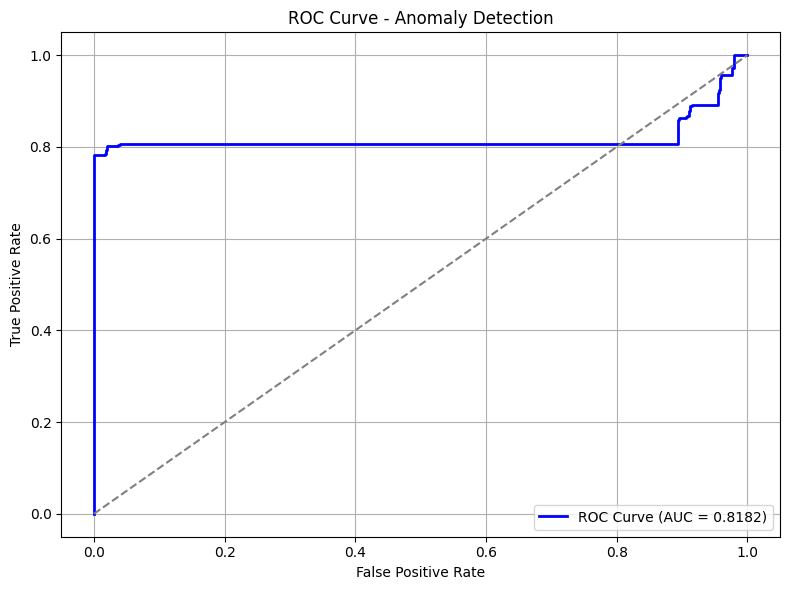

ROC AUC: 0.8182
Average Precision (AP): 0.9110
Evaluasi model selesai. Visualisasi disimpan di folder: visualization


In [58]:
evaluate_anomaly_model(z_test_ae_seq, anomaly_score_final, file_prefix="ae_final")

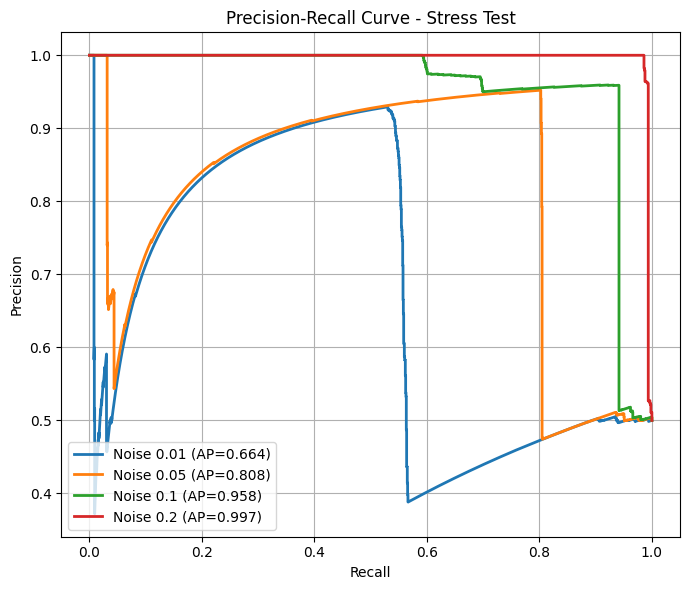

📊 Hasil Stress Test:
Noise 0.01: ROC AUC=0.5696, AP=0.6602
Noise 0.05: ROC AUC=0.7958, AP=0.8111
Noise 0.1: ROC AUC=0.9385, AP=0.9591
Noise 0.2: ROC AUC=0.9931, AP=0.9962


In [63]:
# Ambil data normal dari test set
X_normal_sample_final = X_test_ae_seq[z_test_ae_seq == 0]

# Evaluasi robustness
stress_results_final = evaluate_anomaly_stress_test(best_model_ae_final, X_normal_sample_final, noise_levels=[0.01, 0.05, 0.1, 0.2], file_prefix="final_stress_test")

print("📊 Hasil Stress Test:")
for noise, metrics in stress_results_final.items():
    print(f"Noise {noise}: ROC AUC={metrics['ROC_AUC']:.4f}, AP={metrics['AP']:.4f}")


In [60]:
# Simpan model dalam format .keras
model_path_ae = os.path.join(artifacts_dir, "Anomaly_detection_model_final.keras")
best_model_ae_final.save(model_path_ae)